## Load Dataset

A short script to load the data and preprocess it into a dataset

In [1]:
import numpy as np
import os
import cv2
from sklearn.utils import shuffle

In [2]:
def load_data(dir, c):
    images = []
    label = []
    for filename in os.listdir(dir):
        if filename.endswith(".jpg"): 
            im = cv2.imread(os.path.join(dir, filename)).astype(np.float32)
            images.append(im/255)
            label.append(c)
    return np.array(images), np.array(label)

In [3]:
def load_data_set(dir):
    categories = ["r0", "r1", "r2", "r3"]
    images = []
    label = []
    for i, c in enumerate(categories):
        x, y = load_data(os.path.join(dir, c), i)
        images.append(x)
        label.append(y)
    data_x = np.concatenate(images, axis = 0)
    data_y = np.concatenate(label)
    data_x, data_y = shuffle(data_x, data_y, random_state=0)
    
    size = len(data_x)
    sep = int(size*0.9)
    
    train_x = data_x[:sep]
    train_y = data_y[:sep]
    test_x = data_x[sep:]
    test_y = data_y[sep:]
    return train_x, train_y, test_x, test_y
    

## Data Visualization

Let us visualize the data to gain a better understanding of it

In [4]:
import matplotlib.pyplot as plt

In [27]:
train_x, train_y, test_x, test_y = load_data_set('4 categories')

In [5]:
def visualize(x, y):
    imgplot = plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
    plt.title("Category:" + str(y))
    plt.show()

In [6]:
def visualize_dataset(train_x, train_y):
    categories = [0, 1, 2, 3]
    for c in categories:
        for i in xrange(len(train_y)):
            if train_y[i] == c:
                visualize(train_x[i], train_y[i])
                break

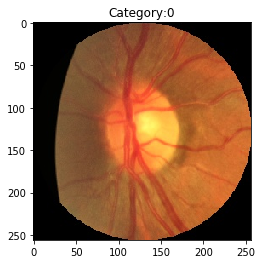

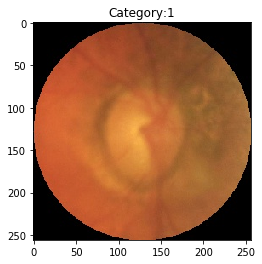

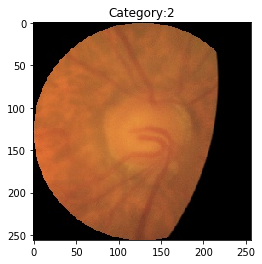

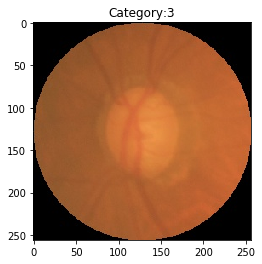

In [9]:
visualize_dataset(train_x, train_y)

As seen in the images above, by comparing the different categories side by side, corneal image in the category with higher number seems to be cloudier than the others.

## Baseline Model

To measure the difficulty of the dataset for classification, I will use a 2 layer convolutional neural net to see how well a naive approach will perform on this dataset

In [6]:
import tensorflow as tf

/home/tingchel/miniconda3/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
tf.__version__

'1.5.0'

In [8]:
def BaseLineModel(features, labels, mode):
    
    input_layer = features['x']
    
    with tf.variable_scope('conv1') as scope:
        conv1 = tf.layers.conv2d(inputs = input_layer,
                                filters = 64,
                                kernel_size = [5, 5],
                                strides = (1,1),
                                padding = 'same',)
        norm1 = tf.layers.batch_normalization(inputs = conv1)
        conv1 = tf.nn.relu(norm1, name=scope.name)
    
    pool1 = tf.layers.max_pooling2d(inputs = conv1,
                                   pool_size = [3,3],
                                   strides = [2,2],
                                   name = 'pool1')
    
    with tf.variable_scope('conv2') as scope:
        conv2 = tf.layers.conv2d(inputs = pool1,
                                filters = 64,
                                kernel_size = [5, 5],
                                strides = (1,1),
                                padding = 'same',)
        norm2 = tf.layers.batch_normalization(inputs = conv2)
        conv2 = tf.nn.relu(norm2, name=scope.name)
    
    
    pool2 = tf.layers.max_pooling2d(inputs = conv2,
                                   pool_size = [3,3],
                                   strides = [2,2],
                                   name = 'pool2')
    
    with tf.variable_scope('local3') as scope:
        pool2_flat = tf.layers.flatten(pool2)
        dense3 = tf.layers.dense(inputs=pool2_flat, units=512, activation=tf.nn.relu)
        dropout3 = tf.layers.dropout(
              inputs=dense3, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN, name=scope.name)
    
    with tf.variable_scope('local4') as scope:
        dense4 = tf.layers.dense(inputs=dropout3, units=256, activation=tf.nn.relu)
        dropout4 = tf.layers.dropout(
              inputs=dense4, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN, name=scope.name)
    
    logits = tf.layers.dense(inputs=dropout4, units=4, name="logits")
    
    
    predictions = {
      "classes": tf.argmax(input=logits, axis=1),
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [9]:
def main(unused_argv):
    
    train_data, train_labels, eval_data, eval_labels = load_data_set('4 categories')

    base_line_classifier = tf.estimator.Estimator(
        model_fn=BaseLineModel, model_dir="base_line/")
    
    tensors_to_log = {"probabilities": "softmax_tensor"}
    
    logging_hook = tf.train.LoggingTensorHook(
      tensors=tensors_to_log, every_n_iter=50)
    
#     writer = tf.summary.FileWriter("/home/dronchego/har-classification/", graph=sess.graph)
    
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=100,
      num_epochs=None,
      shuffle=True)
    
    base_line_classifier.train(
      input_fn=train_input_fn,
      steps=20000,
      hooks=[logging_hook])

    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    eval_results = base_line_classifier.evaluate(input_fn=eval_input_fn)
    print(eval_results)


In [10]:
tf.app.run()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc4eb4c50d0>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'base_line/', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from base_line/model.ckpt-1
INFO:tensorflow:Saving checkpoints for 2 into base_line/model.ckpt.
INFO:tensorflow:probabilities = [[0.26268488 0.2510194  0.23625502 0.25004068]
 [0.27152276 0.23898101 0.23113404 0.2583622 ]
 [0.26281187 0.22015895 0.2799692  0.23705998]
 [0.24932009 0.22542045 0.26831317 0.2569463 ]
 [0.2709183  0.22353035 0.2501

INFO:tensorflow:global_step/sec: 0.793531
INFO:tensorflow:probabilities = [[0.29095852 0.19212481 0.31437862 0.20253804]
 [0.2667639  0.17880164 0.33405784 0.22037664]
 [0.27174127 0.14524773 0.39788583 0.18512514]
 [0.27785906 0.15234876 0.32282913 0.246963  ]
 [0.31375077 0.17424585 0.31557277 0.1964306 ]
 [0.30515337 0.14443186 0.3735506  0.17686418]
 [0.28914654 0.13415231 0.37199667 0.20470443]
 [0.25737163 0.16171409 0.3724292  0.20848508]
 [0.29989335 0.1643376  0.34797874 0.18779026]
 [0.3113303  0.13770947 0.35926554 0.19169472]
 [0.30968657 0.16854224 0.29111892 0.23065223]
 [0.27555114 0.15308022 0.32771325 0.24365535]
 [0.28947818 0.16425128 0.34522593 0.20104462]
 [0.31993368 0.18964006 0.32692543 0.16350082]
 [0.24612956 0.13939022 0.40413246 0.21034782]
 [0.30917326 0.14352354 0.3558853  0.19141784]
 [0.28380933 0.15477559 0.35320926 0.20820588]
 [0.25570667 0.14460135 0.3859949  0.21369702]
 [0.2524171  0.13360076 0.40469527 0.20928693]
 [0.24379353 0.17505428 0.3463286

INFO:tensorflow:global_step/sec: 0.790701
INFO:tensorflow:probabilities = [[0.31987602 0.1881457  0.26898357 0.22299469]
 [0.31074256 0.19328353 0.28083393 0.21513997]
 [0.23864166 0.17780079 0.34693044 0.2366271 ]
 [0.23961806 0.20206594 0.34176934 0.21654671]
 [0.2744655  0.16917601 0.29697096 0.25938758]
 [0.27197438 0.15159407 0.37540054 0.20103101]
 [0.3054531  0.18604301 0.29944718 0.20905676]
 [0.25826177 0.15778959 0.38267276 0.20127583]
 [0.24280003 0.11803091 0.45824042 0.1809286 ]
 [0.28946212 0.17765899 0.30247226 0.23040666]
 [0.2654957  0.16825318 0.34575143 0.22049972]
 [0.263919   0.17691068 0.35098287 0.20818743]
 [0.2523713  0.15363474 0.38197827 0.21201575]
 [0.2709479  0.19963597 0.29518664 0.23422945]
 [0.22495939 0.1651325  0.37778518 0.23212296]
 [0.2798034  0.15654649 0.3336642  0.22998595]
 [0.2656291  0.18362765 0.3369198  0.2138234 ]
 [0.25988403 0.18576345 0.3517652  0.2025873 ]
 [0.27350447 0.16586685 0.35125792 0.2093707 ]
 [0.2683841  0.17844918 0.3206173

INFO:tensorflow:global_step/sec: 0.791223
INFO:tensorflow:probabilities = [[0.3084568  0.14876233 0.32014334 0.22263749]
 [0.3259628  0.15205757 0.35106865 0.17091104]
 [0.26729983 0.17803238 0.34961998 0.20504774]
 [0.27237874 0.16413976 0.3385069  0.22497457]
 [0.4045362  0.12987381 0.31020057 0.15538941]
 [0.25009817 0.20813681 0.3630479  0.17871706]
 [0.24741022 0.1753683  0.34873563 0.22848588]
 [0.3014052  0.15718248 0.32271647 0.2186958 ]
 [0.3206802  0.17911582 0.32981846 0.17038555]
 [0.27457115 0.16275117 0.37616488 0.18651275]
 [0.23253134 0.17330188 0.3900651  0.20410171]
 [0.21984719 0.16270202 0.43384793 0.18360285]
 [0.3083421  0.1639744  0.33843368 0.18924978]
 [0.25114202 0.13016684 0.41818488 0.2005062 ]
 [0.29787076 0.18129906 0.31830546 0.20252478]
 [0.25544056 0.17123097 0.29924083 0.27408764]
 [0.25592703 0.17326976 0.36865106 0.20215213]
 [0.31687865 0.13873927 0.34666413 0.197718  ]
 [0.23374826 0.17273618 0.3709135  0.22260205]
 [0.3274074  0.13321616 0.2835394

INFO:tensorflow:global_step/sec: 0.79314
INFO:tensorflow:probabilities = [[0.2337899  0.17157584 0.3613922  0.23324211]
 [0.330283   0.14231117 0.2965883  0.23081751]
 [0.27034694 0.13652845 0.37237898 0.22074558]
 [0.30082795 0.16085613 0.3268174  0.21149845]
 [0.3902835  0.15195392 0.26386595 0.19389665]
 [0.2216166  0.17560261 0.379048   0.22373283]
 [0.35869935 0.15714784 0.2847412  0.1994116 ]
 [0.27090895 0.17365065 0.35482803 0.2006124 ]
 [0.22228397 0.203345   0.34971172 0.22465932]
 [0.31767964 0.15222223 0.3339435  0.19615467]
 [0.30671212 0.18334801 0.32122377 0.18871611]
 [0.32105294 0.18921617 0.30997285 0.17975806]
 [0.28949156 0.14722204 0.31206796 0.2512184 ]
 [0.36391073 0.19098258 0.27776673 0.16733992]
 [0.29787514 0.13267975 0.29237694 0.27706814]
 [0.28750548 0.17246015 0.37225968 0.16777469]
 [0.2555913  0.15833995 0.33919927 0.24686947]
 [0.27301967 0.1502412  0.37611383 0.20062536]
 [0.24623589 0.16343424 0.36184663 0.22848329]
 [0.30775115 0.21321604 0.26482728

INFO:tensorflow:Saving checkpoints for 477 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.786599
INFO:tensorflow:probabilities = [[0.29130065 0.21434434 0.29419035 0.20016469]
 [0.34857696 0.1187964  0.3164621  0.21616453]
 [0.20292522 0.15995681 0.33461922 0.3024987 ]
 [0.19947462 0.1630048  0.44667837 0.19084224]
 [0.2619542  0.19787118 0.33007398 0.21010062]
 [0.29919308 0.20083228 0.28154033 0.2184343 ]
 [0.26719356 0.15622935 0.3170384  0.25953874]
 [0.25485983 0.13040702 0.2971163  0.31761682]
 [0.46142608 0.15024161 0.21113186 0.17720051]
 [0.5260706  0.12544443 0.19924268 0.14924231]
 [0.24305499 0.15638384 0.44530863 0.15525256]
 [0.2616621  0.13469122 0.37296885 0.23067783]
 [0.22944525 0.14296673 0.43334708 0.19424088]
 [0.23346637 0.18280569 0.4119962  0.17173171]
 [0.2349123  0.1162928  0.43674654 0.21204838]
 [0.32007775 0.17110169 0.30058372 0.20823687]
 [0.2779154  0.196055   0.3084416  0.21758799]
 [0.2756712  0.1416415  0.35925812 0.22342914]
 [0.250235

INFO:tensorflow:global_step/sec: 0.790626
INFO:tensorflow:probabilities = [[0.33455402 0.12749311 0.40710142 0.13085142]
 [0.260608   0.13198535 0.37056422 0.23684244]
 [0.33443198 0.11333355 0.32532546 0.22690894]
 [0.2147389  0.14782605 0.3650303  0.27240467]
 [0.2911193  0.22411783 0.3364718  0.14829107]
 [0.20709608 0.20219937 0.36005205 0.23065251]
 [0.26598388 0.16906606 0.29579026 0.26915976]
 [0.22973497 0.1938873  0.3872867  0.18909113]
 [0.3046117  0.15044355 0.31844205 0.22650269]
 [0.28679365 0.13570465 0.34011292 0.23738877]
 [0.22514944 0.15472825 0.4253018  0.19482058]
 [0.2931055  0.12888718 0.40737408 0.17063321]
 [0.24702536 0.15010183 0.34844476 0.2544281 ]
 [0.24239185 0.14054477 0.40110564 0.21595772]
 [0.23983936 0.18200932 0.3443385  0.23381282]
 [0.22005183 0.17442694 0.45025998 0.15526128]
 [0.2175724  0.14425415 0.38585943 0.252314  ]
 [0.38400102 0.11948813 0.2544033  0.24210756]
 [0.37085244 0.13869448 0.26529354 0.22515951]
 [0.1782279  0.15454946 0.4496735

INFO:tensorflow:global_step/sec: 0.790786
INFO:tensorflow:probabilities = [[0.3582101  0.16071953 0.28334686 0.19772352]
 [0.20371626 0.07589933 0.47784367 0.24254073]
 [0.31747696 0.23436911 0.254899   0.1932549 ]
 [0.36165875 0.1621464  0.3392026  0.13699222]
 [0.24553534 0.09069633 0.44926947 0.21449888]
 [0.17622595 0.13517407 0.49945968 0.18914033]
 [0.236596   0.21123154 0.37135264 0.18081978]
 [0.25545076 0.12528935 0.3898703  0.22938971]
 [0.29034162 0.19829611 0.32961175 0.18175052]
 [0.185717   0.14721327 0.44117683 0.22589289]
 [0.18813819 0.2463592  0.38833585 0.17716677]
 [0.1874138  0.16066954 0.4407648  0.21115178]
 [0.15564235 0.11980649 0.46034598 0.26420516]
 [0.2177246  0.14870636 0.41895297 0.21461603]
 [0.5148863  0.12918662 0.19669451 0.15923257]
 [0.17141269 0.1588765  0.43640715 0.23330362]
 [0.26668948 0.15797567 0.38074178 0.19459301]
 [0.1612178  0.13528995 0.4299631  0.2735291 ]
 [0.3705797  0.17752956 0.274796   0.17709473]
 [0.29448208 0.20620735 0.2901004

INFO:tensorflow:global_step/sec: 0.791611
INFO:tensorflow:probabilities = [[0.1900995  0.15833665 0.4197001  0.23186369]
 [0.21796432 0.16041945 0.4421106  0.17950568]
 [0.40103117 0.15676571 0.36782247 0.07438058]
 [0.25289536 0.1322009  0.4234775  0.19142634]
 [0.1464644  0.15740196 0.4789388  0.2171948 ]
 [0.49949118 0.12271028 0.25575832 0.12204017]
 [0.32770208 0.20077914 0.29514545 0.17637329]
 [0.4825463  0.11691622 0.29338473 0.10715282]
 [0.4170497  0.16299073 0.21808963 0.20186992]
 [0.14048743 0.11154076 0.5480376  0.19993424]
 [0.56768167 0.10001684 0.23101929 0.10128223]
 [0.48166946 0.1057433  0.26231456 0.15027268]
 [0.26643708 0.18704537 0.39184383 0.15467378]
 [0.22973153 0.2170143  0.36435962 0.18889451]
 [0.1763661  0.09133965 0.35076547 0.38152885]
 [0.4356097  0.14735253 0.28174022 0.13529761]
 [0.34293902 0.1668443  0.35613894 0.1340777 ]
 [0.6303013  0.09658045 0.15777925 0.11533903]
 [0.24063486 0.16245599 0.43056497 0.1663441 ]
 [0.24992529 0.07586588 0.2975790

INFO:tensorflow:global_step/sec: 0.792181
INFO:tensorflow:probabilities = [[0.6746604  0.14086846 0.11601904 0.06845205]
 [0.22580983 0.22727656 0.34667775 0.20023584]
 [0.31943303 0.10637198 0.30755332 0.26664168]
 [0.18958157 0.10681014 0.40419647 0.29941174]
 [0.2521782  0.21122092 0.39775088 0.13885002]
 [0.18755575 0.10898398 0.41067564 0.29278463]
 [0.1785814  0.1553297  0.50643253 0.15965638]
 [0.08767159 0.10786552 0.5180059  0.28645697]
 [0.1432376  0.10341201 0.54094386 0.2124065 ]
 [0.6302759  0.09566352 0.18561873 0.08844186]
 [0.4684472  0.14992338 0.2976224  0.0840069 ]
 [0.18944772 0.26378366 0.38470164 0.16206697]
 [0.31781384 0.19814868 0.34483033 0.13920711]
 [0.32038653 0.19341671 0.28723183 0.19896495]
 [0.2505905  0.16050221 0.30326807 0.2856392 ]
 [0.5404401  0.15607584 0.15971774 0.14376628]
 [0.22869094 0.18149586 0.4998577  0.08995554]
 [0.26625422 0.23735857 0.36191186 0.13447535]
 [0.40476686 0.07423327 0.19636318 0.3246367 ]
 [0.43663326 0.14573097 0.2809254

INFO:tensorflow:global_step/sec: 0.78812
INFO:tensorflow:probabilities = [[0.17115167 0.223124   0.43057004 0.17515425]
 [0.24201646 0.22651987 0.37469918 0.15676448]
 [0.24176744 0.11858726 0.38652113 0.2531242 ]
 [0.7548232  0.0822128  0.09864821 0.06431576]
 [0.40456668 0.13905205 0.31919947 0.1371818 ]
 [0.1178531  0.15538803 0.446956   0.27980286]
 [0.25099257 0.22069833 0.33286127 0.19544785]
 [0.43523726 0.06995673 0.25327975 0.24152628]
 [0.17061104 0.18150276 0.44707558 0.2008106 ]
 [0.32998016 0.17149422 0.23057218 0.26795343]
 [0.11957379 0.21806215 0.4087811  0.25358292]
 [0.28477922 0.20410836 0.3281021  0.18301032]
 [0.24372846 0.18850641 0.3575144  0.21025068]
 [0.17666592 0.14355084 0.33249396 0.34728926]
 [0.65489143 0.07469287 0.1493476  0.12106804]
 [0.17522098 0.16197312 0.44304317 0.21976271]
 [0.20136462 0.12893698 0.39672193 0.2729765 ]
 [0.63568395 0.08300491 0.10647931 0.17483184]
 [0.15070304 0.27674875 0.4043752  0.16817309]
 [0.1929078  0.09613945 0.3829589 

INFO:tensorflow:global_step/sec: 0.791198
INFO:tensorflow:probabilities = [[0.37271842 0.12579049 0.29484132 0.20664981]
 [0.39577532 0.198957   0.29709858 0.10816918]
 [0.09411933 0.21954185 0.5306299  0.15570901]
 [0.17685665 0.20654652 0.3728308  0.24376598]
 [0.15514666 0.12840585 0.4592081  0.25723946]
 [0.1409442  0.18037719 0.47746634 0.20121235]
 [0.15566088 0.29584777 0.41640204 0.13208929]
 [0.2745325  0.07998918 0.20365298 0.4418253 ]
 [0.12047446 0.16952655 0.47536972 0.23462924]
 [0.2476305  0.1928125  0.40488    0.15467697]
 [0.37550765 0.23585977 0.24479009 0.14384241]
 [0.65547425 0.0562172  0.13970156 0.14860697]
 [0.28385523 0.13497734 0.19967172 0.38149562]
 [0.0683531  0.12898222 0.47006053 0.3326041 ]
 [0.17744869 0.02980406 0.2368946  0.55585265]
 [0.64265496 0.13597637 0.09571773 0.12565097]
 [0.34999964 0.1589901  0.32904363 0.16196667]
 [0.60443866 0.19799644 0.14741494 0.05014988]
 [0.08917123 0.13406873 0.58005863 0.19670142]
 [0.15507138 0.12258338 0.4272126

INFO:tensorflow:global_step/sec: 0.792549
INFO:tensorflow:probabilities = [[0.38293186 0.17760055 0.26618722 0.17328043]
 [0.21557754 0.1470164  0.31488097 0.32252505]
 [0.22921836 0.11410675 0.22813849 0.42853642]
 [0.37652168 0.13783605 0.30527773 0.1803646 ]
 [0.07969388 0.11055136 0.5927031  0.2170517 ]
 [0.79549176 0.08871415 0.06212024 0.05367387]
 [0.18413639 0.22911483 0.38251886 0.20422998]
 [0.06349672 0.13268507 0.45142147 0.35239673]
 [0.6828307  0.06987296 0.11548603 0.13181022]
 [0.18542172 0.17689703 0.3793512  0.25833005]
 [0.10001178 0.08154013 0.39512303 0.42332503]
 [0.0496492  0.1569204  0.52256787 0.27086255]
 [0.12842591 0.3208738  0.34271657 0.20798372]
 [0.18955497 0.09708213 0.3452322  0.36813068]
 [0.19747649 0.20120011 0.3735771  0.2277463 ]
 [0.29099515 0.12741043 0.1960798  0.3855146 ]
 [0.1169384  0.15232213 0.46924016 0.26149926]
 [0.2484399  0.17379159 0.26078162 0.31698686]
 [0.36687407 0.19948515 0.28156185 0.15207885]
 [0.700307   0.12881215 0.1353337

INFO:tensorflow:global_step/sec: 0.791232
INFO:tensorflow:probabilities = [[0.18545744 0.08623233 0.43546534 0.29284492]
 [0.37561747 0.1836717  0.31528145 0.12542942]
 [0.45697212 0.11551546 0.21958695 0.20792541]
 [0.15650156 0.16232805 0.4538154  0.22735502]
 [0.10636666 0.07502799 0.3068978  0.5117076 ]
 [0.5068512  0.20117141 0.16241413 0.12956333]
 [0.08148822 0.06752493 0.26620167 0.5847852 ]
 [0.20743291 0.11535491 0.3195866  0.35762554]
 [0.39081377 0.1971356  0.2683236  0.14372706]
 [0.851467   0.07898587 0.04757088 0.02197621]
 [0.14711563 0.08247135 0.48172346 0.28868958]
 [0.13627249 0.23714861 0.42689252 0.19968641]
 [0.635517   0.11059615 0.17591894 0.07796784]
 [0.12979117 0.15667124 0.47138718 0.24215047]
 [0.11640843 0.10353761 0.39432853 0.38572535]
 [0.22081959 0.14178765 0.33616835 0.30122444]
 [0.32606673 0.14207701 0.40763032 0.12422594]
 [0.07091708 0.12318577 0.41570258 0.39019454]
 [0.1798182  0.1791198  0.45080397 0.19025804]
 [0.09059606 0.09139729 0.4202935

INFO:tensorflow:global_step/sec: 0.790344
INFO:tensorflow:probabilities = [[0.04730633 0.10784785 0.58978295 0.25506294]
 [0.05663579 0.15879051 0.5621206  0.22245313]
 [0.04687888 0.08591851 0.40706864 0.46013394]
 [0.13064191 0.11031671 0.34823248 0.41080883]
 [0.11426216 0.3941005  0.3399168  0.15172055]
 [0.33354133 0.21412125 0.23503648 0.21730092]
 [0.28946325 0.21703032 0.26686826 0.22663812]
 [0.07294457 0.21571517 0.49502918 0.21631113]
 [0.06859162 0.19315606 0.5419888  0.1962635 ]
 [0.450511   0.24384016 0.22197455 0.08367427]
 [0.46092397 0.09846153 0.27394268 0.16667181]
 [0.3559494  0.19931301 0.34098637 0.10375125]
 [0.11983278 0.21784712 0.33764267 0.32467735]
 [0.28685316 0.16532023 0.36673287 0.18109377]
 [0.07276367 0.16869302 0.5213913  0.23715204]
 [0.3889239  0.09620835 0.3078209  0.2070469 ]
 [0.06881697 0.13194473 0.5208331  0.27840525]
 [0.0549092  0.10770465 0.43578538 0.40160075]
 [0.14959273 0.08020637 0.1946716  0.57552934]
 [0.07011594 0.23550771 0.5435881

INFO:tensorflow:global_step/sec: 0.787513
INFO:tensorflow:probabilities = [[0.03228506 0.06480818 0.37080482 0.5321019 ]
 [0.48434576 0.2084425  0.21322533 0.09398644]
 [0.03009863 0.10245943 0.5128249  0.354617  ]
 [0.28952423 0.19146353 0.24130493 0.27770728]
 [0.12446364 0.08464362 0.2831731  0.50771964]
 [0.8535247  0.08261337 0.04076556 0.02309642]
 [0.12329346 0.15483102 0.55172426 0.17015117]
 [0.4587688  0.13717608 0.31005475 0.09400033]
 [0.92426044 0.02939187 0.02449575 0.02185198]
 [0.65889704 0.0601889  0.18459271 0.09632132]
 [0.9735994  0.01217755 0.00749145 0.00673158]
 [0.06044823 0.13572171 0.48319143 0.32063866]
 [0.4643148  0.1951921  0.2529312  0.08756191]
 [0.07604053 0.1400896  0.48999158 0.2938783 ]
 [0.03185834 0.07678151 0.4335827  0.45777747]
 [0.6557354  0.12507895 0.12031025 0.09887546]
 [0.12476218 0.2911326  0.45346397 0.1306412 ]
 [0.17583765 0.17699635 0.36278123 0.28438476]
 [0.13869241 0.27011365 0.43497276 0.1562212 ]
 [0.86094713 0.04893345 0.0481261

INFO:tensorflow:global_step/sec: 0.791682
INFO:tensorflow:probabilities = [[0.40538087 0.21943182 0.24683112 0.1283562 ]
 [0.9667915  0.01778041 0.01218895 0.0032392 ]
 [0.12369763 0.2243838  0.50535226 0.14656627]
 [0.09317104 0.2184333  0.4795679  0.20882782]
 [0.032463   0.08133735 0.45940328 0.4267964 ]
 [0.05579944 0.17045778 0.5605677  0.21317513]
 [0.8035574  0.11097993 0.04099252 0.04447016]
 [0.2967974  0.19864324 0.32480896 0.1797504 ]
 [0.08295655 0.2121251  0.42209062 0.2828277 ]
 [0.8770026  0.0547041  0.05164877 0.01664444]
 [0.02621486 0.07984833 0.6061202  0.28781652]
 [0.6626862  0.15720123 0.08639716 0.09371544]
 [0.05849934 0.23534672 0.59693974 0.10921422]
 [0.49168497 0.17852929 0.15633984 0.17344593]
 [0.7801135  0.15539044 0.0482299  0.01626619]
 [0.78076667 0.08379602 0.06182849 0.07360876]
 [0.8593984  0.07423506 0.05023275 0.01613374]
 [0.31975743 0.24413407 0.3690726  0.06703597]
 [0.09621163 0.31772327 0.39117447 0.19489059]
 [0.13534999 0.29269832 0.4176900

INFO:tensorflow:global_step/sec: 0.792403
INFO:tensorflow:probabilities = [[0.0480081  0.0983284  0.5359686  0.31769493]
 [0.02762842 0.1137937  0.5348386  0.32373935]
 [0.40420443 0.2702526  0.25191882 0.07362419]
 [0.0296774  0.06982681 0.38258922 0.5179066 ]
 [0.79196095 0.08278449 0.10349993 0.02175459]
 [0.2531351  0.29127976 0.42065603 0.03492919]
 [0.96407586 0.01850405 0.01083074 0.00658941]
 [0.0373584  0.11552978 0.59445846 0.2526534 ]
 [0.08010455 0.20243528 0.46836665 0.24909352]
 [0.04172438 0.05636936 0.6637737  0.23813263]
 [0.0135726  0.06848308 0.53982544 0.37811884]
 [0.0963015  0.25165397 0.56423914 0.08780539]
 [0.03517945 0.0634708  0.46111193 0.44023785]
 [0.47638667 0.24596262 0.15688443 0.12076628]
 [0.13940921 0.35233977 0.4248003  0.08345074]
 [0.09163018 0.1550977  0.5732971  0.17997502]
 [0.06189304 0.17835893 0.47887573 0.28087237]
 [0.11196265 0.23339255 0.5408587  0.11378608]
 [0.4425639  0.29887825 0.17928466 0.07927322]
 [0.15187041 0.2232013  0.4220731

INFO:tensorflow:global_step/sec: 0.793083
INFO:tensorflow:probabilities = [[0.08541771 0.1016031  0.2849944  0.52798486]
 [0.25028765 0.23743208 0.302104   0.21017624]
 [0.57799333 0.1709927  0.18288572 0.06812819]
 [0.11060371 0.17757966 0.5099319  0.20188469]
 [0.5899755  0.1112456  0.23467195 0.06410693]
 [0.01528691 0.01336883 0.2507468  0.72059745]
 [0.06710576 0.1475484  0.5318642  0.25348157]
 [0.10806204 0.1595465  0.5577254  0.17466605]
 [0.3370044  0.25806248 0.29426217 0.11067093]
 [0.01626679 0.05649257 0.70072514 0.22651546]
 [0.944451   0.04383507 0.00924632 0.00246764]
 [0.02434761 0.08747508 0.54742175 0.34075558]
 [0.9851171  0.01163629 0.0023213  0.00092534]
 [0.08255173 0.30025813 0.498401   0.11878911]
 [0.95623314 0.02593133 0.01023174 0.00760374]
 [0.15013058 0.27753237 0.44783008 0.12450691]
 [0.05212957 0.09718848 0.43367425 0.41700765]
 [0.2770065  0.34522772 0.28433216 0.09343365]
 [0.07584386 0.1954496  0.4445449  0.28416157]
 [0.03065028 0.16285408 0.6726862

INFO:tensorflow:global_step/sec: 0.794498
INFO:tensorflow:probabilities = [[0.12362768 0.28129065 0.5233849  0.07169679]
 [0.94341975 0.03615285 0.01582295 0.0046045 ]
 [0.051152   0.18341747 0.49930662 0.26612395]
 [0.09054966 0.14298554 0.39833978 0.36812505]
 [0.0233533  0.14546083 0.667921   0.16326495]
 [0.7486395  0.13976257 0.08548303 0.02611486]
 [0.11572005 0.20474704 0.42222914 0.25730377]
 [0.02501522 0.10268559 0.44787675 0.42442238]
 [0.9225597  0.04933937 0.01969231 0.00840864]
 [0.7280194  0.14882532 0.08951435 0.03364089]
 [0.9763945  0.01611554 0.00583002 0.00166   ]
 [0.14802773 0.16551377 0.41172674 0.27473179]
 [0.9277645  0.02077843 0.03461028 0.01684683]
 [0.08379639 0.11282526 0.7145938  0.08878453]
 [0.17424233 0.08170884 0.37360975 0.37043905]
 [0.9575934  0.02669723 0.01042977 0.00527963]
 [0.9777354  0.01426676 0.00654905 0.00144869]
 [0.955317   0.01910416 0.01520448 0.0103744 ]
 [0.53070974 0.16815692 0.17335814 0.12777518]
 [0.35160846 0.19209807 0.3567426

INFO:tensorflow:global_step/sec: 0.789365
INFO:tensorflow:probabilities = [[0.23120457 0.24428217 0.29660782 0.22790545]
 [0.03445157 0.0510174  0.3729048  0.5416262 ]
 [0.09379289 0.3766714  0.4028053  0.1267304 ]
 [0.06479981 0.06334862 0.26259825 0.60925335]
 [0.0109303  0.03698678 0.6339608  0.31812215]
 [0.3081437  0.30452642 0.27447996 0.11284991]
 [0.8131028  0.07659606 0.06855793 0.04174325]
 [0.05558521 0.17216127 0.64366305 0.12859048]
 [0.02395546 0.04840166 0.2670802  0.66056263]
 [0.03779109 0.03742625 0.47476372 0.45001897]
 [0.00711619 0.02543264 0.39937747 0.5680737 ]
 [0.4338257  0.13450754 0.27118886 0.16047795]
 [0.05698944 0.11013681 0.5379157  0.29495806]
 [0.7291202  0.07610028 0.16442432 0.03035527]
 [0.02497976 0.17135064 0.59978175 0.20388785]
 [0.92473245 0.01870078 0.04192954 0.0146372 ]
 [0.9356897  0.03265932 0.0258912  0.0057598 ]
 [0.70052385 0.1844273  0.11289015 0.00215867]
 [0.03963868 0.08531215 0.6798449  0.19520418]
 [0.8599755  0.06638468 0.0668003

INFO:tensorflow:global_step/sec: 0.792948
INFO:tensorflow:probabilities = [[0.00912257 0.01514856 0.4694799  0.50624895]
 [0.18204041 0.22453935 0.3874501  0.20597012]
 [0.00280099 0.05488121 0.6396772  0.30264053]
 [0.1542855  0.19202715 0.3710354  0.2826519 ]
 [0.03197103 0.02311208 0.26850238 0.67641443]
 [0.9914129  0.00812812 0.00041654 0.00004251]
 [0.0168948  0.03552812 0.15575743 0.7918197 ]
 [0.96409136 0.02684169 0.00682407 0.00224284]
 [0.51378506 0.17911038 0.264266   0.04283854]
 [0.13140544 0.3071964  0.49150613 0.06989195]
 [0.11140941 0.24084155 0.514376   0.13337307]
 [0.06758226 0.37002432 0.49687997 0.06551336]
 [0.02140497 0.15254931 0.4430485  0.38299718]
 [0.73466545 0.11742157 0.11761691 0.03029604]
 [0.6949706  0.20342007 0.05678577 0.0448235 ]
 [0.9393218  0.01919226 0.01925594 0.02223005]
 [0.85855496 0.11965663 0.01846218 0.00332624]
 [0.02405882 0.16853912 0.45536795 0.35203415]
 [0.09138546 0.13295312 0.32840884 0.44725263]
 [0.47450957 0.20489489 0.2163492

INFO:tensorflow:global_step/sec: 0.792339
INFO:tensorflow:probabilities = [[0.03953942 0.24201316 0.5891559  0.12929153]
 [0.03763995 0.26399183 0.3231965  0.37517172]
 [0.06661756 0.35494813 0.49617052 0.08226386]
 [0.8814146  0.04988613 0.05038683 0.01831238]
 [0.05591827 0.17519006 0.38283676 0.3860549 ]
 [0.91358376 0.05527448 0.02804755 0.00309426]
 [0.04993995 0.37743962 0.4959063  0.0767142 ]
 [0.81047475 0.13608162 0.04896239 0.00448135]
 [0.9306245  0.05854412 0.00837072 0.00246075]
 [0.39777753 0.47440717 0.10183518 0.02598009]
 [0.4539576  0.28052342 0.17787535 0.08764359]
 [0.910684   0.06253437 0.02334682 0.00343483]
 [0.01961458 0.0163597  0.4533281  0.51069754]
 [0.06640387 0.42413226 0.40403    0.10543392]
 [0.14065403 0.43896693 0.3463863  0.07399277]
 [0.6996664  0.18674928 0.10183883 0.01174549]
 [0.3039001  0.47490448 0.16998726 0.05120819]
 [0.09499542 0.19587003 0.57508314 0.13405135]
 [0.02524603 0.10806687 0.47234148 0.39434555]
 [0.13168879 0.1353527  0.5856758

INFO:tensorflow:global_step/sec: 0.793871
INFO:tensorflow:probabilities = [[0.0039478  0.01019121 0.35574865 0.63011235]
 [0.47424603 0.29971096 0.20474948 0.02129352]
 [0.04341507 0.03827    0.39088264 0.52743226]
 [0.10276905 0.26994997 0.5183995  0.10888154]
 [0.9553248  0.02939515 0.01161411 0.00366584]
 [0.00250129 0.02826101 0.8417366  0.12750109]
 [0.9609462  0.01881558 0.01317185 0.00706636]
 [0.06146723 0.30254886 0.4996868  0.13629714]
 [0.06714312 0.35775492 0.5361649  0.03893713]
 [0.19392236 0.3217423  0.41189492 0.07244042]
 [0.9967367  0.002987   0.0001495  0.00012678]
 [0.96727264 0.01660784 0.01321456 0.00290503]
 [0.0268056  0.05005155 0.38420734 0.53893554]
 [0.02845378 0.10944246 0.59814405 0.26395974]
 [0.03662788 0.31921715 0.51203877 0.13211621]
 [0.0820693  0.03381192 0.68029314 0.20382565]
 [0.00963519 0.05231248 0.6128967  0.3251557 ]
 [0.94380236 0.03349332 0.01694933 0.00575494]
 [0.21910703 0.30271968 0.3130611  0.16511224]
 [0.72658265 0.15515094 0.0914683

INFO:tensorflow:Saving checkpoints for 2379 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.789423
INFO:tensorflow:probabilities = [[0.11307576 0.33751017 0.4466297  0.10278443]
 [0.03905056 0.13793576 0.30111438 0.5218993 ]
 [0.01063839 0.08562734 0.37773487 0.5259994 ]
 [0.6800148  0.10035562 0.20211087 0.01751875]
 [0.01122541 0.11580694 0.4241998  0.44876784]
 [0.42583215 0.41885245 0.13225515 0.02306026]
 [0.5522147  0.34621832 0.08479809 0.01676891]
 [0.00675921 0.01111817 0.20799094 0.7741317 ]
 [0.03796581 0.3376171  0.49011394 0.13430308]
 [0.44359064 0.32718155 0.1733927  0.05583511]
 [0.03661236 0.11618524 0.67699164 0.17021076]
 [0.08288955 0.05216202 0.5484105  0.31653798]
 [0.11089417 0.11495704 0.66751325 0.10663553]
 [0.01201584 0.02203855 0.6934064  0.27253923]
 [0.67424357 0.04951788 0.25658855 0.01965   ]
 [0.00732438 0.0387073  0.4572297  0.4967386 ]
 [0.06241532 0.15974417 0.41655946 0.36128104]
 [0.01746956 0.09145312 0.4116863  0.47939104]
 [0.83636

INFO:tensorflow:global_step/sec: 0.790848
INFO:tensorflow:probabilities = [[0.60162634 0.14404571 0.21901496 0.03531305]
 [0.65412796 0.21399093 0.09819601 0.03368515]
 [0.10951525 0.5363988  0.2598285  0.09425738]
 [0.09478505 0.14017856 0.6449673  0.12006906]
 [0.31961635 0.2491348  0.3185511  0.11269777]
 [0.00962503 0.05045824 0.83791214 0.10200457]
 [0.98992515 0.0059839  0.003631   0.00045997]
 [0.9983557  0.00150958 0.00012591 0.0000088 ]
 [0.2246473  0.47309604 0.27620268 0.02605394]
 [0.00511901 0.02287761 0.8852277  0.08677573]
 [0.02475348 0.22471051 0.5869964  0.16353965]
 [0.11025601 0.32325724 0.5160885  0.05039826]
 [0.05829747 0.1103038  0.349919   0.48147976]
 [0.09627952 0.2106856  0.5426727  0.15036224]
 [0.0349223  0.0700215  0.72657615 0.16848007]
 [0.02170983 0.20714597 0.60352504 0.1676192 ]
 [0.16844252 0.49884698 0.26419008 0.06852039]
 [0.5590622  0.15525317 0.22471815 0.0609665 ]
 [0.03167534 0.37723088 0.50661516 0.08447861]
 [0.9567896  0.01296871 0.0233800

INFO:tensorflow:global_step/sec: 0.795156
INFO:tensorflow:probabilities = [[0.17457262 0.29970282 0.44628596 0.07943855]
 [0.9988397  0.00079562 0.00033275 0.00003191]
 [0.9784138  0.01502566 0.00632898 0.00023154]
 [0.8177607  0.1290861  0.05059949 0.00255371]
 [0.01426022 0.07504168 0.3013372  0.60936093]
 [0.07493591 0.3574058  0.4049415  0.16271676]
 [0.02239699 0.29612464 0.55132484 0.1301535 ]
 [0.01705907 0.08841211 0.61149037 0.28303847]
 [0.9884857  0.00735401 0.00205621 0.00210402]
 [0.01941716 0.1437358  0.362293   0.4745541 ]
 [0.0834944  0.2632655  0.45706573 0.19617432]
 [0.10162774 0.18020256 0.4410969  0.27707276]
 [0.03537758 0.16933504 0.65653384 0.1387536 ]
 [0.02169431 0.27341625 0.37842536 0.32646403]
 [0.9050473  0.06410805 0.02836395 0.00248071]
 [0.0461726  0.08137248 0.43004075 0.44241416]
 [0.01292047 0.01262215 0.3414746  0.6329828 ]
 [0.8559192  0.04282391 0.07597496 0.02528195]
 [0.18262021 0.3182158  0.44788957 0.05127437]
 [0.00764077 0.08192354 0.4945415

INFO:tensorflow:global_step/sec: 0.79462
INFO:tensorflow:probabilities = [[0.01131173 0.05553395 0.69667554 0.23647879]
 [0.3660144  0.23123324 0.31977525 0.08297712]
 [0.01532819 0.21934792 0.3557421  0.40958184]
 [0.9782025  0.01839884 0.00313986 0.00025876]
 [0.0238196  0.0967756  0.62038875 0.25901607]
 [0.13796048 0.3361279  0.43518713 0.09072448]
 [0.00890341 0.22261642 0.6568407  0.11163954]
 [0.02556493 0.1358503  0.27287367 0.56571114]
 [0.02197198 0.18317732 0.66222304 0.13262764]
 [0.01267418 0.08495868 0.56472325 0.33764386]
 [0.9127808  0.01415078 0.06193504 0.01113333]
 [0.01021793 0.00471945 0.14109547 0.84396714]
 [0.62211573 0.05915024 0.30455434 0.01417967]
 [0.03370271 0.05632157 0.5101235  0.39985225]
 [0.1863879  0.22378804 0.31632042 0.2735037 ]
 [0.04542887 0.07946974 0.7873652  0.08773616]
 [0.00175515 0.06299481 0.5323123  0.4029378 ]
 [0.30226126 0.5213909  0.14611128 0.03023653]
 [0.45471886 0.2190228  0.28198805 0.04427032]
 [0.63607097 0.31893426 0.04120914

INFO:tensorflow:global_step/sec: 0.793082
INFO:tensorflow:probabilities = [[0.1851608  0.11390714 0.17371017 0.5272219 ]
 [0.04830851 0.3723883  0.5524771  0.02682614]
 [0.01946092 0.27914143 0.5333979  0.16799976]
 [0.03003822 0.1519076  0.5477146  0.27033964]
 [0.0191345  0.18957537 0.59077764 0.20051242]
 [0.14680567 0.3374744  0.38590264 0.1298173 ]
 [0.0448951  0.08714502 0.45049307 0.41746676]
 [0.89623404 0.04255826 0.05907685 0.00213084]
 [0.9702417  0.02633356 0.00284305 0.00058175]
 [0.01834987 0.03030593 0.68219036 0.26915377]
 [0.9346755  0.0133512  0.04068005 0.01129319]
 [0.03393959 0.01223503 0.4392362  0.51458913]
 [0.06693935 0.32237637 0.5369695  0.07371483]
 [0.00443987 0.00610584 0.15599903 0.83345526]
 [0.5343892  0.36922374 0.08460462 0.01178242]
 [0.05816972 0.22043411 0.4514964  0.26989982]
 [0.0061161  0.05082157 0.36282694 0.58023536]
 [0.1315321  0.151673   0.45448825 0.2623067 ]
 [0.03807884 0.18833727 0.60391074 0.16967307]
 [0.02284988 0.13002887 0.5930326

INFO:tensorflow:Saving checkpoints for 2855 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.790114
INFO:tensorflow:probabilities = [[0.01589319 0.07218022 0.66839075 0.24353585]
 [0.285984   0.27469277 0.33350527 0.10581791]
 [0.81854886 0.11524227 0.06130477 0.00490412]
 [0.00470034 0.00360015 0.14797746 0.843722  ]
 [0.04381696 0.17638472 0.6752298  0.10456854]
 [0.9816047  0.01146703 0.00618481 0.00074347]
 [0.05695316 0.21741107 0.49462193 0.23101386]
 [0.0103084  0.04274993 0.48261237 0.46432927]
 [0.00729995 0.03281675 0.4676072  0.49227613]
 [0.70822656 0.11956293 0.16269568 0.00951487]
 [0.09185419 0.15259705 0.5765917  0.17895706]
 [0.02624151 0.09606779 0.43624303 0.4414477 ]
 [0.02261212 0.0658149  0.5405934  0.37097964]
 [0.02118045 0.12448018 0.47299564 0.38134372]
 [0.1797363  0.5040403  0.28693372 0.0292897 ]
 [0.04661531 0.3500718  0.54221845 0.06109441]
 [0.01104032 0.0929539  0.31019932 0.5858065 ]
 [0.406479   0.3790315  0.19060053 0.02388893]
 [0.25254

INFO:tensorflow:global_step/sec: 0.792148
INFO:tensorflow:probabilities = [[0.00525456 0.09634069 0.59908783 0.29931697]
 [0.97644955 0.01127489 0.01207878 0.00019672]
 [0.20545287 0.65187716 0.13270104 0.00996901]
 [0.11656877 0.30489284 0.46203676 0.11650158]
 [0.8657378  0.12499995 0.00922981 0.0000324 ]
 [0.99918085 0.0007064  0.00010706 0.00000556]
 [0.97787774 0.01284606 0.00870696 0.0005693 ]
 [0.03084336 0.1444125  0.7210178  0.10372638]
 [0.5091962  0.2779738  0.1966906  0.01613937]
 [0.585946   0.23461701 0.1514994  0.02793757]
 [0.34423164 0.16221918 0.34590572 0.14764342]
 [0.05782695 0.11962425 0.73142725 0.09112156]
 [0.06855078 0.29616427 0.43647125 0.19881368]
 [0.8954888  0.09356019 0.00842355 0.00252741]
 [0.07067216 0.1313572  0.67913896 0.11883172]
 [0.99706984 0.00256635 0.00028623 0.00007762]
 [0.06607231 0.2867945  0.3635429  0.28359023]
 [0.0766058  0.17379698 0.5521972  0.19740005]
 [0.11003769 0.21568695 0.46546838 0.208807  ]
 [0.21520294 0.36310774 0.3917937

INFO:tensorflow:global_step/sec: 0.793141
INFO:tensorflow:probabilities = [[0.07871111 0.19013335 0.38354844 0.34760714]
 [0.00099394 0.00777725 0.20296216 0.7882666 ]
 [0.02243154 0.16853294 0.6870827  0.12195273]
 [0.02245339 0.02394669 0.294368   0.6592319 ]
 [0.02994794 0.05117577 0.5351695  0.3837068 ]
 [0.00764046 0.03899731 0.6324162  0.3209461 ]
 [0.00976248 0.03724795 0.3267375  0.6262521 ]
 [0.08499221 0.27063647 0.4938133  0.15055802]
 [0.0646356  0.0304135  0.8631849  0.04176589]
 [0.02710469 0.2466922  0.62014717 0.10605597]
 [0.04862415 0.41693512 0.40811613 0.12632464]
 [0.06745242 0.23563373 0.5899846  0.10692926]
 [0.08457103 0.3264223  0.44927594 0.13973074]
 [0.06441549 0.5237757  0.3565328  0.05527598]
 [0.16132185 0.48542467 0.33606553 0.01718791]
 [0.37765566 0.20407124 0.3309832  0.08728994]
 [0.002322   0.0262041  0.891406   0.0800679 ]
 [0.98056257 0.01187237 0.00718802 0.00037696]
 [0.20020674 0.45788634 0.28914902 0.05275792]
 [0.03977219 0.25419673 0.6380613

INFO:tensorflow:global_step/sec: 0.792918
INFO:tensorflow:probabilities = [[0.08125878 0.36910033 0.53609216 0.01354868]
 [0.9160052  0.04607967 0.03133418 0.006581  ]
 [0.9857329  0.00819447 0.00595149 0.00012107]
 [0.02571025 0.14243408 0.60596085 0.22589482]
 [0.06432998 0.0920247  0.5672877  0.27635762]
 [0.00897264 0.0947328  0.41957486 0.47671977]
 [0.00839752 0.09747028 0.82901347 0.06511883]
 [0.00615619 0.09448779 0.8209516  0.07840437]
 [0.0607207  0.13174897 0.6060721  0.20145814]
 [0.0368241  0.32960764 0.60920286 0.02436536]
 [0.13885447 0.08841668 0.4667575  0.3059713 ]
 [0.05409764 0.32449657 0.5799622  0.04144363]
 [0.07759941 0.15890811 0.7042123  0.05928018]
 [0.02069559 0.32881495 0.5043957  0.14609374]
 [0.8646066  0.09440196 0.03540819 0.00558325]
 [0.04391725 0.36751312 0.49502292 0.09354662]
 [0.572233   0.3892012  0.03823345 0.00033232]
 [0.37325794 0.34847683 0.23777607 0.04048919]
 [0.08170231 0.12764063 0.5851568  0.20550032]
 [0.5061947  0.34106866 0.1296510

INFO:tensorflow:global_step/sec: 0.793476
INFO:tensorflow:probabilities = [[0.11666591 0.2705282  0.5197058  0.09310017]
 [0.30499187 0.3368061  0.35162446 0.00657751]
 [0.02420914 0.05985615 0.42132914 0.4946056 ]
 [0.00575436 0.01375123 0.34020916 0.64028525]
 [0.04148708 0.14936908 0.22124316 0.58790064]
 [0.05243313 0.330789   0.50701386 0.10976398]
 [0.0054221  0.04875617 0.28486753 0.6609542 ]
 [0.006769   0.00629235 0.14211759 0.84482104]
 [0.03248475 0.31186453 0.57446015 0.08119065]
 [0.26679385 0.52560735 0.17795525 0.02964354]
 [0.02357018 0.13252999 0.43645006 0.40744978]
 [0.08369799 0.12917125 0.6668058  0.12032492]
 [0.01637793 0.11254662 0.3928925  0.4781829 ]
 [0.10917323 0.18412898 0.40999904 0.29669872]
 [0.9908608  0.00877227 0.0002564  0.00011043]
 [0.07109938 0.19717199 0.40509477 0.3266339 ]
 [0.01779335 0.0663251  0.45884767 0.45703384]
 [0.02587985 0.18587056 0.5582065  0.23004311]
 [0.05199797 0.36257714 0.49390495 0.09152   ]
 [0.02248128 0.15176924 0.70956  

INFO:tensorflow:global_step/sec: 0.788536
INFO:tensorflow:probabilities = [[0.99777645 0.00185514 0.00020599 0.00016235]
 [0.07824603 0.570497   0.30834678 0.04291023]
 [0.00813635 0.07807455 0.7459056  0.1678835 ]
 [0.02144081 0.02267441 0.16909912 0.78678566]
 [0.01227498 0.09446613 0.829031   0.06422795]
 [0.1175718  0.3157256  0.4934725  0.07323004]
 [0.03794387 0.22366573 0.6354599  0.10293051]
 [0.9619477  0.02896195 0.00796903 0.00112131]
 [0.07665192 0.31835166 0.5337906  0.07120588]
 [0.00611066 0.10515326 0.4704686  0.4182674 ]
 [0.02877669 0.00654201 0.3569894  0.6076918 ]
 [0.01162911 0.1620462  0.60029185 0.22603288]
 [0.03417467 0.05673794 0.538302   0.3707854 ]
 [0.02183279 0.0555381  0.38236013 0.540269  ]
 [0.03407654 0.07740439 0.4284007  0.46011844]
 [0.10974434 0.17912786 0.24594986 0.46517795]
 [0.03125777 0.30719498 0.47222465 0.18932264]
 [0.02339377 0.01684976 0.40771362 0.55204284]
 [0.13022758 0.22836423 0.49415657 0.14725167]
 [0.19580749 0.07199479 0.5553906

INFO:tensorflow:global_step/sec: 0.79205
INFO:tensorflow:probabilities = [[0.02718026 0.04948947 0.13733295 0.7859973 ]
 [0.01947756 0.14373077 0.6213902  0.21540143]
 [0.9546086  0.03288008 0.01059921 0.00191207]
 [0.05078186 0.27502984 0.61102134 0.06316692]
 [0.10455221 0.382308   0.45764604 0.05549378]
 [0.01259257 0.2244781  0.6759876  0.08694176]
 [0.14602666 0.45886713 0.39156717 0.00353904]
 [0.01879992 0.02626691 0.18433653 0.7705966 ]
 [0.07435957 0.1613406  0.6656627  0.09863719]
 [0.05352562 0.49494892 0.4411775  0.010348  ]
 [0.94143873 0.04836636 0.00902468 0.00117023]
 [0.02557811 0.08097862 0.40377364 0.48966965]
 [0.08486122 0.20880802 0.36509842 0.34123236]
 [0.68711275 0.13821259 0.17019846 0.00447616]
 [0.31122884 0.14105058 0.52022773 0.02749287]
 [0.21372409 0.22399351 0.49647003 0.06581242]
 [0.9868528  0.00721671 0.00540658 0.00052388]
 [0.93476677 0.03365072 0.02196109 0.00962145]
 [0.99653554 0.00263634 0.0007381  0.00008997]
 [0.04833818 0.30746907 0.5702821 

INFO:tensorflow:global_step/sec: 0.79323
INFO:tensorflow:probabilities = [[0.01100245 0.09239217 0.61081594 0.28578946]
 [0.06526918 0.2859343  0.485875   0.16292155]
 [0.93490803 0.05906341 0.00577135 0.00025714]
 [0.03164082 0.31316513 0.56209075 0.09310322]
 [0.05965494 0.30256915 0.4815367  0.15623929]
 [0.03391308 0.10614061 0.6236413  0.23630504]
 [0.22567606 0.26234153 0.48274434 0.02923813]
 [0.8798864  0.04249935 0.06027129 0.01734293]
 [0.00362144 0.14031766 0.73387474 0.12218616]
 [0.25536522 0.50279367 0.2333755  0.00846559]
 [0.8212181  0.03750972 0.11357084 0.02770129]
 [0.02707871 0.19371597 0.63315237 0.14605293]
 [0.02686146 0.51052994 0.4151267  0.04748188]
 [0.00190786 0.0004696  0.0500869  0.94753563]
 [0.6984429  0.04189586 0.2405006  0.01916065]
 [0.00993367 0.14696735 0.65812594 0.18497302]
 [0.10519166 0.5829994  0.29327413 0.0185348 ]
 [0.02641362 0.1433054  0.56563383 0.2646472 ]
 [0.02192326 0.08019985 0.47985262 0.41802433]
 [0.26491895 0.20039    0.31620744

INFO:tensorflow:global_step/sec: 0.792835
INFO:tensorflow:probabilities = [[0.9492356  0.03043765 0.0180904  0.00223636]
 [0.11384519 0.11624202 0.5941723  0.1757405 ]
 [0.98112535 0.01706221 0.0017492  0.00006317]
 [0.01950018 0.3554046  0.5810359  0.0440593 ]
 [0.97403604 0.01391117 0.01081315 0.00123966]
 [0.139852   0.12973748 0.6463602  0.08405034]
 [0.02303194 0.14229621 0.44537237 0.38929957]
 [0.15033579 0.2174206  0.4476252  0.18461841]
 [0.02002919 0.24006912 0.49877205 0.24112959]
 [0.7723509  0.16460855 0.05854274 0.00449784]
 [0.00278599 0.05194406 0.42678532 0.51848465]
 [0.02475664 0.5119854  0.4476089  0.01564906]
 [0.01378793 0.05475208 0.4898915  0.44156852]
 [0.15673001 0.4223759  0.40844476 0.01244937]
 [0.9434765  0.02942685 0.02485084 0.00224581]
 [0.01246944 0.06299407 0.51231843 0.41221797]
 [0.02552588 0.03555736 0.10627566 0.8326411 ]
 [0.4728197  0.2262998  0.26630005 0.03458042]
 [0.1527047  0.26374713 0.5063436  0.07720459]
 [0.99708396 0.00144226 0.0014696

INFO:tensorflow:global_step/sec: 0.793397
INFO:tensorflow:probabilities = [[0.06358524 0.40426028 0.47117063 0.06098387]
 [0.49887726 0.44363564 0.05628657 0.0012005 ]
 [0.6458544  0.30667958 0.04629423 0.00117181]
 [0.09554765 0.15329812 0.34274206 0.4084122 ]
 [0.01753121 0.02076561 0.252522   0.7091812 ]
 [0.09154272 0.20657691 0.40905628 0.29282403]
 [0.9851805  0.01076848 0.00401917 0.00003185]
 [0.9098677  0.08213565 0.00660511 0.00139161]
 [0.00559339 0.02689111 0.51972896 0.44778654]
 [0.00634298 0.01213827 0.43562487 0.5458939 ]
 [0.02653944 0.13320152 0.30469835 0.53556067]
 [0.01512962 0.34112877 0.62224543 0.02149617]
 [0.97391    0.02318264 0.00273749 0.00016991]
 [0.996384   0.00061459 0.00143971 0.00156171]
 [0.96862954 0.01570973 0.01461491 0.00104579]
 [0.03123307 0.07151437 0.5200284  0.37722418]
 [0.00160403 0.00616132 0.02671871 0.9655159 ]
 [0.02450941 0.07156152 0.86983204 0.03409707]
 [0.00649373 0.04191836 0.49609175 0.45549613]
 [0.02604491 0.3055849  0.6016280

INFO:tensorflow:global_step/sec: 0.789306
INFO:tensorflow:probabilities = [[0.02605519 0.48986682 0.42625928 0.05781869]
 [0.04230567 0.01925318 0.52505434 0.4133868 ]
 [0.01617621 0.2846729  0.6484716  0.05067933]
 [0.00029189 0.02418781 0.7379153  0.23760508]
 [0.00242056 0.04775469 0.30556422 0.6442605 ]
 [0.00289033 0.06701623 0.7016029  0.22849056]
 [0.07617357 0.43752065 0.34514523 0.14116056]
 [0.00501071 0.0369631  0.42801815 0.530008  ]
 [0.00473926 0.01630973 0.32582197 0.6531291 ]
 [0.996783   0.00297174 0.00024385 0.00000144]
 [0.02493098 0.40422824 0.49480474 0.07603601]
 [0.08118775 0.05047264 0.21830137 0.65003824]
 [0.0195233  0.01944965 0.1739169  0.7871101 ]
 [0.18862711 0.2623901  0.44798607 0.1009967 ]
 [0.10390832 0.16127445 0.58727205 0.14754519]
 [0.12165938 0.26677087 0.5473175  0.06425225]
 [0.51050997 0.11582424 0.34568405 0.02798171]
 [0.00908226 0.04561156 0.57888246 0.3664237 ]
 [0.36401337 0.3452598  0.25968963 0.03103718]
 [0.9925296  0.00704034 0.0004160

INFO:tensorflow:global_step/sec: 0.795819
INFO:tensorflow:probabilities = [[0.03250578 0.13109477 0.7581554  0.07824404]
 [0.07719295 0.5715254  0.33566704 0.01561456]
 [0.03586621 0.3685689  0.44688267 0.14868225]
 [0.13396385 0.39801493 0.40751415 0.06050704]
 [0.9979938  0.0006276  0.00111935 0.00025928]
 [0.24308597 0.39807737 0.3236871  0.03514951]
 [0.4431737  0.15337059 0.2840805  0.11937524]
 [0.0051939  0.01230799 0.07628384 0.9062143 ]
 [0.16413985 0.49358162 0.2927388  0.04953969]
 [0.0104615  0.0237714  0.29219976 0.6735673 ]
 [0.87507516 0.10208604 0.01992795 0.00291083]
 [0.00721904 0.06696857 0.7182593  0.20755316]
 [0.00664692 0.06008185 0.46318302 0.47008818]
 [0.1839965  0.08862609 0.6561071  0.07127024]
 [0.8567796  0.01888365 0.03842173 0.08591504]
 [0.03206718 0.09428328 0.57686687 0.29678264]
 [0.0436354  0.07607333 0.4602088  0.4200825 ]
 [0.0302078  0.3025512  0.53214675 0.1350942 ]
 [0.09787156 0.34412006 0.5157344  0.04227406]
 [0.00049799 0.01699419 0.4227924

INFO:tensorflow:global_step/sec: 0.791487
INFO:tensorflow:probabilities = [[0.04456216 0.49745888 0.44257936 0.01539962]
 [0.14847104 0.02010691 0.37822407 0.45319802]
 [0.05926971 0.09475783 0.76030797 0.08566447]
 [0.3337525  0.5298293  0.12163829 0.01477988]
 [0.06620225 0.19209853 0.5298942  0.21180512]
 [0.9494189  0.03649426 0.01243584 0.0016509 ]
 [0.01741801 0.11168014 0.39773822 0.47316357]
 [0.8990579  0.07825576 0.02229081 0.00039545]
 [0.02356569 0.40686738 0.54394203 0.02562487]
 [0.00943955 0.03346823 0.64943564 0.3076566 ]
 [0.99762076 0.00087825 0.00132414 0.00017678]
 [0.01480873 0.10988966 0.60739297 0.26790857]
 [0.00266243 0.0120525  0.4768946  0.5083905 ]
 [0.00172846 0.0462833  0.44667888 0.5053094 ]
 [0.8928867  0.04384427 0.06051293 0.00275609]
 [0.01274836 0.16134888 0.7023073  0.12359555]
 [0.01469806 0.23019874 0.6131999  0.14190325]
 [0.03949495 0.04826161 0.58323973 0.3290037 ]
 [0.8740351  0.08277294 0.03936516 0.00382676]
 [0.99397767 0.00365134 0.0019306

INFO:tensorflow:global_step/sec: 0.792008
INFO:tensorflow:probabilities = [[0.99815935 0.00135909 0.00038179 0.0000998 ]
 [0.00995773 0.0389291  0.7164841  0.23462899]
 [0.00578622 0.09606173 0.4752019  0.42295015]
 [0.1215167  0.3696837  0.42844126 0.08035838]
 [0.22756366 0.5613097  0.17809188 0.03303483]
 [0.05981321 0.1686252  0.689212   0.08234954]
 [0.00365436 0.02451443 0.25269347 0.7191377 ]
 [0.9956722  0.0036567  0.00058214 0.00008893]
 [0.33722076 0.20821278 0.2806018  0.17396462]
 [0.14267418 0.1264582  0.58846045 0.14240716]
 [0.98824114 0.00343131 0.00759953 0.000728  ]
 [0.01679152 0.3283038  0.6348192  0.02008548]
 [0.04382893 0.29474577 0.57946444 0.08196083]
 [0.01203457 0.10494077 0.6810143  0.20201036]
 [0.18219163 0.07770532 0.42069057 0.31941244]
 [0.01077811 0.11519306 0.6141914  0.25983748]
 [0.0038128  0.02016864 0.4892049  0.4868137 ]
 [0.9978119  0.00150702 0.00055659 0.00012451]
 [0.15251422 0.18140852 0.29655218 0.36952502]
 [0.01708323 0.10963354 0.3658749

INFO:tensorflow:Saving checkpoints for 4283 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.789062
INFO:tensorflow:probabilities = [[0.12224153 0.54071355 0.26742294 0.06962199]
 [0.03192589 0.05740456 0.49969828 0.4109712 ]
 [0.95448565 0.03856564 0.00686498 0.00008372]
 [0.02698713 0.3559444  0.5414747  0.07559375]
 [0.00101675 0.03739483 0.36535707 0.59623134]
 [0.01869626 0.18511797 0.4262877  0.36989802]
 [0.01091743 0.2248036  0.6400902  0.12418881]
 [0.01095797 0.18893054 0.60720694 0.19290452]
 [0.8592189  0.08142272 0.05536358 0.00399486]
 [0.06732789 0.15632956 0.6467591  0.12958342]
 [0.0226371  0.20083116 0.44853526 0.32799643]
 [0.03112662 0.05921215 0.7868875  0.12277371]
 [0.01460103 0.2413153  0.70531094 0.03877275]
 [0.00856414 0.09544185 0.2605876  0.63540643]
 [0.06646874 0.46675903 0.4048909  0.06188141]
 [0.83313626 0.08638298 0.07872356 0.00175722]
 [0.2701351  0.22887109 0.45546973 0.04552419]
 [0.39816704 0.22736609 0.33664504 0.03782185]
 [0.00565

INFO:tensorflow:global_step/sec: 0.792742
INFO:tensorflow:probabilities = [[0.08143734 0.5054139  0.35973823 0.0534106 ]
 [0.19341765 0.1812356  0.36885288 0.2564939 ]
 [0.9025835  0.0874341  0.009916   0.00006652]
 [0.01744441 0.08601437 0.51747364 0.3790676 ]
 [0.01226294 0.17130482 0.6870376  0.1293947 ]
 [0.16196643 0.18108751 0.63488054 0.02206548]
 [0.00179396 0.02189263 0.19628504 0.7800284 ]
 [0.01393658 0.1244864  0.5566347  0.30494234]
 [0.02658472 0.44130147 0.43241283 0.09970103]
 [0.00573718 0.00582709 0.06041094 0.92802477]
 [0.01576858 0.10764008 0.5462321  0.33035925]
 [0.03236782 0.19319555 0.2718898  0.5025469 ]
 [0.0383429  0.35754377 0.49645665 0.10765678]
 [0.99119896 0.00608733 0.00234721 0.00036647]
 [0.01953525 0.12856361 0.50520396 0.3466972 ]
 [0.9337026  0.03589161 0.02142704 0.00897874]
 [0.00134813 0.05497337 0.8228049  0.12087366]
 [0.01596366 0.12988022 0.56566817 0.28848797]
 [0.00658199 0.0068198  0.3801271  0.6064711 ]
 [0.04964541 0.29693568 0.4528604

INFO:tensorflow:global_step/sec: 0.791497
INFO:tensorflow:probabilities = [[0.06937931 0.2989121  0.6024122  0.02929636]
 [0.20627822 0.587196   0.20493121 0.00159453]
 [0.274523   0.2644639  0.17413516 0.28687793]
 [0.14099367 0.32873154 0.4867799  0.0434949 ]
 [0.4318473  0.13229394 0.4293191  0.00653959]
 [0.01049218 0.04457644 0.36114872 0.58378273]
 [0.00284032 0.03134625 0.35838252 0.6074309 ]
 [0.24199437 0.6415526  0.1139235  0.00252949]
 [0.31651208 0.08977608 0.24026221 0.35344958]
 [0.00772859 0.07168083 0.48902678 0.43156374]
 [0.02836742 0.26320255 0.6597879  0.04864218]
 [0.11952086 0.2508201  0.55832404 0.07133499]
 [0.15941048 0.554497   0.20102014 0.08507235]
 [0.98074037 0.0155794  0.00333562 0.00034456]
 [0.0110691  0.06878398 0.5422101  0.37793687]
 [0.80781084 0.14050612 0.04942774 0.00225531]
 [0.9985708  0.00134764 0.00004415 0.00003744]
 [0.25235748 0.4160104  0.30168462 0.02994746]
 [0.05879227 0.34292793 0.5483665  0.04991327]
 [0.16480303 0.05089687 0.6738140

INFO:tensorflow:global_step/sec: 0.791155
INFO:tensorflow:probabilities = [[0.01699504 0.08163223 0.7937762  0.10759652]
 [0.10135282 0.04266663 0.48201448 0.37396607]
 [0.99385333 0.00228927 0.00213293 0.00172441]
 [0.02369149 0.412433   0.5310603  0.03281524]
 [0.08933725 0.33073243 0.36200848 0.21792185]
 [0.96430326 0.01817092 0.01014895 0.00737695]
 [0.00170011 0.17493491 0.81474954 0.00861541]
 [0.01342911 0.18748018 0.5319852  0.26710552]
 [0.02248822 0.31181863 0.6352637  0.03042946]
 [0.00799119 0.04881749 0.26565617 0.6775351 ]
 [0.9927792  0.00706449 0.00014812 0.00000823]
 [0.00391808 0.29265735 0.64251727 0.06090725]
 [0.00201558 0.01415849 0.18363325 0.8001926 ]
 [0.01743069 0.24918967 0.7195825  0.01379712]
 [0.25920236 0.3761605  0.3352273  0.02940977]
 [0.05360075 0.45570576 0.40172476 0.08896876]
 [0.99710244 0.00181139 0.0010388  0.00004739]
 [0.01009205 0.16372156 0.71216494 0.11402138]
 [0.9897153  0.00681507 0.00319794 0.0002717 ]
 [0.01577161 0.26556036 0.6320038

INFO:tensorflow:global_step/sec: 0.79178
INFO:tensorflow:probabilities = [[0.04694955 0.3496767  0.42973906 0.17363465]
 [0.00903871 0.00023247 0.14129978 0.8494291 ]
 [0.9998796  0.00008454 0.00003557 0.00000033]
 [0.98512626 0.00835264 0.00602761 0.00049349]
 [0.04252955 0.21478906 0.51196873 0.23071265]
 [0.95058066 0.01175182 0.03411662 0.00355092]
 [0.02717772 0.03411918 0.33567855 0.6030246 ]
 [0.06222734 0.10925583 0.38576722 0.44274962]
 [0.48672986 0.1549901  0.32026106 0.03801899]
 [0.30421016 0.5798012  0.11283348 0.00315515]
 [0.00412305 0.01616956 0.31422734 0.66548   ]
 [0.1583263  0.07996675 0.57188153 0.18982545]
 [0.0166662  0.0709103  0.27247524 0.63994825]
 [0.06302725 0.22115196 0.49858892 0.21723188]
 [0.99905044 0.00076746 0.00012836 0.00005375]
 [0.08416911 0.19397175 0.64064175 0.08121735]
 [0.08776063 0.15065046 0.4644466  0.29714236]
 [0.15586019 0.38438535 0.45764235 0.00211209]
 [0.9995782  0.00040607 0.00001553 0.00000017]
 [0.01303374 0.13450499 0.47635567

INFO:tensorflow:Saving checkpoints for 4758 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.78796
INFO:tensorflow:probabilities = [[0.00232628 0.00084114 0.11193112 0.8849015 ]
 [0.00884062 0.11631947 0.6416897  0.23315024]
 [0.05663262 0.06419501 0.6498899  0.22928248]
 [0.0943803  0.72954595 0.16687988 0.00919393]
 [0.07421175 0.11058744 0.2228394  0.5923614 ]
 [0.02412873 0.34568426 0.39303353 0.23715347]
 [0.9812122  0.01624638 0.00240522 0.00013615]
 [0.04473459 0.0272193  0.5872363  0.34080985]
 [0.9501801  0.02956324 0.01619628 0.00406046]
 [0.25182727 0.6412706  0.10134693 0.00555523]
 [0.00630272 0.01498481 0.12193514 0.8567773 ]
 [0.22756699 0.2107131  0.5187102  0.04300969]
 [0.01635666 0.05627725 0.3773472  0.5500189 ]
 [0.0542536  0.13927722 0.47080708 0.3356621 ]
 [0.00920908 0.06911818 0.5816341  0.3400386 ]
 [0.01265257 0.10667622 0.4375741  0.44309714]
 [0.26843342 0.29523906 0.30174848 0.13457903]
 [0.5530123  0.2614019  0.16376069 0.02182516]
 [0.003735

INFO:tensorflow:global_step/sec: 0.790826
INFO:tensorflow:probabilities = [[0.06599044 0.23836488 0.56722367 0.12842101]
 [0.96645576 0.00934717 0.02248407 0.00171302]
 [0.98897564 0.008998   0.00199007 0.00003637]
 [0.9522829  0.02912636 0.01780277 0.00078792]
 [0.8329188  0.07171629 0.09040003 0.00496488]
 [0.2543063  0.05573055 0.32591185 0.36405128]
 [0.00156963 0.01918759 0.5140786  0.46516418]
 [0.08334337 0.20445785 0.6022739  0.10992487]
 [0.07663164 0.19165187 0.48124686 0.25046957]
 [0.0391256  0.31037024 0.54673797 0.1037662 ]
 [0.00830394 0.31282896 0.6576699  0.02119716]
 [0.986344   0.01138527 0.00195691 0.0003138 ]
 [0.04569419 0.10521236 0.3074254  0.541668  ]
 [0.03426534 0.11225954 0.67728376 0.17619129]
 [0.92253083 0.06091558 0.01534048 0.00121301]
 [0.04881122 0.31172577 0.41152775 0.22793527]
 [0.07505012 0.57070845 0.33104068 0.02320075]
 [0.05920145 0.35606176 0.51889324 0.06584359]
 [0.00632915 0.02996962 0.92625386 0.03744737]
 [0.00818765 0.09287565 0.7180236

INFO:tensorflow:global_step/sec: 0.792597
INFO:tensorflow:probabilities = [[0.02180577 0.09847196 0.49737227 0.38235   ]
 [0.99545974 0.00042836 0.00039451 0.00371728]
 [0.0141519  0.29735672 0.64990556 0.03858579]
 [0.07189346 0.5123758  0.40677908 0.00895164]
 [0.00281054 0.04342252 0.5192789  0.434488  ]
 [0.00999479 0.12479249 0.65136504 0.21384768]
 [0.00751165 0.03798801 0.5368367  0.4176636 ]
 [0.15711784 0.35360354 0.4454379  0.04384074]
 [0.7026204  0.15564704 0.14112833 0.00060428]
 [0.19159874 0.45003396 0.33167666 0.02669056]
 [0.6179682  0.16542786 0.1856762  0.03092773]
 [0.01451651 0.10936774 0.5180155  0.3581003 ]
 [0.03213028 0.17710419 0.593255   0.19751056]
 [0.08058758 0.44571444 0.4613935  0.01230446]
 [0.98719484 0.01012096 0.00264112 0.00004312]
 [0.89353865 0.09858087 0.00774413 0.0001363 ]
 [0.00333172 0.00144509 0.06231719 0.9329059 ]
 [0.01287456 0.06920072 0.29490665 0.6230181 ]
 [0.09111561 0.37597236 0.4881189  0.04479313]
 [0.03107028 0.33907673 0.4628456

INFO:tensorflow:global_step/sec: 0.792743
INFO:tensorflow:probabilities = [[0.00219096 0.02498153 0.45809558 0.5147319 ]
 [0.0454827  0.3149323  0.6161291  0.02345597]
 [0.00661095 0.35013965 0.6354676  0.00778182]
 [0.03552874 0.28147957 0.6090625  0.07392923]
 [0.02848257 0.06575455 0.7704197  0.13534313]
 [0.00327904 0.05030518 0.3016586  0.64475715]
 [0.00024    0.00478833 0.13466568 0.86030596]
 [0.96354485 0.02324399 0.01223192 0.00097927]
 [0.00412194 0.12958683 0.8569102  0.00938095]
 [0.04236567 0.02351648 0.54816306 0.38595474]
 [0.02298853 0.08054354 0.66514236 0.23132557]
 [0.01604215 0.2024066  0.5639052  0.21764612]
 [0.01058279 0.06581564 0.601806   0.32179558]
 [0.0097771  0.251292   0.5262842  0.21264671]
 [0.00332236 0.08823683 0.44676295 0.46167785]
 [0.00724601 0.04994239 0.29979008 0.6430215 ]
 [0.01509673 0.06808149 0.3972785  0.5195433 ]
 [0.8068531  0.17757162 0.01544194 0.0001333 ]
 [0.00120347 0.00033666 0.16880503 0.8296549 ]
 [0.9998198  0.00014795 0.0000297

INFO:tensorflow:global_step/sec: 0.793022
INFO:tensorflow:probabilities = [[0.03414996 0.16845486 0.458105   0.33929026]
 [0.04204093 0.42582592 0.49957764 0.03255554]
 [0.00234659 0.0329419  0.20227695 0.7624346 ]
 [0.14042886 0.3599602  0.44569758 0.05391346]
 [0.91751975 0.02767171 0.0384379  0.01637067]
 [0.00980158 0.09117182 0.5778168  0.3212098 ]
 [0.9922875  0.0070886  0.00054005 0.00008383]
 [0.08643868 0.33267343 0.38928062 0.19160727]
 [0.99586606 0.00275165 0.00127024 0.00011215]
 [0.00108089 0.00517152 0.1717118  0.8220358 ]
 [0.8031584  0.04416563 0.08083615 0.07183984]
 [0.03436888 0.00280869 0.10730862 0.8555138 ]
 [0.01169109 0.04553286 0.9218967  0.02087948]
 [0.05465322 0.5929083  0.34324086 0.0091976 ]
 [0.38389543 0.21401836 0.27505118 0.12703502]
 [0.0088459  0.09872212 0.4008205  0.4916115 ]
 [0.99728346 0.00191979 0.00078938 0.00000742]
 [0.0046571  0.14082827 0.60277903 0.25173563]
 [0.90284014 0.03127526 0.05822371 0.00766085]
 [0.17046504 0.20951717 0.6063586

INFO:tensorflow:global_step/sec: 0.790333
INFO:tensorflow:probabilities = [[0.01371408 0.15831725 0.5827521  0.24521652]
 [0.57474416 0.4069968  0.01790258 0.00035648]
 [0.00238333 0.01010861 0.30514228 0.6823657 ]
 [0.01696124 0.19708312 0.5997428  0.18621288]
 [0.14235139 0.8383287  0.01910805 0.0002119 ]
 [0.00603113 0.00803208 0.2652874  0.72064936]
 [0.8922185  0.07968592 0.02783881 0.00025681]
 [0.01600035 0.0513394  0.31399533 0.6186649 ]
 [0.01168216 0.00514363 0.08636336 0.89681095]
 [0.978959   0.02005712 0.00096879 0.00001504]
 [0.99229443 0.00059379 0.00459846 0.0025133 ]
 [0.00541089 0.07243482 0.59307307 0.32908124]
 [0.2865659  0.6144301  0.08579658 0.01320739]
 [0.9994029  0.00054087 0.0000548  0.00000143]
 [0.47218558 0.29969847 0.21247117 0.01564477]
 [0.99827623 0.00132289 0.00038362 0.00001725]
 [0.86102    0.10668244 0.0316063  0.00069123]
 [0.0218644  0.40333745 0.553986   0.02081214]
 [0.996172   0.00339964 0.00042478 0.00000357]
 [0.03427225 0.22084849 0.6208026

INFO:tensorflow:global_step/sec: 0.794355
INFO:tensorflow:probabilities = [[0.00122552 0.00033891 0.06653226 0.93190336]
 [0.05584108 0.5963251  0.32900017 0.01883367]
 [0.00038029 0.00102283 0.15446924 0.84412766]
 [0.02592824 0.3066486  0.5182595  0.1491636 ]
 [0.63337135 0.24665545 0.11129669 0.00867645]
 [0.98072237 0.01288463 0.00616854 0.00022437]
 [0.00731334 0.38821647 0.5854879  0.01898229]
 [0.01940722 0.24182953 0.6522212  0.08654204]
 [0.9900845  0.00691299 0.00287301 0.00012943]
 [0.00358609 0.08861682 0.8510436  0.05675354]
 [0.01653357 0.05996245 0.46045655 0.46304744]
 [0.07531599 0.35919157 0.5241135  0.041379  ]
 [0.00933204 0.1130884  0.35122043 0.52635914]
 [0.00395225 0.00998695 0.5312365  0.45482433]
 [0.01706952 0.46707082 0.46936733 0.04649239]
 [0.86607236 0.09398542 0.03802648 0.00191579]
 [0.95824313 0.03665935 0.00313192 0.00196551]
 [0.45551082 0.3399388  0.2019876  0.00256275]
 [0.9966229  0.00106795 0.00226231 0.00004687]
 [0.9856398  0.01404576 0.0003140

INFO:tensorflow:global_step/sec: 0.795083
INFO:tensorflow:probabilities = [[0.1824582  0.3203989  0.44001687 0.057126  ]
 [0.00853104 0.22963974 0.602585   0.1592442 ]
 [0.97679955 0.0138026  0.00819719 0.00120063]
 [0.05130365 0.5889858  0.29903933 0.06067117]
 [0.00914394 0.38519517 0.58924025 0.01642065]
 [0.00062    0.00189838 0.25206396 0.74541765]
 [0.02291606 0.58660674 0.38146248 0.00901464]
 [0.00128249 0.04555456 0.46254978 0.49061316]
 [0.9518854  0.03370894 0.01308655 0.00131915]
 [0.01824578 0.4610114  0.48603565 0.03470717]
 [0.01269599 0.07999822 0.67943454 0.22787124]
 [0.9231087  0.06099211 0.01561057 0.00028873]
 [0.0016312  0.00075173 0.13030088 0.86731625]
 [0.16792442 0.41890463 0.3852152  0.02795574]
 [0.0115602  0.15497549 0.8109169  0.02254745]
 [0.9993814  0.00059986 0.00001854 0.00000011]
 [0.00775631 0.00302602 0.436565   0.55265266]
 [0.01551381 0.54384345 0.42826146 0.01238119]
 [0.10656669 0.49220195 0.335116   0.06611536]
 [0.00515028 0.09996902 0.832091 

INFO:tensorflow:global_step/sec: 0.793503
INFO:tensorflow:probabilities = [[0.05327643 0.08956835 0.85437244 0.00278271]
 [0.01258879 0.5470309  0.4294778  0.01090247]
 [0.00264281 0.00098442 0.5177446  0.47862816]
 [0.00464394 0.07624474 0.28028467 0.63882667]
 [0.01007547 0.03854133 0.3214063  0.6299769 ]
 [0.05472736 0.04151796 0.47715533 0.4265994 ]
 [0.00477765 0.03417772 0.3133277  0.64771694]
 [0.04228939 0.20961607 0.59720594 0.15088867]
 [0.00704999 0.30331263 0.6651278  0.02450954]
 [0.03224546 0.13283828 0.4717082  0.36320797]
 [0.00541818 0.00073686 0.16163309 0.83221185]
 [0.02415367 0.07460039 0.2611688  0.6400771 ]
 [0.9518298  0.01173871 0.03630858 0.00012293]
 [0.9918859  0.00358852 0.00402228 0.00050326]
 [0.9958346  0.00393912 0.00022261 0.00000367]
 [0.9505468  0.04487267 0.00443074 0.00014973]
 [0.2183202  0.12495875 0.35273594 0.30398512]
 [0.0047487  0.0586798  0.610983   0.32558846]
 [0.62813103 0.18169971 0.1563185  0.03385074]
 [0.00047067 0.00224191 0.2118033

INFO:tensorflow:global_step/sec: 0.793204
INFO:tensorflow:probabilities = [[0.00585217 0.04487482 0.31487438 0.63439864]
 [0.3636593  0.440842   0.19486852 0.00063021]
 [0.00607033 0.01524971 0.65367407 0.3250059 ]
 [0.7894968  0.03742671 0.10186369 0.07121284]
 [0.03584699 0.11157423 0.80460715 0.04797163]
 [0.10136105 0.35862628 0.5156157  0.02439698]
 [0.9864244  0.00799779 0.00537804 0.00019977]
 [0.21978873 0.42154208 0.33592123 0.02274801]
 [0.00692521 0.00601039 0.21848907 0.7685754 ]
 [0.01963523 0.23737682 0.68151283 0.06147514]
 [0.00116873 0.00553548 0.09493612 0.8983597 ]
 [0.00873538 0.1839745  0.67345667 0.1338335 ]
 [0.01337939 0.36599538 0.6118991  0.00872616]
 [0.0080141  0.04903805 0.6054537  0.3374941 ]
 [0.01707085 0.39494538 0.57764    0.01034378]
 [0.02168399 0.62513876 0.34759519 0.00558209]
 [0.05365467 0.43730447 0.49652317 0.01251766]
 [0.99272585 0.00075874 0.00625441 0.00026106]
 [0.40428677 0.46903303 0.11749885 0.00918136]
 [0.01038495 0.15370308 0.7783983

INFO:tensorflow:global_step/sec: 0.790376
INFO:tensorflow:probabilities = [[0.00174694 0.12214037 0.6804972  0.1956155 ]
 [0.00152343 0.00480747 0.52083606 0.47283304]
 [0.00505904 0.01679179 0.6843451  0.29380405]
 [0.01861236 0.01639737 0.49886614 0.46612412]
 [0.30455324 0.47994724 0.19706436 0.01843514]
 [0.99304914 0.00348878 0.00289298 0.0005691 ]
 [0.01434013 0.2791875  0.56731147 0.13916086]
 [0.00053887 0.00557225 0.18802312 0.8058658 ]
 [0.00086384 0.06915253 0.8702804  0.05970322]
 [0.99939287 0.0002126  0.00013146 0.00026302]
 [0.00781675 0.00568634 0.30034623 0.6861506 ]
 [0.010792   0.12891358 0.71614325 0.14415115]
 [0.21072243 0.44208166 0.34309876 0.00409712]
 [0.02514363 0.05677332 0.6875367  0.23054639]
 [0.03380761 0.5044749  0.37413436 0.08758313]
 [0.00603097 0.12681442 0.7079411  0.15921354]
 [0.00113371 0.01378686 0.31445202 0.6706275 ]
 [0.9809306  0.01007658 0.00839511 0.0005976 ]
 [0.9601418  0.02199914 0.01752576 0.00033337]
 [0.00245323 0.27504486 0.6829969

INFO:tensorflow:global_step/sec: 0.794057
INFO:tensorflow:probabilities = [[0.99750084 0.00229578 0.00020247 0.00000083]
 [0.01572255 0.35539284 0.60819656 0.02068804]
 [0.21704441 0.02229484 0.39861414 0.36204663]
 [0.00870551 0.11285648 0.7981695  0.08026852]
 [0.03836266 0.12733197 0.47410294 0.3602024 ]
 [0.9806145  0.01329222 0.00579997 0.00029341]
 [0.00577535 0.16381332 0.6147087  0.21570255]
 [0.0771886  0.27068037 0.57872206 0.07340898]
 [0.00324099 0.0174919  0.4888418  0.49042523]
 [0.9899554  0.00946945 0.00047238 0.00010277]
 [0.04574011 0.19849385 0.6373498  0.11841633]
 [0.00060016 0.00334024 0.05685489 0.9392047 ]
 [0.13161485 0.5077963  0.24025297 0.12033591]
 [0.99997544 0.00001567 0.00000688 0.00000204]
 [0.0248139  0.08049619 0.44179684 0.45289305]
 [0.26834524 0.4712209  0.2581572  0.00227668]
 [0.08078973 0.43943074 0.44785276 0.03192671]
 [0.0112603  0.3091274  0.67090863 0.00870365]
 [0.00283849 0.14127083 0.6603122  0.19557855]
 [0.9999976  0.00000224 0.0000001

INFO:tensorflow:global_step/sec: 0.793999
INFO:tensorflow:probabilities = [[0.9999124  0.00008414 0.0000031  0.00000037]
 [0.01646125 0.2875867  0.5004993  0.19545278]
 [0.5205108  0.44528696 0.03243966 0.00176257]
 [0.3420196  0.58932596 0.06753109 0.00112332]
 [0.00898166 0.02289731 0.76735675 0.20076431]
 [0.00956658 0.0720143  0.46361685 0.45480222]
 [0.37885842 0.29171377 0.24840777 0.08102006]
 [0.0138229  0.20069927 0.6529907  0.1324871 ]
 [0.00128591 0.00412679 0.25716278 0.7374246 ]
 [0.45690084 0.2610553  0.2688284  0.01321552]
 [0.00301381 0.04689106 0.42556134 0.52453375]
 [0.01340647 0.03560771 0.5780102  0.37297562]
 [0.02940556 0.77137786 0.19387972 0.00533674]
 [0.7164682  0.24976055 0.03365263 0.00011858]
 [0.9805966  0.01045784 0.0089235  0.00002203]
 [0.00157746 0.02337551 0.46242347 0.51262355]
 [0.998228   0.00138817 0.00037821 0.00000558]
 [0.00885274 0.08654352 0.47100073 0.433603  ]
 [0.6862139  0.26816943 0.04561065 0.00000599]
 [0.05604969 0.12836249 0.4165112

INFO:tensorflow:global_step/sec: 0.792266
INFO:tensorflow:probabilities = [[0.1970097  0.0290073  0.32158738 0.45239565]
 [0.6644038  0.27110302 0.06086411 0.0036291 ]
 [0.9074687  0.02936497 0.05952052 0.00364574]
 [0.22651203 0.5663246  0.20134975 0.00581362]
 [0.36443457 0.3969533  0.23011507 0.00849705]
 [0.05432884 0.01741816 0.1532424  0.77501065]
 [0.5015268  0.15320104 0.30567414 0.03959808]
 [0.10516188 0.5580427  0.32006738 0.01672804]
 [0.063275   0.34822476 0.5694416  0.01905862]
 [0.0170741  0.61003774 0.35636678 0.01652138]
 [0.00950364 0.65102047 0.3372651  0.00221078]
 [0.01020457 0.24658658 0.6328181  0.11039068]
 [0.00174378 0.00397143 0.38168338 0.6126014 ]
 [0.99659365 0.00235884 0.00074095 0.00030658]
 [0.17651463 0.3001951  0.43874142 0.08454889]
 [0.45127255 0.38338402 0.14966732 0.01567612]
 [0.2420403  0.5636243  0.19386603 0.00046936]
 [0.99902594 0.00049268 0.00015047 0.0003309 ]
 [0.63669306 0.15192327 0.16181003 0.0495737 ]
 [0.01198746 0.482504   0.3954011

INFO:tensorflow:Saving checkpoints for 6186 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.786552
INFO:tensorflow:probabilities = [[0.02009916 0.142346   0.789378   0.04817689]
 [0.0072557  0.07556103 0.86867434 0.04850897]
 [0.99971324 0.00010535 0.00017066 0.00001071]
 [0.4407216  0.45834595 0.09271155 0.00822093]
 [0.00994051 0.4686384  0.5159759  0.00544517]
 [0.1846046  0.3804447  0.3957926  0.03915806]
 [0.9905591  0.00934914 0.0000912  0.00000061]
 [0.9401202  0.05553868 0.00433316 0.00000786]
 [0.0014586  0.00285645 0.54906976 0.44661516]
 [0.00056179 0.00368577 0.18215647 0.81359595]
 [0.9822097  0.01136309 0.00285196 0.0035753 ]
 [0.99956125 0.00040073 0.00003732 0.00000067]
 [0.04606111 0.00067521 0.3844054  0.56885827]
 [0.9937171  0.00372661 0.00253576 0.00002055]
 [0.09259239 0.6812574  0.22189997 0.00425022]
 [0.28976    0.21256696 0.40644643 0.09122667]
 [0.8558107  0.04316633 0.09046072 0.01056219]
 [0.00627542 0.08249863 0.75959384 0.15163216]
 [0.03013

INFO:tensorflow:global_step/sec: 0.792712
INFO:tensorflow:probabilities = [[0.07619197 0.56064487 0.28788108 0.07528214]
 [0.00246323 0.00501642 0.76841444 0.22410591]
 [0.00247346 0.06679395 0.16655497 0.7641776 ]
 [0.2928572  0.39612556 0.30099523 0.010022  ]
 [0.9622656  0.0264957  0.01092857 0.00031017]
 [0.07625353 0.32066113 0.45282042 0.15026489]
 [0.0026792  0.06558279 0.6665971  0.26514092]
 [0.63657445 0.25950518 0.1023981  0.00152229]
 [0.04329694 0.29947555 0.45282948 0.20439804]
 [0.986839   0.00658635 0.0065727  0.00000202]
 [0.00531254 0.13421367 0.7088676  0.15160626]
 [0.01625216 0.20853329 0.67409664 0.10111793]
 [0.99987674 0.00001976 0.00008797 0.0000155 ]
 [0.00074581 0.01488363 0.22743672 0.75693387]
 [0.2234794  0.21796115 0.44097638 0.11758304]
 [0.03378041 0.00998049 0.84806836 0.10817071]
 [0.6973977  0.10321327 0.1591681  0.04022092]
 [0.05659876 0.13803965 0.54244596 0.26291558]
 [0.9999404  0.00005737 0.00000219 0.00000009]
 [0.43041158 0.34511703 0.1997311

INFO:tensorflow:global_step/sec: 0.792556
INFO:tensorflow:probabilities = [[0.57755566 0.14783135 0.24752848 0.02708449]
 [0.9971028  0.00130521 0.00157366 0.00001831]
 [0.45177436 0.30254295 0.2428206  0.002862  ]
 [0.00272487 0.13793796 0.7407102  0.11862698]
 [0.22973453 0.48148313 0.2661217  0.02266072]
 [0.09298625 0.80362    0.09188156 0.01151222]
 [0.9998361  0.00012804 0.00003552 0.00000035]
 [0.01179377 0.18636791 0.77782404 0.02401428]
 [0.03552071 0.2742161  0.29290366 0.39735958]
 [0.99995434 0.00003432 0.00001114 0.00000021]
 [0.01279832 0.04662209 0.63744384 0.30313578]
 [0.15118228 0.17158078 0.39951473 0.27772215]
 [0.16917963 0.05934308 0.1595262  0.61195105]
 [0.27715197 0.39406624 0.2373635  0.09141824]
 [0.00613888 0.13360474 0.7946831  0.0655733 ]
 [0.00272261 0.02579609 0.41203398 0.55944735]
 [0.02116624 0.02254751 0.27799138 0.67829484]
 [0.07778762 0.5400727  0.34109762 0.04104206]
 [0.00157132 0.01917522 0.5978506  0.38140285]
 [0.36477512 0.0737344  0.3442825

INFO:tensorflow:global_step/sec: 0.792411
INFO:tensorflow:probabilities = [[0.0819235  0.49503478 0.38438815 0.03865349]
 [0.02606354 0.2914267  0.63127196 0.05123784]
 [0.9906516  0.00227564 0.00703159 0.00004114]
 [0.02842745 0.3449676  0.6199244  0.00668049]
 [0.9999833  0.00001117 0.00000502 0.00000044]
 [0.09871218 0.38177282 0.5043218  0.01519321]
 [0.9685449  0.01943674 0.01002185 0.0019966 ]
 [0.03008653 0.39257088 0.54664475 0.03069783]
 [0.00086271 0.02434952 0.9637317  0.011056  ]
 [0.8489824  0.12821664 0.02268887 0.00011213]
 [0.9456598  0.04753567 0.00680406 0.00000038]
 [0.00156436 0.04014251 0.9088531  0.04943995]
 [0.07452321 0.76902956 0.148888   0.00755934]
 [0.54793566 0.31314018 0.13648257 0.00244166]
 [0.2718674  0.26171356 0.41380706 0.052612  ]
 [0.00045196 0.01357899 0.71053034 0.27543873]
 [0.02943375 0.13501199 0.80336636 0.03218785]
 [0.3395724  0.6179287  0.04227837 0.00022052]
 [0.9845173  0.01251914 0.00294288 0.00002067]
 [0.9999498  0.00004748 0.0000026

INFO:tensorflow:global_step/sec: 0.792203
INFO:tensorflow:probabilities = [[0.99793386 0.00133722 0.00056759 0.00016125]
 [0.04693832 0.12765428 0.7212734  0.10413402]
 [0.9957111  0.00374822 0.00052452 0.00001613]
 [0.99997306 0.00000696 0.00000817 0.00001189]
 [0.04849602 0.06030694 0.60338044 0.2878166 ]
 [0.00811902 0.408189   0.5639903  0.01970169]
 [0.00456225 0.14433339 0.6783487  0.17275569]
 [0.9410845  0.03601506 0.0225783  0.00032212]
 [0.01843928 0.6622874  0.28848097 0.03079231]
 [0.05501972 0.08668185 0.6109572  0.24734122]
 [0.0006108  0.03936568 0.48283714 0.4771864 ]
 [0.01430782 0.07375271 0.36521107 0.5467284 ]
 [0.01428667 0.2739093  0.4473591  0.26444492]
 [0.00966354 0.8581159  0.13142207 0.00079846]
 [0.9894974  0.00669158 0.00379819 0.00001276]
 [0.99998057 0.00001488 0.00000443 0.00000006]
 [0.94502234 0.01849638 0.03646092 0.00002044]
 [0.01105259 0.26343775 0.61077887 0.11473079]
 [0.43263015 0.5108032  0.0558781  0.00068848]
 [0.9828401  0.00714858 0.0088689

INFO:tensorflow:Saving checkpoints for 6661 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.788317
INFO:tensorflow:probabilities = [[0.03539584 0.13747913 0.72035885 0.10676624]
 [0.00342293 0.07356815 0.39847848 0.5245305 ]
 [0.99973613 0.00024887 0.000015   0.00000002]
 [0.01536232 0.23857419 0.70844096 0.03762248]
 [0.00011903 0.01314801 0.46382448 0.52290845]
 [0.99953175 0.00040521 0.00005424 0.00000884]
 [0.04259313 0.72401696 0.2327494  0.00064049]
 [0.03181251 0.23694848 0.7267485  0.00449044]
 [0.00396046 0.00502976 0.21877006 0.77223974]
 [0.00223217 0.00749908 0.20609063 0.7841782 ]
 [0.97915024 0.01294554 0.00777119 0.0001331 ]
 [0.6580547  0.08092131 0.1994078  0.06161618]
 [0.8768898  0.11902567 0.00406868 0.0000158 ]
 [0.999181   0.00064036 0.00015219 0.00002651]
 [0.01721911 0.14139064 0.6962553  0.145135  ]
 [0.3699151  0.40771315 0.19241753 0.02995417]
 [0.69878715 0.27042466 0.03073613 0.00005197]
 [0.9998499  0.00003011 0.00011788 0.00000204]
 [0.18943

INFO:tensorflow:global_step/sec: 0.792513
INFO:tensorflow:probabilities = [[0.24061365 0.617815   0.1390456  0.00252572]
 [0.06093067 0.08990711 0.27615744 0.5730048 ]
 [0.07222199 0.34420964 0.5009319  0.08263643]
 [0.00510159 0.0507433  0.17564519 0.76850986]
 [0.02533237 0.24021153 0.489754   0.24470222]
 [0.00232648 0.46344122 0.514906   0.0193263 ]
 [0.04116185 0.49986753 0.45356622 0.00540441]
 [0.88040924 0.11608689 0.00350335 0.00000056]
 [0.90112627 0.06927969 0.02638585 0.00320824]
 [0.0037733  0.07947733 0.6960975  0.22065185]
 [0.99765563 0.00034216 0.00096855 0.00103365]
 [0.00048271 0.00111527 0.18492773 0.8134743 ]
 [0.06173864 0.50311416 0.39525786 0.03988932]
 [0.20279717 0.05307822 0.6971285  0.04699614]
 [0.00673797 0.3472165  0.5948013  0.05124422]
 [0.27672896 0.09823859 0.6061581  0.01887438]
 [0.9906805  0.00810827 0.00120594 0.00000531]
 [0.00045154 0.00232265 0.1647695  0.8324563 ]
 [0.06437709 0.26962692 0.65593106 0.01006497]
 [0.00239742 0.00820173 0.4342519

INFO:tensorflow:global_step/sec: 0.793811
INFO:tensorflow:probabilities = [[0.02549561 0.19078435 0.69527555 0.08844447]
 [0.9999987  0.00000089 0.00000049 0.        ]
 [0.00172334 0.01333259 0.9442745  0.04066955]
 [0.9993962  0.00004119 0.00054164 0.00002091]
 [0.90693665 0.06776553 0.02508399 0.00021378]
 [0.9988182  0.00116137 0.00002033 0.00000009]
 [0.00471441 0.04380317 0.5424918  0.4089907 ]
 [0.08170659 0.2749429  0.61148334 0.03186711]
 [0.00824135 0.19093552 0.73980206 0.06102113]
 [0.00042961 0.00036112 0.04574203 0.9534672 ]
 [0.00171974 0.02555379 0.92749655 0.04522984]
 [0.12442474 0.15547463 0.66862226 0.05147832]
 [0.05670424 0.11018863 0.82530606 0.0078011 ]
 [0.9798139  0.01961391 0.00056939 0.00000287]
 [0.99987996 0.00010105 0.00001893 0.00000005]
 [0.10294952 0.34424034 0.4331901  0.11962003]
 [0.00315396 0.00253898 0.5024966  0.49181047]
 [0.9999572  0.00002028 0.00002253 0.00000002]
 [0.01481799 0.03760896 0.5923849  0.3551882 ]
 [0.00376517 0.06767851 0.8369322

INFO:tensorflow:global_step/sec: 0.791735
INFO:tensorflow:probabilities = [[0.01223518 0.21373323 0.7013803  0.07265128]
 [0.10402565 0.39902732 0.4772996  0.01964741]
 [0.9976374  0.0023404  0.00002213 0.00000007]
 [0.03347993 0.11155707 0.7271552  0.12780781]
 [0.00562962 0.04362242 0.27128053 0.67946744]
 [0.01089007 0.60397625 0.37931028 0.00582341]
 [0.01675215 0.92502767 0.05804663 0.00017354]
 [0.0173761  0.05158912 0.43261212 0.4984227 ]
 [0.00960031 0.29077286 0.54074955 0.1588773 ]
 [0.81477696 0.16593938 0.01913339 0.00015018]
 [0.12867978 0.16257034 0.67409015 0.03465971]
 [0.9998795  0.00008798 0.00003108 0.00000147]
 [0.00912568 0.05861729 0.4050056  0.5272514 ]
 [0.04429605 0.05927848 0.24865025 0.64777523]
 [0.40096185 0.20498456 0.27804998 0.11600363]
 [0.02505644 0.02254098 0.6371695  0.3152331 ]
 [0.00152769 0.01554031 0.6931411  0.28979093]
 [0.01085244 0.5787366  0.3948491  0.01556183]
 [0.9998634  0.00007671 0.00005964 0.00000014]
 [0.00373051 0.08727579 0.467948 

INFO:tensorflow:global_step/sec: 0.792832
INFO:tensorflow:probabilities = [[0.00209979 0.0491792  0.52855587 0.42016512]
 [0.00227216 0.00130649 0.24411239 0.75230896]
 [0.99846554 0.00141746 0.00011412 0.00000286]
 [0.9131513  0.08615638 0.00063159 0.00006076]
 [0.9997818  0.00001194 0.00020625 0.00000002]
 [0.00455274 0.5375836  0.44395208 0.01391159]
 [0.9997869  0.00015246 0.00006015 0.00000049]
 [0.9569263  0.01680135 0.02603354 0.00023879]
 [0.99992156 0.00006201 0.00001229 0.00000419]
 [0.90314186 0.0929526  0.00390024 0.00000535]
 [0.0124452  0.07316085 0.75775194 0.15664206]
 [0.05990851 0.19849402 0.73617226 0.00542522]
 [0.9991462  0.00000922 0.00000348 0.00084113]
 [0.99851567 0.00147925 0.00000504 0.00000003]
 [0.00255444 0.0149934  0.51352197 0.46893018]
 [0.00261632 0.00368499 0.18797298 0.8057258 ]
 [0.00213824 0.07227636 0.91986567 0.00571976]
 [0.93489385 0.05610587 0.00836807 0.0006322 ]
 [0.71199405 0.06825288 0.21961388 0.00013918]
 [0.00035261 0.00118291 0.0208547

INFO:tensorflow:global_step/sec: 0.787749
INFO:tensorflow:probabilities = [[0.37716568 0.01996369 0.5831423  0.01972828]
 [0.92377555 0.07451521 0.00170236 0.00000681]
 [0.7411844  0.23479357 0.02399382 0.00002828]
 [0.97994953 0.01921612 0.00083174 0.00000263]
 [0.11401249 0.42905092 0.44854793 0.00838866]
 [0.00208353 0.01610895 0.3941625  0.587645  ]
 [0.00620309 0.02224313 0.31382555 0.6577282 ]
 [0.02717564 0.26500037 0.621721   0.08610303]
 [0.01369668 0.1613523  0.53894323 0.2860078 ]
 [0.00323445 0.01150763 0.4811309  0.504127  ]
 [0.6874473  0.227826   0.08431112 0.00041555]
 [0.00249354 0.24222392 0.7327148  0.02256779]
 [0.00364134 0.02309974 0.21382183 0.75943714]
 [0.01359933 0.8804616  0.10454916 0.00138996]
 [0.9911343  0.00702155 0.00183459 0.00000954]
 [0.07392621 0.52356064 0.3686536  0.03385948]
 [0.0809815  0.5999355  0.2943253  0.02475777]
 [0.00570938 0.02768072 0.95412415 0.0124858 ]
 [0.00234306 0.08785089 0.73142153 0.17838454]
 [0.67209905 0.3213156  0.0065258

INFO:tensorflow:global_step/sec: 0.79189
INFO:tensorflow:probabilities = [[0.04336153 0.8728056  0.08359067 0.00024221]
 [0.9991178  0.00077853 0.00009532 0.00000831]
 [0.00236644 0.02320112 0.86721045 0.1072221 ]
 [0.02554648 0.16152056 0.49075776 0.3221752 ]
 [0.9997631  0.00012789 0.00010528 0.00000382]
 [0.07128912 0.3383388  0.50237393 0.08799811]
 [0.99997354 0.00001123 0.00001424 0.00000102]
 [0.06378642 0.12935846 0.1448745  0.6619806 ]
 [0.98745304 0.00464694 0.00578286 0.00211715]
 [0.5868392  0.3886501  0.02372595 0.00078474]
 [0.00692129 0.7111937  0.28020114 0.00168387]
 [0.24421051 0.44721678 0.29065648 0.01791621]
 [0.252517   0.00876692 0.5005001  0.23821597]
 [0.94275206 0.05368981 0.00350968 0.0000484 ]
 [0.00714745 0.02056271 0.33861002 0.6336798 ]
 [0.00842833 0.27132913 0.58679956 0.13344303]
 [0.1496293  0.03435767 0.16547109 0.65054196]
 [0.048018   0.3069987  0.5874798  0.05750344]
 [0.00833845 0.6758975  0.29875028 0.01701383]
 [0.00339948 0.01437249 0.7251465 

INFO:tensorflow:global_step/sec: 0.792972
INFO:tensorflow:probabilities = [[0.05752388 0.9146461  0.02777815 0.0000519 ]
 [0.00922147 0.29334322 0.66931385 0.02812143]
 [0.32559544 0.1673659  0.22867553 0.27836314]
 [0.1828725  0.23746246 0.55591625 0.02374879]
 [0.33578038 0.1296177  0.5313416  0.00326027]
 [0.06431721 0.3864113  0.5478782  0.00139321]
 [0.04832304 0.8904037  0.06116988 0.00010331]
 [0.1040253  0.25482884 0.54736114 0.09378473]
 [0.00139156 0.12210803 0.6203237  0.25617665]
 [0.9999949  0.00000386 0.00000124 0.00000002]
 [0.06969446 0.01842532 0.21797214 0.6939081 ]
 [0.00658663 0.06497563 0.8466187  0.081819  ]
 [0.00498752 0.04589808 0.39492574 0.5541886 ]
 [0.06102658 0.8772268  0.0613547  0.00039178]
 [0.01008079 0.6403432  0.3472791  0.00229692]
 [0.05889965 0.51572526 0.412647   0.0127281 ]
 [0.00725727 0.03712472 0.63917696 0.31644097]
 [0.02450783 0.27330586 0.548977   0.15320924]
 [0.00091723 0.02801805 0.9703537  0.00071109]
 [0.8513859  0.00539536 0.1420913

INFO:tensorflow:global_step/sec: 0.793827
INFO:tensorflow:probabilities = [[0.5924291  0.08125993 0.19500463 0.13130635]
 [0.02110407 0.0276166  0.14384703 0.80743223]
 [0.99999225 0.00000685 0.00000082 0.00000009]
 [0.00266798 0.05111989 0.48417696 0.46203512]
 [1.         0.         0.         0.        ]
 [0.9548053  0.02250171 0.02233499 0.00035801]
 [0.4712903  0.3900251  0.13327397 0.00541058]
 [0.0370881  0.0911842  0.47852576 0.39320195]
 [0.02031483 0.35009834 0.49855745 0.13102931]
 [0.01341859 0.05869976 0.31942895 0.60845274]
 [0.00512998 0.03181666 0.16285154 0.80020183]
 [0.1522294  0.1351629  0.71007633 0.00253139]
 [0.00181707 0.00716388 0.29196045 0.69905865]
 [0.4514315  0.21386547 0.32997188 0.00473116]
 [0.99539953 0.0022109  0.00238951 0.00000005]
 [0.00900288 0.37924108 0.46942773 0.14232834]
 [0.02636397 0.02263489 0.70308924 0.24791194]
 [0.00330837 0.08225862 0.7003703  0.21406266]
 [0.9978982  0.00151846 0.00053189 0.0000514 ]
 [0.04250904 0.43202376 0.5128310

INFO:tensorflow:global_step/sec: 0.792548
INFO:tensorflow:probabilities = [[0.00187825 0.01898769 0.7956325  0.18350154]
 [0.00339672 0.57091004 0.39267498 0.03301825]
 [0.01755469 0.37834775 0.5877509  0.01634661]
 [0.96137595 0.02801399 0.0104742  0.00013584]
 [0.9903109  0.00845718 0.0012068  0.00002511]
 [0.00372042 0.05345714 0.6823386  0.26048383]
 [0.0182215  0.06286828 0.34736124 0.57154894]
 [0.00063211 0.00921095 0.6364562  0.3537008 ]
 [0.02938574 0.1949482  0.69083583 0.08483029]
 [0.86981606 0.03819026 0.08925658 0.00273714]
 [0.0104515  0.09610998 0.87193143 0.02150708]
 [0.0020087  0.0256155  0.35517612 0.61719966]
 [0.05220406 0.19327508 0.6824131  0.07210774]
 [0.00785111 0.04450876 0.34058553 0.60705465]
 [0.0079006  0.3680863  0.6200466  0.00396648]
 [0.7694437  0.01488679 0.2137446  0.00192496]
 [0.04382638 0.16316293 0.5412204  0.25179023]
 [0.14926083 0.08338129 0.46469834 0.3026595 ]
 [0.00266291 0.02449792 0.3497384  0.6231007 ]
 [0.00974963 0.07564782 0.4611743

INFO:tensorflow:global_step/sec: 0.789089
INFO:tensorflow:probabilities = [[0.00140073 0.00701745 0.16998507 0.82159674]
 [0.9998752  0.00009689 0.00001771 0.00001021]
 [0.26203898 0.48281047 0.23946024 0.01569026]
 [0.00734046 0.8640526  0.11748248 0.01112453]
 [0.82927775 0.07344271 0.08688651 0.01039305]
 [0.9999769  0.00002215 0.00000089 0.00000002]
 [0.0368563  0.40232623 0.52337223 0.0374452 ]
 [0.0009393  0.04373664 0.40578952 0.54953456]
 [0.00942878 0.02641878 0.28394032 0.68021214]
 [0.01354243 0.07864758 0.75318295 0.15462713]
 [0.9999275  0.00005108 0.0000211  0.00000026]
 [0.028465   0.24964796 0.67615646 0.0457306 ]
 [0.05065434 0.08534844 0.26296896 0.60102826]
 [0.00367717 0.02837334 0.2455356  0.7224139 ]
 [0.7002162  0.02617719 0.18193562 0.09167108]
 [0.57949126 0.2621359  0.12006496 0.03830787]
 [0.00016609 0.00183123 0.15944825 0.8385544 ]
 [0.2181053  0.12195679 0.51748645 0.14245148]
 [0.03807328 0.5073263  0.4284997  0.02610078]
 [0.02865543 0.24002808 0.6428489

INFO:tensorflow:global_step/sec: 0.793846
INFO:tensorflow:probabilities = [[0.12042421 0.24717115 0.47347534 0.15892926]
 [0.01201751 0.04355824 0.39859676 0.54582745]
 [0.00042147 0.00529491 0.858307   0.13597651]
 [0.00173375 0.00369793 0.19239798 0.80217034]
 [0.00038901 0.00095285 0.15973403 0.83892405]
 [0.00091342 0.00788399 0.16110249 0.8301001 ]
 [0.0018557  0.06763733 0.63510907 0.29539788]
 [0.00041788 0.02752292 0.4442805  0.5277787 ]
 [0.9996624  0.00030829 0.00002064 0.00000871]
 [0.00195863 0.08084384 0.5853728  0.3318247 ]
 [0.00023086 0.00234888 0.04485724 0.952563  ]
 [0.00031337 0.02399813 0.5973131  0.37837538]
 [0.20861757 0.05222206 0.22107314 0.51808727]
 [0.05347334 0.11582342 0.774777   0.05592632]
 [0.00545347 0.05942694 0.13338436 0.8017352 ]
 [0.95365775 0.03166913 0.01452465 0.00014856]
 [0.00212961 0.01149692 0.26231796 0.7240556 ]
 [0.08599123 0.71014935 0.1933356  0.01052375]
 [0.00124026 0.05139549 0.52362734 0.42373687]
 [0.00060339 0.18271253 0.8156944

INFO:tensorflow:global_step/sec: 0.793164
INFO:tensorflow:probabilities = [[0.04080177 0.29632217 0.65398234 0.00889369]
 [0.00002124 0.00029122 0.02941866 0.97026896]
 [0.003291   0.11051245 0.6954732  0.19072334]
 [0.00643854 0.24160668 0.65457284 0.09738196]
 [0.11137909 0.7992768  0.08924181 0.00010223]
 [0.00335141 0.02102915 0.5590632  0.41655627]
 [0.01786452 0.43099687 0.54348034 0.00765831]
 [0.00429682 0.17045636 0.79490876 0.03033803]
 [0.01703552 0.58490103 0.3811185  0.01694492]
 [0.20596705 0.40980956 0.32016337 0.06406005]
 [0.00094808 0.02394922 0.36483225 0.6102705 ]
 [0.07833674 0.3253926  0.5937077  0.00256298]
 [0.02068055 0.13157387 0.80433583 0.04340982]
 [0.00074849 0.14001736 0.83528405 0.02395011]
 [0.00735822 0.20999317 0.4507823  0.33186635]
 [0.9960795  0.00369234 0.00022665 0.00000162]
 [0.7042136  0.23253088 0.0611877  0.0020678 ]
 [0.00332476 0.00183576 0.20806076 0.78677875]
 [0.99758506 0.00160383 0.00080336 0.00000781]
 [0.9952312  0.00274377 0.0020238

INFO:tensorflow:global_step/sec: 0.793107
INFO:tensorflow:probabilities = [[0.00405345 0.27774057 0.5769183  0.14128768]
 [0.7292061  0.14417472 0.12660207 0.00001714]
 [0.00188865 0.9249932  0.07208084 0.0010373 ]
 [0.97455376 0.00682065 0.0169035  0.00172201]
 [0.31639892 0.0461503  0.52354795 0.11390283]
 [0.00182346 0.01978298 0.8224783  0.15591532]
 [0.128926   0.62458044 0.23992714 0.00656644]
 [0.08548976 0.67794055 0.20851175 0.02805785]
 [0.00215203 0.07398617 0.91534024 0.00852161]
 [0.0099844  0.17098236 0.49442002 0.32461327]
 [0.03960827 0.0239018  0.1914326  0.7450573 ]
 [0.03870406 0.01378285 0.25108954 0.6964236 ]
 [0.03219469 0.31006643 0.5357431  0.1219958 ]
 [0.9946414  0.00434601 0.00101219 0.00000034]
 [0.01320712 0.06556257 0.32227686 0.5989535 ]
 [0.08968847 0.03402887 0.8282864  0.04799624]
 [0.9999504  0.00004284 0.00000388 0.0000029 ]
 [0.00341412 0.05296863 0.65181714 0.2918001 ]
 [0.20000663 0.64480007 0.15441982 0.00077349]
 [0.00938595 0.09387825 0.5981552

INFO:tensorflow:Saving checkpoints for 8089 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.790559
INFO:tensorflow:probabilities = [[0.00062394 0.00197468 0.95818096 0.03922039]
 [0.00055651 0.00012215 0.72105443 0.2782669 ]
 [0.00148617 0.5564869  0.4385856  0.00344126]
 [0.02855353 0.06052475 0.3810739  0.52984786]
 [0.40268117 0.54478806 0.05231981 0.000211  ]
 [0.03033163 0.5749886  0.363262   0.03141782]
 [0.9600305  0.00561024 0.03427874 0.00008063]
 [0.9891066  0.01020913 0.00068014 0.00000407]
 [0.00483778 0.475796   0.5169368  0.00242943]
 [0.01666311 0.22630541 0.60759914 0.14943232]
 [0.00893935 0.13833798 0.80355257 0.04917014]
 [0.9992643  0.0003244  0.00033943 0.00007194]
 [0.07189681 0.5410906  0.3154748  0.0715378 ]
 [0.00331089 0.02386869 0.07542659 0.89739376]
 [0.00086454 0.00571123 0.20808734 0.78533685]
 [0.0075052  0.14308083 0.8203476  0.02906634]
 [0.00176059 0.41754615 0.57436424 0.00632901]
 [0.00265796 0.00583842 0.27431226 0.7171913 ]
 [0.00039

INFO:tensorflow:global_step/sec: 0.792683
INFO:tensorflow:probabilities = [[0.99999917 0.00000084 0.00000002 0.        ]
 [0.00003805 0.00001515 0.00996054 0.98998624]
 [0.0153712  0.17345327 0.80699617 0.00417938]
 [0.01171866 0.14305541 0.75295246 0.09227344]
 [0.9994772  0.00000722 0.00051509 0.0000005 ]
 [0.9999999  0.00000007 0.00000001 0.00000001]
 [0.00307028 0.0387648  0.33985457 0.61831033]
 [0.00116121 0.2621657  0.69482714 0.041846  ]
 [0.23033452 0.5447057  0.18980059 0.03515922]
 [0.0008411  0.0024276  0.07414415 0.92258716]
 [0.99808073 0.00034951 0.00133541 0.00023429]
 [0.9970879  0.00136339 0.00153994 0.00000883]
 [0.99867415 0.00034603 0.00096213 0.00001768]
 [0.0105807  0.2737809  0.6915691  0.02406932]
 [0.05606111 0.20608015 0.6394856  0.09837314]
 [0.00262338 0.03195744 0.66428363 0.30113563]
 [0.00089947 0.03747248 0.78685635 0.17477168]
 [0.01968565 0.5449567  0.39789122 0.03746641]
 [0.6420576  0.34856373 0.00919448 0.00018419]
 [0.00228298 0.16072461 0.8023239

INFO:tensorflow:global_step/sec: 0.792699
INFO:tensorflow:probabilities = [[0.1925763  0.59547216 0.20442544 0.00752614]
 [0.02659803 0.7061222  0.25829396 0.00898573]
 [0.02018106 0.05139952 0.92544866 0.00297073]
 [0.03119038 0.5114766  0.44776598 0.00956702]
 [0.7038203  0.27118158 0.02494226 0.00005592]
 [0.03880994 0.7298966  0.23100148 0.00029197]
 [0.00072932 0.01189491 0.17982861 0.8075471 ]
 [0.00512484 0.10913733 0.5299595  0.35577837]
 [0.14544548 0.61397827 0.23844115 0.00213514]
 [0.28498763 0.0730671  0.6244446  0.01750066]
 [0.00295612 0.01735    0.47540793 0.504286  ]
 [0.99997985 0.00001788 0.00000226 0.        ]
 [0.99448365 0.00540904 0.00010727 0.00000005]
 [0.9989073  0.00042219 0.00064911 0.00002145]
 [0.00415704 0.03928874 0.297953   0.6586012 ]
 [0.99681973 0.00121094 0.00194833 0.00002088]
 [0.51598024 0.24914066 0.20171034 0.03316874]
 [0.00077813 0.00907921 0.616682   0.3734606 ]
 [0.00375634 0.03446464 0.5886516  0.3731274 ]
 [0.18529423 0.13694368 0.598286 

INFO:tensorflow:global_step/sec: 0.793641
INFO:tensorflow:probabilities = [[0.00344519 0.03968205 0.57974994 0.3771228 ]
 [0.00148131 0.06238969 0.54024065 0.39588836]
 [0.00469944 0.04450427 0.40199915 0.5487972 ]
 [0.9998443  0.00004846 0.00000201 0.00010511]
 [0.6104126  0.25774106 0.11586092 0.0159854 ]
 [0.00875217 0.6414304  0.3468505  0.00296691]
 [0.00052739 0.05207102 0.9286412  0.01876044]
 [0.0169864  0.09945772 0.17171916 0.7118367 ]
 [0.10903572 0.73770934 0.13874002 0.01451495]
 [0.9998528  0.00014158 0.00000439 0.00000116]
 [0.02697538 0.8392095  0.13142148 0.00239365]
 [0.04085626 0.582144   0.37186885 0.00513083]
 [0.00675747 0.08213437 0.68114024 0.22996792]
 [0.00472726 0.24138796 0.52496463 0.22892016]
 [0.00092228 0.0039634  0.45220608 0.5429082 ]
 [0.01839077 0.8411152  0.14043556 0.00005855]
 [0.05426123 0.17361252 0.47250217 0.2996241 ]
 [0.00000094 0.00000001 0.00366226 0.9963368 ]
 [0.4763063  0.4864032  0.03724661 0.00004397]
 [0.9969157  0.00031519 0.0027437

INFO:tensorflow:global_step/sec: 0.79386
INFO:tensorflow:probabilities = [[0.94140345 0.02357908 0.03421707 0.00080047]
 [0.00854974 0.05307731 0.52047527 0.41789767]
 [0.00571772 0.00764471 0.07850267 0.9081349 ]
 [0.20236702 0.5224988  0.26891875 0.00621544]
 [0.00372029 0.14247482 0.8035898  0.05021507]
 [0.99755365 0.00244369 0.00000268 0.00000005]
 [0.00000285 0.00000109 0.00116423 0.9988318 ]
 [0.00203681 0.09933124 0.85533893 0.04329308]
 [0.01535449 0.09583148 0.80838    0.08043408]
 [0.9999528  0.00004538 0.00000184 0.        ]
 [0.9996501  0.00003896 0.00017381 0.00013711]
 [0.0005846  0.00426384 0.18819124 0.8069603 ]
 [0.03046117 0.0000456  0.12064596 0.8488472 ]
 [0.01689413 0.37768018 0.5608699  0.04455575]
 [0.9866127  0.00250228 0.0105637  0.00032148]
 [0.11138988 0.13938652 0.5216188  0.22760476]
 [0.725501   0.009113   0.26314428 0.0022417 ]
 [0.00446517 0.07852912 0.53019977 0.38680595]
 [0.7516519  0.15327124 0.09451441 0.0005625 ]
 [0.00095512 0.01626004 0.5673282 

INFO:tensorflow:Saving checkpoints for 8565 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.788778
INFO:tensorflow:probabilities = [[0.06294422 0.279327   0.5781249  0.07960392]
 [0.01975039 0.14821674 0.7561111  0.0759217 ]
 [0.00000931 0.00012974 0.00247229 0.9973888 ]
 [0.99995744 0.00002515 0.00000589 0.00001153]
 [0.99933165 0.00066744 0.00000088 0.        ]
 [0.9955236  0.00158614 0.00179595 0.00109434]
 [0.00507421 0.00702638 0.10473536 0.883164  ]
 [0.9999105  0.00008749 0.00000205 0.        ]
 [0.01401742 0.0216989  0.47823718 0.48604658]
 [0.864343   0.05753423 0.07582502 0.00229771]
 [0.99295557 0.00226692 0.0047736  0.00000389]
 [0.00046224 0.02840569 0.7087336  0.26239842]
 [0.00278849 0.05517653 0.81321084 0.12882419]
 [0.98823136 0.01172438 0.00004215 0.000002  ]
 [0.00246908 0.00083806 0.011011   0.98568183]
 [0.8862914  0.11165837 0.00165552 0.00039466]
 [0.15163587 0.6521709  0.16855167 0.02764156]
 [0.01330127 0.13645038 0.6464351  0.20381323]
 [0.17544

INFO:tensorflow:global_step/sec: 0.792016
INFO:tensorflow:probabilities = [[0.9997999  0.00004243 0.00012824 0.00002949]
 [0.01427261 0.15069777 0.8180627  0.01696694]
 [0.87962556 0.03611761 0.08205623 0.00220062]
 [0.00038454 0.01216931 0.2694592  0.71798694]
 [0.01163814 0.08808897 0.8930168  0.00725599]
 [0.836823   0.1229114  0.0367436  0.00352208]
 [0.99999976 0.00000004 0.00000018 0.00000002]
 [0.0214102  0.14327516 0.65212554 0.18318911]
 [0.35203966 0.3502455  0.28355664 0.01415814]
 [0.00003845 0.0002066  0.03537778 0.9643771 ]
 [0.08115534 0.09523916 0.7881613  0.03544416]
 [0.01868051 0.08351424 0.67957395 0.21823126]
 [0.013697   0.00476006 0.587143   0.39439997]
 [0.02185363 0.2536954  0.7042853  0.02016567]
 [0.99952984 0.0004596  0.00001009 0.00000049]
 [0.00174556 0.03196098 0.54010165 0.42619187]
 [0.00003119 0.00031717 0.07390775 0.9257438 ]
 [0.16471475 0.13079573 0.60313195 0.10135756]
 [0.7959613  0.12064029 0.08159578 0.00180255]
 [0.06365109 0.41576236 0.5190978

INFO:tensorflow:global_step/sec: 0.794127
INFO:tensorflow:probabilities = [[0.0246467  0.1127272  0.58188415 0.28074196]
 [0.9920649  0.00465631 0.00327769 0.0000012 ]
 [0.00654254 0.7418413  0.25032008 0.00129604]
 [0.01285126 0.21741082 0.69728315 0.07245476]
 [0.9980566  0.0016437  0.00028594 0.00001374]
 [0.03493521 0.4211061  0.5130411  0.03091758]
 [0.07846691 0.0003013  0.10534293 0.8158889 ]
 [0.21675141 0.4020741  0.37460306 0.00657143]
 [0.11297552 0.03724866 0.84179443 0.00798128]
 [0.04158612 0.11969105 0.8179458  0.02077707]
 [0.99927276 0.00072421 0.00000297 0.00000001]
 [0.00486721 0.03942695 0.8675465  0.08815933]
 [0.9999821  0.00001705 0.00000083 0.        ]
 [0.99987626 0.00008115 0.00004248 0.00000006]
 [0.64940876 0.0234429  0.32110506 0.00604327]
 [0.00311394 0.05091003 0.74905545 0.19692059]
 [0.01149553 0.61471474 0.36076525 0.01302446]
 [0.07795589 0.2477545  0.5567294  0.11756027]
 [0.00238761 0.6435     0.34245956 0.01165283]
 [1.         0.00000002 0.       

INFO:tensorflow:global_step/sec: 0.79349
INFO:tensorflow:probabilities = [[0.0002132  0.00516787 0.23649916 0.75811976]
 [0.05356995 0.7187009  0.21891183 0.00881731]
 [0.00260163 0.13030247 0.86565936 0.00143656]
 [0.00846736 0.40394828 0.46716875 0.12041568]
 [0.00078306 0.01509615 0.7376843  0.24643652]
 [0.70075816 0.15287349 0.14196837 0.00439992]
 [0.00168349 0.03338938 0.5142119  0.45071524]
 [0.01051761 0.0270271  0.44626534 0.5161899 ]
 [0.00024707 0.01118469 0.90805554 0.08051273]
 [0.00753094 0.18590993 0.7965801  0.00997903]
 [0.00018369 0.01009722 0.03279856 0.9569205 ]
 [0.00063354 0.05497356 0.51581794 0.42857504]
 [0.07072134 0.01244079 0.15243855 0.76439935]
 [0.97841346 0.02156836 0.00001777 0.00000045]
 [0.00170643 0.00128236 0.7851422  0.21186903]
 [0.01898175 0.25344798 0.67745304 0.05011721]
 [0.00458963 0.10710295 0.8732847  0.01502268]
 [0.00254391 0.06958886 0.5392766  0.38859063]
 [0.00641061 0.2165028  0.6710425  0.10604402]
 [0.02603172 0.11246064 0.6689112 

INFO:tensorflow:global_step/sec: 0.792553
INFO:tensorflow:probabilities = [[0.47230154 0.16833904 0.34584963 0.01350988]
 [0.9994863  0.00051046 0.00000324 0.        ]
 [0.00335059 0.24649623 0.74691784 0.00323538]
 [0.00480667 0.0552924  0.87733966 0.06256124]
 [0.01132176 0.09273216 0.7338893  0.1620568 ]
 [0.01078709 0.20808867 0.52833486 0.25278938]
 [0.9999993  0.00000021 0.00000047 0.00000001]
 [0.00096496 0.13613841 0.8627964  0.00010021]
 [0.9999424  0.00000422 0.00004579 0.00000755]
 [0.00118683 0.5035595  0.4948026  0.00045105]
 [0.01638976 0.57257795 0.3905921  0.02044017]
 [0.99699545 0.00038727 0.00257184 0.0000455 ]
 [0.00166516 0.00885076 0.18342066 0.80606335]
 [0.99929726 0.0007007  0.00000202 0.00000004]
 [0.0213154  0.01492676 0.62092876 0.3428291 ]
 [0.17801915 0.2708485  0.5444214  0.00671099]
 [0.99469477 0.00020962 0.00118267 0.00391297]
 [0.01054753 0.07523356 0.4586564  0.45556247]
 [0.99885213 0.00076641 0.00037157 0.00000999]
 [0.36360267 0.5867241  0.0495322

INFO:tensorflow:global_step/sec: 0.788946
INFO:tensorflow:probabilities = [[0.00007998 0.00847814 0.97538084 0.01606102]
 [0.00829452 0.03431876 0.52506    0.4323268 ]
 [0.00245926 0.11999289 0.665752   0.21179593]
 [0.02784951 0.53731513 0.4236854  0.01114999]
 [0.01528698 0.039611   0.87840134 0.06670063]
 [0.02777399 0.26845002 0.65448433 0.04929161]
 [0.04119262 0.74157125 0.21034086 0.00689526]
 [0.00044508 0.02527352 0.41384044 0.5604409 ]
 [0.00137375 0.00336162 0.12772998 0.86753464]
 [0.9424333  0.02158172 0.01654653 0.01943844]
 [0.00027661 0.09930699 0.87864405 0.02177235]
 [0.05726383 0.1472923  0.7838359  0.01160793]
 [0.03909287 0.08493795 0.3391121  0.5368571 ]
 [0.09817489 0.10542088 0.49660054 0.2998036 ]
 [0.00871993 0.43561256 0.51772696 0.03794057]
 [0.00481161 0.14413567 0.65632087 0.19473182]
 [0.99994814 0.0000496  0.0000017  0.00000055]
 [0.33342555 0.58357817 0.08168993 0.00130639]
 [0.99999714 0.00000004 0.00000055 0.00000225]
 [0.01091806 0.11402126 0.7677256

INFO:tensorflow:global_step/sec: 0.792029
INFO:tensorflow:probabilities = [[0.00787747 0.42605036 0.5596927  0.00637952]
 [0.85785097 0.06254411 0.07704506 0.00255983]
 [0.96416503 0.03548289 0.00035184 0.00000025]
 [0.00258772 0.28688374 0.71037036 0.00015815]
 [0.00230585 0.15910912 0.8137872  0.02479789]
 [0.00016268 0.03610385 0.8968679  0.06686557]
 [0.00452363 0.06333149 0.9215678  0.01057702]
 [0.07836249 0.46918482 0.45212004 0.00033269]
 [0.00032997 0.0247803  0.9159153  0.05897446]
 [0.9978446  0.00035414 0.00176131 0.00003996]
 [0.00034562 0.00265005 0.35587224 0.64113206]
 [0.9999335  0.00005984 0.00000659 0.00000005]
 [0.00514456 0.80018437 0.19450395 0.00016718]
 [0.00025096 0.02198976 0.7926889  0.18507041]
 [0.00636782 0.35356757 0.5945562  0.04550839]
 [0.00687061 0.2838977  0.69948107 0.0097506 ]
 [0.00001188 0.00433368 0.9928256  0.00282882]
 [0.9774999  0.02241698 0.00008303 0.        ]
 [0.00686723 0.15514012 0.8180427  0.01994999]
 [0.00021716 0.07682788 0.7061979

INFO:tensorflow:global_step/sec: 0.794261
INFO:tensorflow:probabilities = [[0.000877   0.0581206  0.9051471  0.03585531]
 [0.014296   0.25395337 0.59588677 0.13586383]
 [0.9012053  0.05157897 0.04717779 0.00003795]
 [0.0173466  0.58143985 0.39211684 0.00909676]
 [0.81088626 0.01468371 0.17337461 0.00105537]
 [0.9226393  0.01163182 0.01101091 0.05471792]
 [0.35212293 0.06880681 0.5724019  0.00666841]
 [0.92616206 0.02354551 0.04117881 0.00911363]
 [0.45989236 0.2888162  0.2194748  0.03181659]
 [0.00239984 0.02927872 0.5032672  0.4650542 ]
 [0.1992943  0.06036751 0.20392318 0.536415  ]
 [0.24397375 0.03970888 0.4160235  0.30029386]
 [0.00056109 0.00419983 0.19766997 0.79756916]
 [0.00021205 0.00077667 0.02559396 0.9734172 ]
 [0.0091305  0.01887738 0.43125406 0.5407381 ]
 [0.3457384  0.20168075 0.41570053 0.03688027]
 [0.00172524 0.1349468  0.42038026 0.44294766]
 [0.00319603 0.06394133 0.5340812  0.39878136]
 [0.6580493  0.22976103 0.11123481 0.00095489]
 [0.00609903 0.08500868 0.3871950

INFO:tensorflow:global_step/sec: 0.793913
INFO:tensorflow:probabilities = [[0.00188675 0.0306833  0.7515836  0.21584634]
 [0.00786239 0.0867964  0.86527264 0.04006853]
 [0.98906773 0.01089234 0.00003998 0.00000004]
 [1.         0.         0.         0.        ]
 [0.00627961 0.12794316 0.852852   0.01292528]
 [0.02389552 0.1467919  0.6899092  0.13940334]
 [0.00159484 0.04278485 0.40311834 0.552502  ]
 [0.99991214 0.00008595 0.00000185 0.        ]
 [0.00058887 0.0011743  0.23446946 0.7637674 ]
 [0.00531919 0.29275522 0.6913063  0.01061931]
 [0.01542445 0.23139502 0.7041743  0.04900623]
 [0.0055747  0.02168472 0.9624326  0.01030805]
 [0.9779022  0.00847965 0.01312259 0.00049555]
 [0.00495815 0.05215738 0.20959981 0.7332846 ]
 [0.43104    0.36412007 0.20469344 0.00014647]
 [0.00239826 0.1669858  0.2688346  0.56178135]
 [0.00180157 0.08782259 0.8636053  0.04677046]
 [0.93123347 0.04016426 0.02829195 0.00031034]
 [0.9999776  0.00001777 0.00000458 0.00000003]
 [0.00570938 0.09982074 0.8796339

INFO:tensorflow:global_step/sec: 0.794208
INFO:tensorflow:probabilities = [[0.99992776 0.00005657 0.00001238 0.00000328]
 [0.39161694 0.06018362 0.2633672  0.2848322 ]
 [0.00002392 0.00027358 0.29663807 0.7030643 ]
 [0.00295776 0.03767113 0.2802724  0.67909867]
 [0.7009396  0.22134008 0.07613723 0.00158311]
 [0.9222427  0.04828159 0.02853811 0.00093755]
 [0.9999907  0.000008   0.00000128 0.00000007]
 [0.00000703 0.0000025  0.02909188 0.9708986 ]
 [0.00111042 0.28129387 0.66583496 0.0517607 ]
 [0.01342309 0.84035796 0.14574756 0.00047134]
 [0.99999785 0.00000042 0.00000108 0.0000007 ]
 [0.00559213 0.01871545 0.9652784  0.01041406]
 [0.9991905  0.00077891 0.00003034 0.00000032]
 [0.0712739  0.17567614 0.42582768 0.32722232]
 [0.01770404 0.50442016 0.475469   0.00240676]
 [0.00012478 0.00221689 0.21569796 0.7819603 ]
 [0.99995756 0.00004173 0.00000071 0.        ]
 [0.86364055 0.13616587 0.00019282 0.0000007 ]
 [0.0020089  0.07139736 0.6428652  0.2837286 ]
 [0.02497979 0.4774744  0.4925887

INFO:tensorflow:global_step/sec: 0.790127
INFO:tensorflow:probabilities = [[0.0007529  0.00779318 0.98399156 0.00746236]
 [0.0001115  0.00058089 0.04959056 0.949717  ]
 [0.00155475 0.00033803 0.02973332 0.96837395]
 [0.05431141 0.9452177  0.00047068 0.00000016]
 [0.09677805 0.8617454  0.04145692 0.00001964]
 [0.05463887 0.57246816 0.37158158 0.00131135]
 [0.99362    0.00010817 0.00005087 0.00622096]
 [0.98996055 0.00638311 0.00362611 0.00003024]
 [0.04101186 0.170086   0.6981902  0.09071192]
 [0.997764   0.00204246 0.00019299 0.00000048]
 [0.00683543 0.02397279 0.44309652 0.5260953 ]
 [0.00488593 0.01367258 0.8901757  0.0912658 ]
 [0.00530622 0.05258951 0.79127306 0.15083122]
 [0.01801307 0.1096127  0.7971652  0.07520904]
 [0.98284656 0.01604877 0.00108296 0.00002184]
 [0.99997306 0.0000245  0.00000225 0.00000009]
 [0.02982167 0.37693638 0.58932114 0.00392077]
 [0.00803318 0.18808548 0.6777049  0.12617645]
 [0.0221229  0.52880234 0.37736684 0.07170793]
 [0.00568816 0.06980778 0.9043424

INFO:tensorflow:global_step/sec: 0.793409
INFO:tensorflow:probabilities = [[0.05405034 0.72987384 0.21536814 0.00070773]
 [0.9996803  0.00015019 0.00016381 0.00000576]
 [0.995368   0.00065186 0.00392129 0.00005881]
 [0.99826556 0.00142452 0.00028098 0.00002897]
 [0.99999416 0.         0.00000007 0.00000578]
 [0.99976915 0.00003369 0.00019711 0.00000001]
 [0.00308829 0.03940127 0.8793193  0.07819104]
 [0.02164531 0.19244005 0.7525936  0.03332115]
 [0.01049326 0.01886611 0.30546412 0.6651765 ]
 [0.04722497 0.8955065  0.05683293 0.00043563]
 [0.00529256 0.04945225 0.9333757  0.01187942]
 [0.21030529 0.06339156 0.72629976 0.0000035 ]
 [0.00646332 0.05752896 0.927995   0.00801269]
 [0.01860885 0.09638194 0.87457776 0.01043144]
 [0.00920748 0.6527481  0.33696964 0.00107486]
 [0.02798486 0.03203513 0.92636096 0.01361904]
 [0.9996331  0.00026613 0.00010022 0.00000054]
 [0.9999964  0.0000036  0.00000006 0.        ]
 [0.00215213 0.1784544  0.7683827  0.05101075]
 [0.9999887  0.00001073 0.0000006

INFO:tensorflow:global_step/sec: 0.793328
INFO:tensorflow:probabilities = [[0.00200755 0.00072235 0.04661117 0.95065886]
 [0.01084512 0.77037245 0.21788728 0.00089515]
 [0.00101265 0.028662   0.64594156 0.32438383]
 [0.03525665 0.96421814 0.00052271 0.00000244]
 [0.9979482  0.00193088 0.00011985 0.00000096]
 [0.9999802  0.00001957 0.00000025 0.        ]
 [0.00324858 0.03840778 0.64176595 0.31657767]
 [0.1903651  0.3155958  0.4294601  0.06457894]
 [0.02600951 0.22179098 0.5449369  0.2072626 ]
 [0.00048496 0.00040658 0.54974407 0.4493644 ]
 [0.97018886 0.02641438 0.00319779 0.00019904]
 [0.8526951  0.04194829 0.07174784 0.03360874]
 [0.02035327 0.31919414 0.37690282 0.28354973]
 [0.9998037  0.00019596 0.00000037 0.        ]
 [0.99983287 0.00016605 0.00000106 0.        ]
 [0.05088962 0.1828847  0.4350359  0.33118978]
 [0.9999869  0.00001143 0.00000142 0.00000022]
 [0.00811831 0.19809374 0.52378136 0.27000663]
 [0.99999964 0.00000033 0.00000004 0.        ]
 [0.7841244  0.20111309 0.0146711

INFO:tensorflow:global_step/sec: 0.794497
INFO:tensorflow:probabilities = [[0.02713847 0.04598595 0.08436065 0.8425149 ]
 [0.004612   0.24071853 0.70119375 0.05347566]
 [0.00081937 0.00108179 0.0083821  0.9897167 ]
 [0.02073629 0.8211832  0.15018262 0.0078979 ]
 [0.07585982 0.01685997 0.9003948  0.00688544]
 [0.00066367 0.03511283 0.33333898 0.6308846 ]
 [0.00078499 0.05847758 0.8691865  0.07155093]
 [0.00758489 0.022415   0.96266466 0.00733548]
 [0.00768115 0.9427883  0.04904929 0.0004813 ]
 [0.01335025 0.07854676 0.77199763 0.13610531]
 [0.00009246 0.00034288 0.02822076 0.9713438 ]
 [0.02331404 0.8936029  0.08241839 0.00066464]
 [0.9406591  0.00390353 0.05367041 0.00176689]
 [0.99962544 0.00036661 0.00000798 0.00000005]
 [0.00206697 0.01442938 0.9824333  0.00107035]
 [0.0005534  0.00496658 0.12123755 0.87324256]
 [0.96959317 0.01171135 0.0186683  0.00002719]
 [0.78745806 0.12053227 0.08704719 0.00496249]
 [0.01299356 0.11344906 0.82037306 0.0531843 ]
 [0.99900585 0.00007685 0.0009075

INFO:tensorflow:Saving checkpoints for 9993 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.789838
INFO:tensorflow:probabilities = [[0.00007469 0.15842345 0.84083617 0.00066567]
 [0.12137197 0.09920057 0.40263397 0.3767934 ]
 [0.0000692  0.0011654  0.09423531 0.90453005]
 [0.00131505 0.00246133 0.5242673  0.47195622]
 [0.00010231 0.00816229 0.8909647  0.10077067]
 [0.00171675 0.07263476 0.59352773 0.33212072]
 [0.00001137 0.00000133 0.00328714 0.9967001 ]
 [0.00030531 0.00428571 0.17118438 0.82422453]
 [0.99978596 0.00019033 0.00002112 0.00000255]
 [0.02548962 0.22330517 0.38504094 0.36616424]
 [0.00000081 0.00005695 0.04046461 0.9594776 ]
 [0.9992999  0.00058617 0.00005929 0.00005455]
 [0.9765044  0.02348625 0.00000942 0.        ]
 [0.00134932 0.9659988  0.03263781 0.00001411]
 [0.11287608 0.30139688 0.44426244 0.14146462]
 [0.99831164 0.00056119 0.00045515 0.00067196]
 [0.00145265 0.00015623 0.19579306 0.80259806]
 [0.02681784 0.07357752 0.8976136  0.00199108]
 [0.04376

INFO:tensorflow:global_step/sec: 0.79443
INFO:tensorflow:probabilities = [[0.9994217  0.00013793 0.00043764 0.00000277]
 [0.02823709 0.12207188 0.84665537 0.00303565]
 [0.9999999  0.00000013 0.         0.        ]
 [0.00013562 0.00136396 0.03031263 0.96818775]
 [0.00716819 0.05161589 0.26489708 0.6763189 ]
 [0.999877   0.0001008  0.00001874 0.00000344]
 [0.00810017 0.04748961 0.8224384  0.12197179]
 [0.89200354 0.1030086  0.00494949 0.00003836]
 [0.00695176 0.00199656 0.9674772  0.0235745 ]
 [0.01908869 0.06100659 0.52152073 0.39838403]
 [0.99132675 0.00118907 0.00463169 0.00285244]
 [0.00209902 0.00241632 0.21142875 0.7840558 ]
 [0.9607357  0.02872539 0.01012379 0.00041518]
 [0.00078867 0.02814744 0.69760835 0.27345556]
 [0.00000304 0.0000776  0.03573859 0.96418065]
 [0.02076757 0.40353578 0.57501566 0.00068104]
 [0.00485373 0.06844268 0.8865725  0.04013113]
 [0.01056455 0.08593977 0.85961145 0.04388428]
 [0.02779968 0.3449737  0.61300135 0.01422524]
 [0.9992799  0.00067201 0.00004807

INFO:tensorflow:global_step/sec: 0.79402
INFO:tensorflow:probabilities = [[0.00588375 0.30767754 0.6738288  0.01260991]
 [0.00149231 0.00014765 0.9864499  0.01191019]
 [0.99999774 0.00000185 0.00000038 0.        ]
 [0.99681216 0.00082508 0.00173227 0.0006305 ]
 [0.00549127 0.9632289  0.03125132 0.00002855]
 [0.99644095 0.00351208 0.00004681 0.00000005]
 [0.01562247 0.55287766 0.43008724 0.0014126 ]
 [0.00034406 0.0932545  0.40846065 0.49794078]
 [0.0004515  0.01143192 0.44749346 0.5406231 ]
 [0.01623558 0.6142313  0.3574319  0.01210121]
 [0.00057875 0.05736309 0.87850213 0.063556  ]
 [0.00513006 0.805732   0.18363722 0.00550069]
 [0.99337006 0.00024549 0.00634569 0.00003878]
 [0.8902521  0.10969697 0.00005093 0.00000001]
 [0.00008803 0.00111689 0.3581262  0.6406689 ]
 [0.8902408  0.109282   0.00044338 0.00003391]
 [0.00561583 0.18949938 0.7862246  0.0186601 ]
 [0.9999199  0.00006406 0.00001614 0.        ]
 [0.03045137 0.15376765 0.813019   0.00276206]
 [0.00648979 0.7165384  0.27544668

INFO:tensorflow:global_step/sec: 0.793552
INFO:tensorflow:probabilities = [[0.01393892 0.03192232 0.69808286 0.2560559 ]
 [0.0696222  0.6519146  0.26953802 0.0089252 ]
 [0.00103433 0.02393999 0.5127612  0.4622645 ]
 [0.0048426  0.01235161 0.25281852 0.72998726]
 [0.36496103 0.54924953 0.08523987 0.00054959]
 [0.99997413 0.00000923 0.00001478 0.00000191]
 [0.00669174 0.39110157 0.5868485  0.01535817]
 [0.00390614 0.01092481 0.8443128  0.1408563 ]
 [0.9995041  0.00049481 0.00000105 0.00000002]
 [0.0032582  0.5531725  0.4426368  0.00093255]
 [0.00802973 0.12844712 0.8451623  0.01836088]
 [0.01107001 0.02474284 0.574729   0.3894581 ]
 [0.0000908  0.00392038 0.9790069  0.01698187]
 [0.0047132  0.07907815 0.9123984  0.00381028]
 [0.9999999  0.00000011 0.         0.        ]
 [0.00036323 0.00458074 0.48395586 0.5111002 ]
 [0.00231803 0.2838288  0.6742154  0.03963779]
 [1.         0.         0.         0.        ]
 [0.00549531 0.34819898 0.645437   0.0008687 ]
 [0.00441448 0.9490912  0.0464653

INFO:tensorflow:global_step/sec: 0.793506
INFO:tensorflow:probabilities = [[0.00173206 0.09043116 0.26156342 0.6462733 ]
 [0.01000449 0.17753327 0.65560925 0.15685299]
 [0.5530236  0.08038019 0.34073657 0.0258597 ]
 [0.00011766 0.05992456 0.33442324 0.60553455]
 [0.99989057 0.00009703 0.00001201 0.00000039]
 [0.00827266 0.08081412 0.7643584  0.14655486]
 [0.00172569 0.0230177  0.97502464 0.00023197]
 [0.00023505 0.00130833 0.00956993 0.98888665]
 [0.994175   0.00063862 0.0031255  0.00206084]
 [0.00267543 0.09826689 0.41690674 0.482151  ]
 [0.00799452 0.3461083  0.6243522  0.02154496]
 [0.15749002 0.8002482  0.03928274 0.00297908]
 [0.00080057 0.07569139 0.6680283  0.25547978]
 [0.00787524 0.05298465 0.24674185 0.6923982 ]
 [0.0052384  0.0608972  0.5855785  0.34828588]
 [0.97510034 0.01352593 0.01135659 0.00001717]
 [0.991215   0.00348502 0.00521938 0.00008055]
 [0.8270359  0.15687734 0.01517589 0.0009108 ]
 [0.00015428 0.00391655 0.11508559 0.8808436 ]
 [0.0377387  0.821713   0.1307242

INFO:tensorflow:Saving checkpoints for 10469 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.789175
INFO:tensorflow:probabilities = [[0.9772091  0.02146325 0.00125767 0.00007   ]
 [0.00443286 0.06733731 0.91477853 0.01345136]
 [0.12241059 0.24449632 0.5633784  0.06971472]
 [0.9999989  0.00000002 0.00000005 0.00000097]
 [0.00674837 0.09551327 0.89751774 0.00022061]
 [0.01343636 0.1049852  0.485232   0.3963465 ]
 [0.9999013  0.00009861 0.00000014 0.        ]
 [0.00344645 0.9782534  0.01828714 0.00001294]
 [0.01219962 0.9110233  0.07674153 0.00003546]
 [0.02022916 0.07830211 0.86674225 0.03472654]
 [0.01174759 0.17107819 0.8104839  0.0066904 ]
 [0.9793321  0.02047436 0.00019353 0.00000003]
 [0.00017858 0.00003684 0.53922075 0.4605639 ]
 [0.03948405 0.9570265  0.00335876 0.00013074]
 [0.00006395 0.00588201 0.26667896 0.7273751 ]
 [0.03014287 0.57420063 0.3879518  0.00770476]
 [0.9998807  0.00007336 0.00004592 0.00000003]
 [0.99793303 0.00174399 0.00026142 0.00006159]
 [0.9940

INFO:tensorflow:global_step/sec: 0.794834
INFO:tensorflow:probabilities = [[0.00118687 0.30355838 0.6939815  0.0012732 ]
 [0.99980956 0.00008662 0.00010352 0.00000028]
 [0.00026905 0.00565751 0.32089502 0.67317843]
 [0.9992743  0.0007222  0.00000344 0.00000001]
 [0.0004624  0.03052798 0.32743174 0.6415779 ]
 [0.03231324 0.11353106 0.78493124 0.06922447]
 [0.0027211  0.0384718  0.8375926  0.12121449]
 [0.00044869 0.00692501 0.23539057 0.75723577]
 [0.00824359 0.08576321 0.8118301  0.09416316]
 [0.999569   0.00016861 0.00026227 0.00000008]
 [0.00192874 0.02868789 0.3836489  0.5857344 ]
 [0.99999964 0.00000026 0.00000006 0.        ]
 [0.00001208 0.00278294 0.02187628 0.9753288 ]
 [0.00128199 0.0003762  0.13625611 0.86208576]
 [0.02907297 0.18872206 0.5839928  0.19821219]
 [0.9998616  0.00013842 0.         0.        ]
 [0.00573985 0.05788486 0.28243393 0.6539414 ]
 [1.         0.         0.         0.        ]
 [0.00146354 0.09857516 0.86305827 0.03690301]
 [0.00212194 0.03021464 0.4718450

INFO:tensorflow:global_step/sec: 0.793802
INFO:tensorflow:probabilities = [[0.00000162 0.00080681 0.9989231  0.00026845]
 [0.00707765 0.01325627 0.65364075 0.32602528]
 [0.99457437 0.00529018 0.00013368 0.00000186]
 [0.01293376 0.0423613  0.41795084 0.5267541 ]
 [0.00416647 0.04361254 0.9283233  0.0238977 ]
 [0.00011008 0.00343549 0.4644612  0.5319932 ]
 [0.00021599 0.00912998 0.29874343 0.6919106 ]
 [0.00025872 0.1045068  0.8811411  0.01409331]
 [0.998985   0.00080164 0.00021288 0.00000058]
 [0.00012876 0.01763633 0.92271644 0.05951846]
 [0.99936396 0.0004932  0.00012968 0.00001313]
 [0.00424534 0.11914387 0.8113119  0.06529894]
 [0.00002357 0.00090199 0.00644151 0.9926329 ]
 [0.00160312 0.09151932 0.849006   0.05787152]
 [0.27038044 0.51528746 0.19025931 0.02407275]
 [0.8232707  0.07607549 0.1001175  0.00053632]
 [0.0030519  0.01327725 0.45863312 0.5250377 ]
 [0.00389393 0.98409003 0.01188218 0.00013377]
 [0.00666026 0.04315498 0.6433012  0.30688354]
 [0.64006156 0.17006299 0.1897452

INFO:tensorflow:global_step/sec: 0.79307
INFO:tensorflow:probabilities = [[0.9201185  0.07965688 0.00022466 0.        ]
 [0.99999607 0.00000391 0.00000005 0.        ]
 [0.03766395 0.00521941 0.95360386 0.00351277]
 [0.00004021 0.01020437 0.4160384  0.57371706]
 [0.256186   0.7191399  0.02207519 0.0025989 ]
 [0.01146641 0.20419778 0.76847064 0.01586517]
 [0.9999975  0.00000231 0.00000021 0.        ]
 [0.02248692 0.1409694  0.614066   0.22247776]
 [0.00663605 0.29607916 0.6933436  0.0039412 ]
 [0.961231   0.02072603 0.01407333 0.00396964]
 [0.99994874 0.00000677 0.00004421 0.00000027]
 [0.00001611 0.00026377 0.10331064 0.8964095 ]
 [0.9996276  0.00010493 0.00025332 0.00001414]
 [0.0138786  0.12391771 0.86110556 0.00109808]
 [0.00621884 0.08016741 0.91355515 0.00005855]
 [1.         0.         0.         0.        ]
 [0.00332283 0.24039184 0.7339171  0.02236827]
 [0.00946597 0.9487804  0.04151993 0.00023371]
 [0.00000119 0.00003024 0.03018454 0.9697841 ]
 [0.9999913  0.00000848 0.00000021

INFO:tensorflow:global_step/sec: 0.795213
INFO:tensorflow:probabilities = [[1.         0.         0.         0.        ]
 [0.01546244 0.04923778 0.4419434  0.4933564 ]
 [0.08656601 0.00101516 0.8373372  0.07508165]
 [0.01088654 0.54631436 0.44008502 0.0027141 ]
 [0.03386009 0.35099456 0.5984817  0.01666359]
 [0.00091725 0.09080376 0.66161954 0.24665944]
 [0.07065546 0.9157213  0.0136188  0.00000443]
 [0.00179428 0.00269407 0.8337277  0.16178398]
 [1.         0.         0.00000006 0.        ]
 [0.02134944 0.57893234 0.39889416 0.00082406]
 [0.00100843 0.0036849  0.32214433 0.6731623 ]
 [0.00184181 0.01223285 0.9859167  0.00000872]
 [0.9989047  0.00023864 0.00085584 0.0000008 ]
 [0.0002475  0.03283053 0.91631126 0.05061075]
 [0.00433917 0.9956416  0.00001924 0.        ]
 [0.00011777 0.00959181 0.90161675 0.08867367]
 [0.03175545 0.7313478  0.23590001 0.00099677]
 [0.00107924 0.03025887 0.41515246 0.5535094 ]
 [0.03795316 0.49974173 0.3183073  0.14399785]
 [0.00001912 0.00000191 0.0013621

INFO:tensorflow:global_step/sec: 0.789503
INFO:tensorflow:probabilities = [[0.00592576 0.26781332 0.7243314  0.00192949]
 [0.01413023 0.00798577 0.94131273 0.03657134]
 [1.         0.         0.         0.        ]
 [0.99969864 0.00029646 0.00000479 0.00000015]
 [0.99999046 0.00000081 0.0000022  0.00000646]
 [0.0007148  0.06385061 0.6482795  0.28715506]
 [0.00014763 0.00002153 0.8298858  0.16994503]
 [0.00367561 0.49783528 0.4803482  0.01814097]
 [0.00033062 0.00001748 0.37445864 0.6251932 ]
 [0.00003714 0.00037367 0.97336847 0.0262208 ]
 [0.00002735 0.00035167 0.0142336  0.9853873 ]
 [0.9999347  0.00002703 0.00002752 0.00001072]
 [0.00026039 0.1377829  0.85603327 0.00592346]
 [0.00095994 0.01114919 0.9630672  0.02482376]
 [0.00061388 0.00618699 0.11141242 0.8817867 ]
 [0.98330575 0.01664084 0.00005334 0.00000012]
 [0.05855414 0.11875486 0.53928316 0.2834078 ]
 [0.00714098 0.01148785 0.37811223 0.6032589 ]
 [0.00530586 0.08099341 0.9119649  0.00173587]
 [0.00148451 0.00101582 0.9881872

INFO:tensorflow:global_step/sec: 0.793456
INFO:tensorflow:probabilities = [[0.05060719 0.6623064  0.28496853 0.00211791]
 [0.01253586 0.02373432 0.5584717  0.40525812]
 [0.99999976 0.00000002 0.00000015 0.00000007]
 [0.00013316 0.00330511 0.5692773  0.42728445]
 [0.9999286  0.00007053 0.00000086 0.        ]
 [0.00367084 0.18934537 0.4371107  0.36987305]
 [0.04867169 0.171552   0.6144861  0.16529016]
 [0.9956584  0.00328228 0.00104737 0.00001198]
 [0.02753197 0.0006482  0.9716735  0.00014627]
 [0.941726   0.00052437 0.04960741 0.00814219]
 [0.01939331 0.97604036 0.00456284 0.00000357]
 [0.9744605  0.02325561 0.00227711 0.00000685]
 [0.00163645 0.00118818 0.18766971 0.80950564]
 [0.00329452 0.01164387 0.9706482  0.01441329]
 [0.01149479 0.30608678 0.5428702  0.13954823]
 [0.00009534 0.00073193 0.01636145 0.98281133]
 [0.99996567 0.0000122  0.00002209 0.00000005]
 [0.9976252  0.00003268 0.00234165 0.00000048]
 [0.00036949 0.23278995 0.7166374  0.05020314]
 [0.00187846 0.0362376  0.8393182

INFO:tensorflow:global_step/sec: 0.795183
INFO:tensorflow:probabilities = [[0.99974805 0.0000078  0.00024418 0.        ]
 [0.00004309 0.01843056 0.5290044  0.45252195]
 [0.00013672 0.00461705 0.99131596 0.00393021]
 [0.00000036 0.00000105 0.9883908  0.01160776]
 [0.9968958  0.00302216 0.00008195 0.00000005]
 [0.00007164 0.06475517 0.933922   0.00125111]
 [0.00000681 0.00000062 0.07066239 0.92933017]
 [0.03190289 0.09817779 0.8350231  0.03489627]
 [0.00207076 0.24503073 0.74537337 0.00752507]
 [0.00305678 0.02825573 0.63336515 0.33532232]
 [0.9996908  0.00015781 0.00015097 0.00000048]
 [0.8399068  0.08897708 0.07108777 0.00002833]
 [0.00706218 0.02826578 0.52384216 0.4408299 ]
 [0.99765354 0.00234473 0.00000156 0.00000025]
 [0.00138538 0.11112546 0.8873799  0.00010932]
 [0.0009608  0.04318384 0.9557356  0.0001198 ]
 [0.00050377 0.01747381 0.9068342  0.07518829]
 [0.9999982  0.00000047 0.00000134 0.        ]
 [0.9898773  0.00795472 0.00216411 0.00000391]
 [0.00177303 0.00017426 0.0265793

INFO:tensorflow:global_step/sec: 0.794387
INFO:tensorflow:probabilities = [[0.0221188  0.5511259  0.28729576 0.13945954]
 [0.03962958 0.08720174 0.30918804 0.56398064]
 [0.00047336 0.00908856 0.65100604 0.3394321 ]
 [0.00000884 0.0003731  0.03639032 0.96322775]
 [0.00803146 0.16339447 0.80464023 0.02393382]
 [0.00048758 0.02882689 0.8447883  0.12589717]
 [0.00184326 0.03539877 0.6744555  0.2883025 ]
 [0.99999976 0.00000023 0.         0.        ]
 [0.01260175 0.03970359 0.05207936 0.89561534]
 [0.1087021  0.83598334 0.05342592 0.00188869]
 [0.00005487 0.02441132 0.96291465 0.01261912]
 [0.00063236 0.02803867 0.9486151  0.02271383]
 [0.06672207 0.8297194  0.10187626 0.00168218]
 [0.00342281 0.51999444 0.3459245  0.13065824]
 [0.01129423 0.00436082 0.00697396 0.977371  ]
 [0.00132764 0.8162842  0.13739303 0.04499518]
 [0.00144359 0.99825436 0.00030137 0.00000068]
 [1.         0.         0.00000001 0.        ]
 [0.00018062 0.01374663 0.16619791 0.8198748 ]
 [0.0004116  0.00019434 0.9121640

INFO:tensorflow:global_step/sec: 0.79338
INFO:tensorflow:probabilities = [[0.15243027 0.03374624 0.79809433 0.01572919]
 [0.01456174 0.04479386 0.5970017  0.34364274]
 [0.0014833  0.4659229  0.5290953  0.00349854]
 [0.999696   0.00008811 0.0002036  0.00001229]
 [0.00062413 0.0234443  0.84162545 0.13430607]
 [0.00002977 0.00027511 0.09696295 0.9027322 ]
 [0.11419114 0.04170474 0.35504654 0.48905757]
 [0.99999917 0.00000002 0.00000045 0.00000038]
 [0.00386165 0.04013679 0.3131261  0.64287543]
 [0.99993026 0.00003543 0.00003287 0.0000014 ]
 [0.00602348 0.01233412 0.5089938  0.4726486 ]
 [0.9999994  0.00000062 0.00000004 0.        ]
 [0.00054328 0.00002612 0.07264166 0.926789  ]
 [0.01172551 0.0712119  0.91449416 0.00256845]
 [1.         0.         0.         0.        ]
 [0.9873032  0.00993174 0.00263401 0.00013102]
 [0.99999917 0.00000087 0.00000005 0.        ]
 [0.17690064 0.46505302 0.345817   0.01222937]
 [0.01979104 0.96277195 0.01722786 0.00020908]
 [0.97659624 0.00735861 0.01515817

INFO:tensorflow:global_step/sec: 0.789549
INFO:tensorflow:probabilities = [[0.9599758  0.02177243 0.0182328  0.000019  ]
 [0.00619629 0.17525493 0.6519268  0.16662188]
 [0.00340549 0.1766642  0.79313904 0.02679123]
 [0.9998578  0.000141   0.00000101 0.00000021]
 [0.02808337 0.9012391  0.06834821 0.00232931]
 [0.00001793 0.00054827 0.11431407 0.88511974]
 [0.00170057 0.1891913  0.71336275 0.09574542]
 [0.9999964  0.00000332 0.00000021 0.00000001]
 [0.822999   0.17442097 0.00257944 0.00000065]
 [0.994961   0.00499979 0.00003772 0.00000147]
 [0.0003125  0.00890668 0.30931625 0.68146455]
 [0.01492464 0.37667745 0.6071735  0.00122443]
 [0.99989605 0.00010329 0.00000049 0.00000009]
 [0.00076285 0.00248371 0.8043485  0.1924049 ]
 [0.00001603 0.00216312 0.9010125  0.09680837]
 [0.9893574  0.01026483 0.00037722 0.00000055]
 [0.05137043 0.84618664 0.10163713 0.00080576]
 [0.04046682 0.6544606  0.28251576 0.0225568 ]
 [0.00006808 0.00007566 0.00501082 0.9948454 ]
 [0.99998736 0.00001253 0.0000001

INFO:tensorflow:global_step/sec: 0.793464
INFO:tensorflow:probabilities = [[0.01337234 0.00384241 0.08177882 0.90100646]
 [0.00093274 0.02792384 0.92844486 0.04269854]
 [0.99976605 0.00014995 0.00007525 0.00000877]
 [0.00000016 0.00000045 0.00041683 0.9995826 ]
 [0.00281663 0.6912725  0.29902968 0.00688118]
 [0.0046382  0.8545347  0.14082655 0.00000063]
 [0.00367638 0.00075979 0.0267177  0.96884614]
 [0.9964263  0.00271918 0.00071984 0.00013471]
 [0.00083301 0.03015699 0.93541926 0.03359068]
 [0.01643953 0.9490665  0.03371231 0.00078158]
 [1.         0.         0.         0.        ]
 [0.13243873 0.23159575 0.57988    0.05608551]
 [0.13969865 0.02336654 0.26383442 0.57310045]
 [0.07758245 0.5493892  0.3552645  0.01776388]
 [0.00182086 0.00446876 0.13000853 0.8637018 ]
 [0.00233704 0.035595   0.6505304  0.31153756]
 [0.12777382 0.801714   0.07022824 0.00028396]
 [0.00576614 0.00001256 0.9601479  0.03407334]
 [1.         0.         0.         0.        ]
 [0.00251347 0.9874708  0.0099915

INFO:tensorflow:global_step/sec: 0.793905
INFO:tensorflow:probabilities = [[0.00022747 0.00317779 0.0710704  0.9255243 ]
 [0.86011463 0.06039529 0.07063263 0.0088574 ]
 [0.00172851 0.26109055 0.71022004 0.02696081]
 [0.00058591 0.05422542 0.19933747 0.7458512 ]
 [0.08569459 0.13484846 0.58841705 0.19103985]
 [0.00246532 0.23857056 0.755081   0.00388311]
 [0.0026532  0.08298394 0.48294067 0.43142217]
 [0.7538477  0.03334197 0.07680858 0.13600169]
 [0.00000024 0.00000017 0.00032962 0.99967   ]
 [0.00171769 0.95610934 0.04217026 0.0000027 ]
 [0.0170113  0.04205413 0.790266   0.15066849]
 [0.9416681  0.0014949  0.05313356 0.00370342]
 [0.00148238 0.04393996 0.6224302  0.33214748]
 [0.9908353  0.00420681 0.00479726 0.00016054]
 [0.12718439 0.19284679 0.18128656 0.4986823 ]
 [0.9997286  0.00017988 0.00007453 0.00001704]
 [0.00072402 0.021418   0.9368398  0.04101817]
 [0.00058335 0.02745187 0.7722552  0.19970965]
 [0.00000926 0.00046706 0.6035274  0.39599627]
 [0.00008857 0.00042355 0.2124845

INFO:tensorflow:global_step/sec: 0.794296
INFO:tensorflow:probabilities = [[0.83044994 0.05880804 0.11068595 0.00005617]
 [0.00000738 0.00220948 0.20160669 0.79617643]
 [0.00052143 0.00052319 0.03369257 0.96526283]
 [0.00444585 0.72816426 0.26724046 0.00014942]
 [0.9989832  0.00062274 0.00039182 0.00000226]
 [0.0188821  0.10514063 0.86766016 0.00831706]
 [0.00079261 0.01875129 0.9784032  0.00205289]
 [0.00178016 0.34789908 0.6376368  0.01268403]
 [0.00003502 0.0020647  0.10786363 0.89003664]
 [0.87485087 0.12299905 0.00214122 0.00000891]
 [0.01742321 0.9723831  0.00991257 0.00028117]
 [0.01369569 0.14647056 0.08953615 0.75029755]
 [0.00404931 0.10923076 0.65394247 0.23277749]
 [0.00088599 0.27018452 0.7243628  0.00456665]
 [0.00108655 0.00130791 0.05607004 0.94153553]
 [0.87162554 0.10174756 0.02624777 0.00037914]
 [0.02267353 0.8397624  0.128676   0.00888809]
 [0.02013702 0.9452302  0.03435433 0.00027854]
 [0.01054306 0.09538224 0.89359176 0.00048284]
 [0.04537702 0.20241769 0.2528133

INFO:tensorflow:Saving checkpoints for 11897 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.790478
INFO:tensorflow:probabilities = [[0.02631412 0.94761306 0.02595448 0.00011835]
 [0.00021197 0.00306569 0.1566846  0.8400377 ]
 [0.10509357 0.79724026 0.07201926 0.02564687]
 [0.00345059 0.15074825 0.7980969  0.04770423]
 [0.00856497 0.01183616 0.3706441  0.6089548 ]
 [0.00383726 0.00981431 0.42849302 0.5578554 ]
 [0.00525135 0.01777254 0.26615337 0.7108227 ]
 [0.05420501 0.9157332  0.02963864 0.00042312]
 [0.00779728 0.00099044 0.7699484  0.22126393]
 [0.25509772 0.24033289 0.43318447 0.07138497]
 [0.0033224  0.01714847 0.37591785 0.6036113 ]
 [0.997488   0.00113756 0.0013297  0.00004466]
 [0.00017115 0.00311983 0.10751414 0.88919485]
 [0.99991715 0.00006758 0.00000277 0.00001254]
 [0.99999106 0.00000679 0.00000216 0.        ]
 [0.9998258  0.00013755 0.00002436 0.0000124 ]
 [0.00486104 0.31769502 0.62453765 0.05290633]
 [0.05951747 0.8778179  0.06133127 0.00133337]
 [0.9998

INFO:tensorflow:global_step/sec: 0.794667
INFO:tensorflow:probabilities = [[0.00030658 0.01262536 0.1908901  0.79617804]
 [0.01283628 0.27342403 0.55286837 0.16087136]
 [0.00402461 0.20005105 0.7659624  0.02996192]
 [0.00497514 0.6013015  0.3355705  0.05815288]
 [0.02170438 0.52412766 0.45035282 0.00381515]
 [0.00137751 0.06636062 0.92417186 0.00809003]
 [0.00000846 0.04158466 0.94541687 0.01299009]
 [0.00034731 0.6658838  0.33334544 0.00042347]
 [0.01175044 0.03564517 0.8673138  0.08529052]
 [0.03078985 0.8457097  0.12333765 0.00016276]
 [0.9999976  0.0000001  0.00000198 0.00000024]
 [0.00022067 0.02991647 0.95737916 0.0124837 ]
 [0.00000003 0.00000001 0.00087608 0.9991239 ]
 [0.99993205 0.00005568 0.00000788 0.00000441]
 [0.9836442  0.00193824 0.01441646 0.00000112]
 [0.00691892 0.05735711 0.8038916  0.13183242]
 [0.00882162 0.03498686 0.56262    0.39357156]
 [0.99999976 0.00000019 0.00000005 0.        ]
 [0.00428695 0.03673378 0.23570664 0.72327256]
 [0.00242696 0.7861384  0.11303  

INFO:tensorflow:global_step/sec: 0.796304
INFO:tensorflow:probabilities = [[0.00130934 0.00131931 0.06049185 0.9368796 ]
 [0.0000069  0.00079089 0.01616341 0.9830388 ]
 [0.01658401 0.09546032 0.60632735 0.28162837]
 [0.0022341  0.00456753 0.05020924 0.94298905]
 [0.00629449 0.08668653 0.73666173 0.17035726]
 [0.00033334 0.6932051  0.29112658 0.01533496]
 [0.00756793 0.85401964 0.13834848 0.0000639 ]
 [0.00122769 0.02118708 0.18956915 0.7880161 ]
 [0.00057336 0.00147654 0.9865334  0.01141664]
 [0.00012836 0.9869099  0.01285592 0.00010586]
 [0.9991103  0.00079004 0.00009932 0.00000043]
 [0.00000232 0.00000362 0.9808942  0.0190999 ]
 [0.00137327 0.03656606 0.56836605 0.3936946 ]
 [0.9950557  0.00311052 0.00179324 0.00004049]
 [0.00115874 0.16326135 0.8345029  0.00107708]
 [0.001118   0.15556315 0.8288953  0.01442354]
 [0.00179752 0.00014627 0.3051475  0.6929087 ]
 [0.00031178 0.11897947 0.8790776  0.00163112]
 [0.04066442 0.94971323 0.0096115  0.00001086]
 [0.01704178 0.9438037  0.0389148

INFO:tensorflow:global_step/sec: 0.79422
INFO:tensorflow:probabilities = [[1.         0.00000003 0.         0.        ]
 [0.15192416 0.37272567 0.43461102 0.04073919]
 [0.01052295 0.0236736  0.88665307 0.07915033]
 [0.01756954 0.9747872  0.0073215  0.00032183]
 [0.00172298 0.03095932 0.90100676 0.06631096]
 [0.89315623 0.05984447 0.04076289 0.00623646]
 [0.9712294  0.01576011 0.00476338 0.00824713]
 [0.9992513  0.00050052 0.00021531 0.00003276]
 [0.00129947 0.00123698 0.00464288 0.9928207 ]
 [0.04169471 0.13920422 0.7707048  0.04839622]
 [0.9999473  0.00005132 0.00000128 0.        ]
 [0.01542395 0.01926823 0.02235828 0.9429496 ]
 [1.         0.         0.         0.        ]
 [0.00897207 0.03974532 0.95010895 0.00117363]
 [1.         0.         0.         0.        ]
 [0.0000461  0.00414241 0.47779095 0.5180205 ]
 [0.00008824 0.56945497 0.43043476 0.00002204]
 [0.00794145 0.7589828  0.22181395 0.01126187]
 [0.9999467  0.00000846 0.00004402 0.00000078]
 [0.02408674 0.10049023 0.6711719 

INFO:tensorflow:global_step/sec: 0.794899
INFO:tensorflow:probabilities = [[0.93065566 0.03959231 0.02871232 0.00103979]
 [0.00504794 0.00117539 0.29791707 0.6958596 ]
 [0.99984384 0.00011579 0.00004027 0.00000017]
 [0.00326929 0.00020169 0.00703845 0.98949057]
 [0.00024093 0.00490026 0.01220383 0.982655  ]
 [0.9997435  0.00000002 0.00022548 0.00003103]
 [0.9999887  0.00001117 0.00000006 0.00000002]
 [0.99991727 0.00007066 0.00001177 0.00000025]
 [0.00004428 0.00697289 0.21165527 0.7813275 ]
 [0.00004502 0.00948177 0.9845541  0.00591912]
 [0.1746269  0.8252623  0.00011074 0.        ]
 [0.00376473 0.2948739  0.70110446 0.00025692]
 [0.9995378  0.00045967 0.00000243 0.00000004]
 [0.99996006 0.00000001 0.00000361 0.00003634]
 [0.00000225 0.00004961 0.01129165 0.9886565 ]
 [0.00012607 0.01545523 0.03247477 0.95194393]
 [0.99999905 0.00000099 0.         0.        ]
 [0.02311651 0.02319938 0.44336882 0.5103153 ]
 [0.0266989  0.12564926 0.0969368  0.7507151 ]
 [0.9998858  0.00011415 0.       

INFO:tensorflow:Saving checkpoints for 12374 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.791162
INFO:tensorflow:probabilities = [[1.         0.         0.         0.        ]
 [0.00380618 0.02131764 0.658437   0.31643918]
 [0.008437   0.9576175  0.03367406 0.00027138]
 [0.00021189 0.00042679 0.10006786 0.8992934 ]
 [0.00001604 0.00004035 0.02461396 0.9753296 ]
 [0.96665555 0.03252304 0.0006627  0.00015864]
 [0.04080812 0.6498724  0.30691686 0.00240255]
 [0.04568473 0.9006271  0.05252422 0.00116397]
 [0.00673835 0.04142516 0.9291309  0.02270556]
 [1.         0.         0.         0.        ]
 [0.01700158 0.32030463 0.66131306 0.00138068]
 [0.00687286 0.00912093 0.981454   0.00255221]
 [0.0097649  0.9850958  0.00513933 0.00000003]
 [0.00439615 0.172593   0.7508606  0.07215035]
 [0.00015126 0.0007398  0.98409003 0.01501887]
 [0.00176395 0.00777231 0.721286   0.2691778 ]
 [0.00000064 0.00000912 0.04059859 0.95939165]
 [0.9986972  0.00054699 0.0007426  0.00001322]
 [0.0007

INFO:tensorflow:global_step/sec: 0.79557
INFO:tensorflow:probabilities = [[0.00306921 0.04603884 0.14017995 0.81071204]
 [0.01150335 0.9810967  0.0073804  0.00001964]
 [0.00135963 0.04439066 0.7960943  0.15815544]
 [1.         0.         0.         0.        ]
 [0.00816185 0.02060136 0.23066612 0.7405707 ]
 [0.9926944  0.00213541 0.00512252 0.00004769]
 [0.00001562 0.00286498 0.99131835 0.0058011 ]
 [0.03346363 0.02358332 0.910042   0.03291104]
 [0.00529679 0.87192607 0.12196042 0.00081671]
 [0.99954766 0.00030901 0.00014307 0.00000022]
 [0.03580066 0.5029813  0.4362137  0.02500432]
 [0.0025675  0.00379012 0.17573318 0.8179092 ]
 [0.00232959 0.21458247 0.7794749  0.00361302]
 [0.00407571 0.005836   0.8063675  0.18372084]
 [0.98895186 0.01086647 0.00018166 0.00000004]
 [0.00486317 0.6625938  0.30211502 0.03042799]
 [0.00038147 0.65714157 0.34230676 0.0001702 ]
 [1.         0.00000003 0.         0.        ]
 [0.00020484 0.00003023 0.00756545 0.9921995 ]
 [0.0002999  0.03253536 0.7437361 

INFO:tensorflow:global_step/sec: 0.796738
INFO:tensorflow:probabilities = [[0.00467789 0.13111646 0.86151123 0.00269449]
 [0.0001608  0.01896645 0.97789586 0.00297683]
 [0.9765919  0.02152792 0.00187976 0.00000039]
 [0.00550261 0.95238584 0.04198983 0.00012175]
 [1.         0.         0.         0.        ]
 [0.9998754  0.00000213 0.00012232 0.00000015]
 [0.8672677  0.12427875 0.00838546 0.00006799]
 [0.08907086 0.8385593  0.06978336 0.00258643]
 [0.01065542 0.04745342 0.8983964  0.04349489]
 [0.00084813 0.03331606 0.5139579  0.4518779 ]
 [0.0011314  0.00051878 0.940202   0.05814782]
 [0.00070369 0.07999031 0.87019676 0.04910923]
 [0.83777916 0.01196183 0.12973872 0.02052026]
 [0.00143135 0.02611044 0.9708957  0.00156247]
 [0.00005136 0.00365928 0.37925622 0.6170332 ]
 [0.00626873 0.00661752 0.98701036 0.00010348]
 [0.98400843 0.00063296 0.01535699 0.00000156]
 [0.00000157 0.00017833 0.01932165 0.9804984 ]
 [0.0022264  0.17046036 0.7414412  0.08587208]
 [0.00095084 0.01836419 0.4188973

INFO:tensorflow:global_step/sec: 0.796422
INFO:tensorflow:probabilities = [[0.00015109 0.00177129 0.98988414 0.0081935 ]
 [0.9999753  0.00002472 0.         0.        ]
 [0.00029184 0.00253003 0.47239423 0.5247839 ]
 [0.05908952 0.35704473 0.5504874  0.0333783 ]
 [0.9999721  0.00002309 0.00000034 0.00000442]
 [0.9999808  0.00001912 0.00000009 0.        ]
 [0.9999999  0.00000009 0.00000004 0.        ]
 [0.00064161 0.12145843 0.8231748  0.05472514]
 [0.00000017 0.00003041 0.9996995  0.00026998]
 [0.00011317 0.00011127 0.0599327  0.9398429 ]
 [0.99221635 0.00028241 0.00750116 0.00000003]
 [0.00021667 0.00199092 0.6127371  0.38505524]
 [0.0028242  0.00432552 0.94966304 0.04318724]
 [0.00022092 0.0715668  0.9197678  0.00844455]
 [0.00181488 0.01283751 0.3016536  0.683694  ]
 [0.00022487 0.00151225 0.99400043 0.00426247]
 [0.00029112 0.00973106 0.13493134 0.8550464 ]
 [0.9999964  0.00000353 0.         0.        ]
 [0.01544096 0.51478916 0.46498173 0.00478813]
 [0.9961163  0.00378204 0.0001013

INFO:tensorflow:global_step/sec: 0.796205
INFO:tensorflow:probabilities = [[0.0145741  0.5415852  0.42693833 0.01690238]
 [0.0000156  0.00188027 0.9980565  0.00004763]
 [0.00448646 0.18109049 0.21481183 0.5996112 ]
 [0.00024441 0.00419742 0.49032554 0.50523263]
 [0.01049281 0.11501528 0.76311356 0.11137838]
 [0.00713282 0.10328193 0.86861163 0.02097371]
 [0.05268443 0.094249   0.8345306  0.01853606]
 [0.91078305 0.04859839 0.04060557 0.00001295]
 [0.9316469  0.00047198 0.06788034 0.0000008 ]
 [0.00010673 0.00039619 0.08020945 0.9192876 ]
 [0.00047614 0.00253291 0.89085907 0.10613187]
 [0.00015759 0.00839927 0.6150005  0.37644258]
 [0.33163014 0.6434119  0.02490904 0.00004897]
 [0.00000091 0.00000001 0.00375578 0.99624324]
 [0.997095   0.00232241 0.0005082  0.00007439]
 [0.00199404 0.7152853  0.26654536 0.01617534]
 [0.99896896 0.00007182 0.00095694 0.0000023 ]
 [0.026819   0.9512313  0.0219124  0.00003733]
 [0.99730897 0.00004788 0.00257071 0.00007239]
 [0.02256394 0.17812324 0.708032 

INFO:tensorflow:global_step/sec: 0.791118
INFO:tensorflow:probabilities = [[0.00232485 0.0016043  0.04276304 0.95330787]
 [0.00070608 0.9775121  0.02177697 0.00000485]
 [0.999853   0.00005964 0.00008661 0.00000072]
 [0.0156584  0.07314837 0.80030257 0.11089069]
 [0.96510214 0.01473837 0.01994205 0.00021744]
 [0.99912864 0.00080518 0.000066   0.00000021]
 [0.3774751  0.25764832 0.36356974 0.00130685]
 [0.0027464  0.02938832 0.62237483 0.34549043]
 [0.00013085 0.00037635 0.95595723 0.0435355 ]
 [1.         0.00000001 0.         0.        ]
 [0.00712868 0.07608815 0.91391397 0.0028692 ]
 [0.00034521 0.01152744 0.5737841  0.41434324]
 [0.00000013 0.00029543 0.98960495 0.01009949]
 [0.00009498 0.98941517 0.01048873 0.00000119]
 [0.00018743 0.00151195 0.9981382  0.00016237]
 [0.00002666 0.00044469 0.99481106 0.00471754]
 [0.9962798  0.0003599  0.00001201 0.00334836]
 [1.         0.         0.         0.        ]
 [0.00000006 0.00000112 0.00133805 0.9986608 ]
 [0.0679564  0.03302724 0.8950062

INFO:tensorflow:global_step/sec: 0.796541
INFO:tensorflow:probabilities = [[0.9999864  0.00001338 0.00000018 0.        ]
 [0.00029681 0.00205478 0.985594   0.01205443]
 [0.98439264 0.0131955  0.0024041  0.00000773]
 [0.00047679 0.04743316 0.9135539  0.03853614]
 [0.00000418 0.0011714  0.11196155 0.88686275]
 [0.0000518  0.00038736 0.9785825  0.0209783 ]
 [0.00029051 0.00133614 0.9897984  0.0085749 ]
 [0.00068313 0.00241766 0.02462163 0.9722776 ]
 [0.00000447 0.00000072 0.00811852 0.99187624]
 [0.00009658 0.0003989  0.00474014 0.99476445]
 [0.99892396 0.00000014 0.00107091 0.00000495]
 [0.1499008  0.84921587 0.00088149 0.00000174]
 [0.0001826  0.0000749  0.9344841  0.06525843]
 [0.00064548 0.99262446 0.0066144  0.00011558]
 [0.01353984 0.3480213  0.5977659  0.04067295]
 [0.99996495 0.00003491 0.0000001  0.        ]
 [0.00213473 0.00063445 0.9927885  0.00444234]
 [0.00000001 0.00001286 0.01086176 0.9891254 ]
 [1.         0.         0.         0.        ]
 [0.00004238 0.0080441  0.4657674

INFO:tensorflow:global_step/sec: 0.795745
INFO:tensorflow:probabilities = [[0.0031549  0.02306188 0.51208556 0.46169764]
 [0.00560759 0.5402991  0.43425578 0.01983747]
 [0.99999964 0.00000029 0.00000016 0.        ]
 [0.05287008 0.9098605  0.03551989 0.00174961]
 [0.00720655 0.12333632 0.86818296 0.00127412]
 [0.83974975 0.13332511 0.02317947 0.00374565]
 [0.00772701 0.950844   0.04092499 0.00050402]
 [0.00004345 0.00019305 0.00497688 0.9947866 ]
 [0.00000188 0.93514043 0.06485759 0.00000008]
 [0.9907058  0.00150384 0.00778536 0.00000502]
 [0.00000102 0.00010572 0.19048588 0.8094074 ]
 [0.00031167 0.99809855 0.00158341 0.0000064 ]
 [0.99999356 0.00000314 0.0000033  0.00000001]
 [0.00000284 0.0004242  0.10353004 0.8960428 ]
 [0.00008281 0.98795646 0.01190142 0.00005927]
 [0.00023451 0.00025693 0.04329815 0.9562105 ]
 [0.0067458  0.06765744 0.92502964 0.00056717]
 [0.00003062 0.00010955 0.0037767  0.99608314]
 [0.00029342 0.06866048 0.929876   0.00117005]
 [0.00001943 0.00002637 0.0204153

INFO:tensorflow:global_step/sec: 0.795207
INFO:tensorflow:probabilities = [[0.00227301 0.06524608 0.87711585 0.055365  ]
 [0.9991335  0.00007251 0.0003228  0.00047118]
 [0.00019307 0.03811312 0.9566782  0.0050156 ]
 [0.01620866 0.30242234 0.68011105 0.00125791]
 [0.00011054 0.00143686 0.883734   0.11471859]
 [0.00178113 0.4077578  0.56750256 0.02295856]
 [0.9944041  0.00075095 0.00484263 0.00000232]
 [0.0001793  0.00597522 0.03506995 0.9587755 ]
 [0.00070609 0.02201913 0.77316314 0.20411174]
 [0.9669649  0.00301369 0.0297264  0.00029505]
 [0.00007435 0.00252654 0.33849543 0.65890366]
 [0.00214283 0.00000832 0.83111084 0.166738  ]
 [0.00005659 0.04330656 0.6812299  0.275407  ]
 [0.0110889  0.9487345  0.0400274  0.00014916]
 [0.00000019 0.00000003 0.00000336 0.9999964 ]
 [0.99999523 0.00000466 0.00000007 0.        ]
 [0.9996966  0.00023588 0.00006664 0.00000093]
 [0.00000845 0.00009702 0.00291281 0.9969818 ]
 [0.00052382 0.0009557  0.0170795  0.981441  ]
 [0.00003239 0.00000972 0.0061196

INFO:tensorflow:global_step/sec: 0.795701
INFO:tensorflow:probabilities = [[0.9999795  0.00001178 0.00000736 0.00000136]
 [0.00594053 0.03559547 0.739938   0.21852592]
 [0.10901869 0.35070217 0.5402404  0.00003873]
 [0.00711819 0.948121   0.04418195 0.00057886]
 [0.9805155  0.00920124 0.01007515 0.00020814]
 [0.00006916 0.00077061 0.9991279  0.00003233]
 [0.98666555 0.00716342 0.00617052 0.00000045]
 [0.00000994 0.00001474 0.00846732 0.991508  ]
 [0.01072206 0.1331427  0.68667984 0.1694554 ]
 [0.00015881 0.00147112 0.04850788 0.9498622 ]
 [0.00740156 0.9631936  0.02811194 0.001293  ]
 [0.00035078 0.00693841 0.08088426 0.91182655]
 [0.00481925 0.06709242 0.1298739  0.79821444]
 [0.00016834 0.00058076 0.26273102 0.7365199 ]
 [0.00756564 0.03021031 0.9460871  0.01613688]
 [0.99999654 0.00000345 0.         0.        ]
 [0.00079409 0.03258143 0.8614648  0.10515963]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.00223232 0.03562596 0.3259041

INFO:tensorflow:global_step/sec: 0.791023
INFO:tensorflow:probabilities = [[1.         0.         0.         0.        ]
 [0.01998786 0.8777042  0.09847317 0.00383477]
 [0.9999987  0.00000042 0.00000071 0.00000008]
 [0.9773293  0.02248169 0.00018495 0.00000404]
 [0.00010783 0.01129908 0.0211318  0.9674614 ]
 [0.01503424 0.94397604 0.04098769 0.00000201]
 [0.00077061 0.02011266 0.97723573 0.0018811 ]
 [0.00003306 0.00048959 0.9950382  0.00443911]
 [0.00044092 0.00011937 0.99939895 0.00004069]
 [0.9972234  0.00027395 0.00225297 0.00024978]
 [1.         0.         0.00000002 0.        ]
 [0.02780786 0.7837595  0.18043417 0.00799851]
 [0.9998802  0.00000026 0.00011957 0.00000001]
 [0.99410313 0.00525079 0.00064572 0.00000036]
 [0.999998   0.00000183 0.00000028 0.        ]
 [0.00254497 0.0079899  0.00515644 0.98430866]
 [0.00018829 0.00905538 0.9905627  0.00019364]
 [0.00000911 0.0000641  0.14355634 0.8563704 ]
 [0.0001729  0.00287923 0.14049824 0.8564496 ]
 [0.9999975  0.         0.0000008

INFO:tensorflow:global_step/sec: 0.796271
INFO:tensorflow:probabilities = [[0.00311604 0.04097067 0.15825471 0.79765856]
 [0.00440663 0.02045625 0.7885479  0.18658927]
 [0.9809507  0.01219068 0.00685556 0.00000304]
 [0.00050736 0.0712967  0.9042618  0.0239342 ]
 [0.9792251  0.00448515 0.01607293 0.00021691]
 [0.01011664 0.00514782 0.50740033 0.47733518]
 [0.999954   0.00004375 0.00000223 0.        ]
 [0.00071724 0.00385728 0.16193241 0.8334931 ]
 [0.00623202 0.05980567 0.8908879  0.04307438]
 [0.00019426 0.99965405 0.00015174 0.        ]
 [0.96904916 0.0289692  0.00197765 0.00000402]
 [0.00141758 0.6174351  0.38113385 0.00001347]
 [0.00215388 0.01202694 0.48517868 0.5006405 ]
 [0.9994615  0.00053848 0.00000002 0.        ]
 [0.00009781 0.01802196 0.97943133 0.00244881]
 [0.00022797 0.0035844  0.7998368  0.19635072]
 [0.9952663  0.00422462 0.00010622 0.00040288]
 [0.00000226 0.001835   0.9958895  0.00227324]
 [0.00019144 0.00040738 0.39857668 0.60082453]
 [0.00109924 0.00425057 0.8506193

INFO:tensorflow:global_step/sec: 0.796802
INFO:tensorflow:probabilities = [[0.02008984 0.7474311  0.19663194 0.03584721]
 [0.99966836 0.00007258 0.00025905 0.00000004]
 [0.8622526  0.05077923 0.08395246 0.0030157 ]
 [0.00165797 0.10062077 0.8823342  0.01538706]
 [0.00351136 0.00389024 0.01095554 0.9816429 ]
 [0.04535469 0.00161029 0.0199114  0.93312365]
 [0.9984326  0.00070306 0.00075374 0.00011064]
 [0.00060489 0.71864533 0.28074726 0.0000025 ]
 [0.2119173  0.757225   0.02907769 0.00178008]
 [0.9998567  0.00013055 0.0000128  0.        ]
 [1.         0.00000002 0.         0.        ]
 [0.00000462 0.00010893 0.03086091 0.96902555]
 [0.01380518 0.9443318  0.03874986 0.00311313]
 [0.00004093 0.97724074 0.02271768 0.0000007 ]
 [0.02937151 0.6700683  0.29272518 0.00783504]
 [0.0008041  0.74853545 0.23842208 0.01223836]
 [0.0207884  0.94154197 0.03732062 0.00034896]
 [0.00032181 0.00201199 0.9831776  0.01448864]
 [0.00764663 0.96190375 0.03042094 0.00002866]
 [0.0010513  0.00001262 0.9938212

INFO:tensorflow:global_step/sec: 0.79596
INFO:tensorflow:probabilities = [[0.9838711  0.0007765  0.01529313 0.00005916]
 [0.5651062  0.43411085 0.00078284 0.00000006]
 [0.00065506 0.84304786 0.15628916 0.00000785]
 [0.02139321 0.00043413 0.8619096  0.11626302]
 [0.99541557 0.00234176 0.00224258 0.00000001]
 [0.00075607 0.00189564 0.8203534  0.17699495]
 [0.00140029 0.00557773 0.3927355  0.6002865 ]
 [0.00106822 0.12410203 0.8747551  0.00007464]
 [0.01139173 0.41651797 0.07019886 0.50189143]
 [0.00007724 0.00001179 0.00053448 0.9993766 ]
 [0.00281303 0.09651212 0.8909732  0.00970168]
 [0.01935096 0.8769078  0.10365804 0.00008317]
 [0.00362011 0.15264463 0.8435568  0.0001785 ]
 [0.00803003 0.01671012 0.5038838  0.47137603]
 [0.16070113 0.6366252  0.20078318 0.00189049]
 [0.00026109 0.06658483 0.91914254 0.01401151]
 [0.00318736 0.00363845 0.08795264 0.9052216 ]
 [0.9977869  0.00211558 0.00009752 0.        ]
 [0.02050143 0.02200553 0.95608515 0.00140793]
 [0.9776094  0.02238156 0.00000907

INFO:tensorflow:global_step/sec: 0.796819
INFO:tensorflow:probabilities = [[0.00001608 0.00301369 0.9758792  0.02109098]
 [0.000803   0.01244632 0.98137397 0.0053767 ]
 [0.00129955 0.90859157 0.08965614 0.00045277]
 [0.00675616 0.00672257 0.9724707  0.01405054]
 [0.00002346 0.00002756 0.00345354 0.9964954 ]
 [0.00004954 0.00000886 0.9968721  0.00306956]
 [0.9967326  0.00000038 0.00326342 0.00000362]
 [0.9690782  0.00088244 0.02971005 0.00032925]
 [0.00190579 0.01614366 0.96401924 0.0179313 ]
 [0.9985203  0.000831   0.00064873 0.00000001]
 [0.00000229 0.00019549 0.613547   0.3862552 ]
 [0.00006171 0.01745065 0.98224026 0.00024734]
 [0.0002449  0.00932031 0.24178666 0.7486481 ]
 [0.10237511 0.5888707  0.11314442 0.19560972]
 [0.00004873 0.00006811 0.02319099 0.9766921 ]
 [0.99894947 0.00083202 0.00009991 0.00011857]
 [0.00012306 0.02875211 0.9520012  0.01912368]
 [0.00083839 0.08638788 0.9110692  0.00170445]
 [0.99992657 0.0000729  0.00000052 0.        ]
 [0.00080698 0.01032354 0.9859854

INFO:tensorflow:global_step/sec: 0.792379
INFO:tensorflow:probabilities = [[0.         0.         0.00010572 0.99989426]
 [0.00036381 0.01190261 0.98713195 0.00060161]
 [0.963715   0.00027068 0.03593973 0.00007462]
 [0.8300306  0.04475179 0.12079318 0.00442438]
 [0.00445612 0.00547384 0.0702204  0.9198496 ]
 [0.00067864 0.0003418  0.11974047 0.8792391 ]
 [0.00000742 0.00000642 0.01113433 0.98885196]
 [0.00184285 0.00795049 0.8503733  0.13983336]
 [0.00388839 0.01210128 0.86137843 0.12263191]
 [0.00360012 0.17336398 0.82296383 0.00007201]
 [0.01292729 0.89111704 0.09547536 0.0004803 ]
 [1.         0.         0.         0.        ]
 [0.72368115 0.27496973 0.00133202 0.00001707]
 [0.01636612 0.6723422  0.2998395  0.01145222]
 [1.         0.         0.         0.        ]
 [0.9999999  0.00000012 0.         0.        ]
 [0.00007113 0.00328848 0.37587646 0.62076384]
 [0.00027238 0.9947078  0.00501983 0.        ]
 [0.9995295  0.00045805 0.00001231 0.00000023]
 [0.999984   0.0000154  0.0000005

INFO:tensorflow:global_step/sec: 0.796023
INFO:tensorflow:probabilities = [[0.03041615 0.68293136 0.28664538 0.00000706]
 [0.00269686 0.00891474 0.18662775 0.8017607 ]
 [0.02592702 0.41489595 0.27419743 0.28497955]
 [0.94423944 0.0391591  0.01659096 0.00001044]
 [0.00075148 0.02142145 0.9740623  0.00376479]
 [0.00051022 0.00039652 0.90055746 0.09853587]
 [0.00243707 0.04452289 0.2407775  0.7122625 ]
 [0.00928182 0.12556373 0.23692368 0.62823075]
 [0.9987865  0.00001082 0.00107296 0.00012974]
 [0.01915838 0.92074436 0.0600704  0.00002684]
 [0.02135786 0.9424982  0.03370434 0.00243961]
 [0.00000122 0.00827968 0.9917064  0.00001272]
 [0.9999918  0.         0.00000023 0.00000805]
 [0.00434259 0.98597497 0.00968241 0.00000005]
 [0.00012293 0.01403897 0.1627686  0.82306945]
 [0.99999094 0.00000021 0.00000881 0.00000002]
 [0.00002796 0.02013982 0.97892076 0.00091141]
 [0.00026468 0.01402788 0.984929   0.00077841]
 [0.88864934 0.08524866 0.02568266 0.00041934]
 [0.00018345 0.0278057  0.9720062

INFO:tensorflow:global_step/sec: 0.795504
INFO:tensorflow:probabilities = [[0.9999995  0.00000001 0.00000027 0.00000015]
 [0.00001446 0.00004566 0.1193997  0.88054013]
 [0.9999999  0.00000006 0.         0.        ]
 [0.00134748 0.16284755 0.828099   0.00770599]
 [0.9831587  0.00428922 0.0125499  0.00000219]
 [0.00168737 0.00739563 0.3901832  0.6007338 ]
 [0.9991246  0.         0.00022091 0.00065446]
 [0.8360769  0.13053817 0.03332625 0.00005871]
 [0.00001699 0.12154494 0.8776452  0.00079298]
 [0.02659174 0.68806607 0.23588218 0.04946002]
 [0.09469604 0.67970437 0.22482    0.00077959]
 [0.00599918 0.03194787 0.93749344 0.02455942]
 [0.01453612 0.87441957 0.11045222 0.00059201]
 [0.9977059  0.00229313 0.00000098 0.00000011]
 [0.00087495 0.1447928  0.7205617  0.13377066]
 [0.00005766 0.00074725 0.9085102  0.0906849 ]
 [1.         0.00000001 0.         0.        ]
 [0.00091257 0.0023282  0.9653156  0.03144368]
 [0.01850761 0.00050772 0.9801089  0.00087586]
 [0.99992204 0.00000054 0.0000249

INFO:tensorflow:global_step/sec: 0.796938
INFO:tensorflow:probabilities = [[0.0000324  0.00002184 0.95738363 0.04256215]
 [0.00488678 0.00010967 0.03656634 0.95843714]
 [0.00404806 0.00141831 0.6049566  0.38957703]
 [0.9999995  0.00000002 0.00000049 0.00000001]
 [0.00011325 0.00343489 0.99172133 0.00473057]
 [0.00003742 0.00091145 0.71919423 0.27985695]
 [0.00000674 0.00120395 0.03670533 0.96208405]
 [0.00005416 0.00081581 0.10934976 0.8897803 ]
 [0.00018182 0.01890175 0.7949773  0.18593909]
 [0.00097052 0.887723   0.1018233  0.00948311]
 [0.05176399 0.9317438  0.01647831 0.00001388]
 [0.04087094 0.94251907 0.01611029 0.00049964]
 [0.00722523 0.22128959 0.67820835 0.09327676]
 [0.00004246 0.2828374  0.7169949  0.00012522]
 [0.9994449  0.00028135 0.00019342 0.00008034]
 [0.00005926 0.00688966 0.7618804  0.23117071]
 [0.00454385 0.10761768 0.6279935  0.25984496]
 [0.00082589 0.0000083  0.01491588 0.98424983]
 [0.00000174 0.00000948 0.00057163 0.9994172 ]
 [0.00010292 0.00074065 0.9807892

INFO:tensorflow:Saving checkpoints for 14285 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.792557
INFO:tensorflow:probabilities = [[0.00551008 0.00001732 0.9914842  0.00298846]
 [0.9999999  0.0000001  0.00000001 0.        ]
 [0.0040299  0.98207915 0.01382745 0.00006351]
 [0.00072661 0.02543746 0.93769825 0.03613764]
 [0.0002011  0.07385901 0.9205948  0.00534504]
 [0.00000016 0.00000463 0.00004463 0.99995065]
 [0.00717675 0.882025   0.10894302 0.00185533]
 [0.03983636 0.95841205 0.00173504 0.0000166 ]
 [0.9966696  0.00321247 0.00010969 0.00000823]
 [0.00032895 0.11731655 0.5358739  0.34648058]
 [0.01182768 0.00737772 0.96400005 0.0167945 ]
 [0.00058408 0.02916905 0.07262848 0.8976185 ]
 [0.0010235  0.19046447 0.7966872  0.01182485]
 [0.00000141 0.00000047 0.00000516 0.99999297]
 [0.99701524 0.00287419 0.00008485 0.00002563]
 [0.9988311  0.00020628 0.00088987 0.00007279]
 [0.01200017 0.011368   0.9549625  0.02166935]
 [0.00432102 0.00240002 0.9824582  0.01082078]
 [0.0009

INFO:tensorflow:global_step/sec: 0.795717
INFO:tensorflow:probabilities = [[1.         0.         0.         0.        ]
 [0.00452233 0.01898843 0.9637016  0.01278769]
 [0.00860905 0.9525092  0.03742173 0.00145993]
 [0.02082391 0.11403168 0.7499968  0.11514767]
 [0.9999994  0.00000048 0.00000009 0.        ]
 [0.9999578  0.00001708 0.00000611 0.00001909]
 [0.9822239  0.00000828 0.01774936 0.00001841]
 [0.0000096  0.00029353 0.98694396 0.01275281]
 [0.22073686 0.6130882  0.1635368  0.00263817]
 [0.04032303 0.0610508  0.24114934 0.65747684]
 [0.00065054 0.0211556  0.789809   0.1883849 ]
 [0.99999774 0.00000001 0.00000207 0.00000018]
 [0.00023512 0.03020444 0.9660858  0.00347465]
 [0.99208623 0.00791328 0.00000052 0.        ]
 [0.0010773  0.10620096 0.8917889  0.00093289]
 [0.00022995 0.026825   0.00535156 0.9675935 ]
 [0.00709565 0.00041383 0.99245477 0.00003569]
 [0.00176737 0.64814174 0.35009035 0.00000061]
 [0.00223874 0.01701346 0.9140795  0.0666684 ]
 [0.9999858  0.00000078 0.0000129

INFO:tensorflow:global_step/sec: 0.797093
INFO:tensorflow:probabilities = [[0.9999938  0.         0.00000625 0.        ]
 [0.01430067 0.47323447 0.17734629 0.3351186 ]
 [0.00000178 0.01521203 0.9827451  0.0020411 ]
 [0.11459634 0.08386939 0.7376026  0.06393163]
 [0.00000099 0.0000702  0.99818367 0.00174512]
 [0.04678541 0.90349686 0.04969052 0.0000272 ]
 [0.00637417 0.0535308  0.36652273 0.57357234]
 [0.01368399 0.5211801  0.3777766  0.08735938]
 [0.00573303 0.03715777 0.8342866  0.12282255]
 [0.0000025  0.00000663 0.06087375 0.9391171 ]
 [0.99999166 0.00000011 0.00000827 0.        ]
 [0.00040434 0.00035964 0.31701028 0.6822257 ]
 [0.00007462 0.00069924 0.02862537 0.97060084]
 [0.00316338 0.9510288  0.04580369 0.00000401]
 [0.9977986  0.0001168  0.00207225 0.00001224]
 [0.00000013 0.00003498 0.9855025  0.01446234]
 [0.00060946 0.0130739  0.7575373  0.22877935]
 [0.00000018 0.00000462 0.634775   0.3652202 ]
 [1.         0.         0.         0.        ]
 [0.9957541  0.00306471 0.0011812

INFO:tensorflow:global_step/sec: 0.797319
INFO:tensorflow:probabilities = [[0.0000036  0.00001175 0.00340008 0.99658453]
 [0.00554838 0.91204524 0.08118065 0.00122571]
 [0.00000351 0.00000112 0.0013434  0.99865204]
 [0.00002135 0.00674777 0.9923361  0.00089476]
 [0.02645064 0.01322358 0.9587422  0.00158361]
 [0.00003109 0.00010319 0.00399451 0.99587125]
 [0.00003732 0.00010059 0.00958427 0.9902778 ]
 [0.0000167  0.00004909 0.00197577 0.9979584 ]
 [0.8742838  0.10810485 0.01759506 0.00001628]
 [0.0000189  0.00082821 0.01677602 0.9823768 ]
 [0.0002472  0.00083911 0.05751846 0.9413952 ]
 [0.00008116 0.16308475 0.8365489  0.0002852 ]
 [0.00003312 0.00158618 0.99819046 0.00019023]
 [0.00026498 0.00048877 0.0271195  0.9721267 ]
 [0.0347769  0.2883625  0.67670035 0.00016027]
 [0.00109627 0.03272422 0.96345633 0.00272314]
 [0.00037585 0.2782949  0.72127604 0.0000532 ]
 [0.9869152  0.01301813 0.00006665 0.00000008]
 [0.00005196 0.00151854 0.0987991  0.89963037]
 [0.0000361  0.00000184 0.0005795

INFO:tensorflow:global_step/sec: 0.797881
INFO:tensorflow:probabilities = [[0.07737511 0.543485   0.308181   0.07095899]
 [0.00001365 0.00000064 0.9997341  0.0002516 ]
 [0.01307092 0.9787071  0.00820237 0.00001965]
 [0.00071106 0.00009282 0.994396   0.00480017]
 [0.00000079 0.00011593 0.9997811  0.00010229]
 [0.9996136  0.00038421 0.00000153 0.00000076]
 [0.00012658 0.00689615 0.9917774  0.00119988]
 [0.05542953 0.73599696 0.20276166 0.00581183]
 [0.0000222  0.0024274  0.8927647  0.10478575]
 [0.9999988  0.00000001 0.00000115 0.00000005]
 [0.9999963  0.00000359 0.00000014 0.        ]
 [0.01171222 0.24775657 0.6644856  0.0760456 ]
 [0.00181907 0.02993802 0.1635024  0.8047404 ]
 [0.00000787 0.00173473 0.9898197  0.00843776]
 [0.00166695 0.00131769 0.9936598  0.00335555]
 [0.00118565 0.00001217 0.99620265 0.00259963]
 [0.99999774 0.00000007 0.00000089 0.0000013 ]
 [1.         0.         0.         0.        ]
 [0.00000243 0.00027213 0.2773879  0.7223375 ]
 [0.98707503 0.00684189 0.0044037

INFO:tensorflow:Saving checkpoints for 14763 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.791605
INFO:tensorflow:probabilities = [[0.00038298 0.40082538 0.5051514  0.09364027]
 [0.00081391 0.85371304 0.09074444 0.05472859]
 [0.00200846 0.2638491  0.7040739  0.03006859]
 [0.0060546  0.20806757 0.78486377 0.00101405]
 [0.00213304 0.99695325 0.00091274 0.00000098]
 [0.00112759 0.99822444 0.00064794 0.        ]
 [0.00027442 0.96539605 0.03422247 0.00010697]
 [0.00012092 0.0003747  0.87437403 0.12513034]
 [0.00000962 0.00043729 0.2570107  0.7425424 ]
 [0.99997675 0.00002322 0.         0.        ]
 [0.00027742 0.10348663 0.6188329  0.2774031 ]
 [0.00178803 0.00599175 0.98432434 0.00789581]
 [0.00260236 0.23301582 0.7642286  0.00015326]
 [0.00007978 0.01139061 0.98852694 0.00000269]
 [0.01019609 0.02254573 0.9022812  0.06497697]
 [0.9998292  0.0001678  0.00000038 0.00000256]
 [1.         0.         0.         0.        ]
 [0.01100028 0.68027896 0.3087205  0.00000024]
 [0.0030

INFO:tensorflow:global_step/sec: 0.797197
INFO:tensorflow:probabilities = [[1.         0.         0.         0.        ]
 [0.         0.00000066 0.99924517 0.00075413]
 [1.         0.         0.         0.        ]
 [0.00260368 0.01874594 0.9712734  0.00737692]
 [0.0003661  0.00227961 0.12585023 0.871504  ]
 [0.00276138 0.01003989 0.9844492  0.00274957]
 [0.00005052 0.00118001 0.12927529 0.86949414]
 [0.9999758  0.00000065 0.00002345 0.00000017]
 [0.0004167  0.00205793 0.06757054 0.9299549 ]
 [0.991305   0.00613443 0.00213946 0.00042113]
 [0.00005902 0.00618991 0.9677175  0.02603348]
 [1.         0.         0.         0.        ]
 [0.99988925 0.00000113 0.00009471 0.0000149 ]
 [0.00005678 0.00001655 0.9993641  0.00056262]
 [0.02880776 0.6900684  0.28091002 0.00021378]
 [0.00052942 0.32188278 0.67520744 0.00238038]
 [0.99997056 0.00002095 0.0000084  0.        ]
 [0.9995683  0.00036825 0.0000587  0.00000482]
 [0.00022411 0.0064198  0.05884221 0.9345138 ]
 [0.00275361 0.00399814 0.9892489

INFO:tensorflow:global_step/sec: 0.796986
INFO:tensorflow:probabilities = [[0.9999106  0.00008934 0.         0.        ]
 [0.0040185  0.6116452  0.38416985 0.00016645]
 [0.00044112 0.00423392 0.77618235 0.21914259]
 [0.93313104 0.06171698 0.00467685 0.00047511]
 [0.00001829 0.10323092 0.896749   0.00000178]
 [1.         0.         0.         0.        ]
 [0.0606829  0.8350927  0.10383836 0.00038604]
 [0.88658047 0.1121179  0.00130069 0.00000095]
 [0.99066716 0.0086833  0.00064234 0.00000721]
 [0.02283243 0.00532706 0.9716874  0.00015308]
 [0.99810755 0.00114995 0.00074179 0.00000071]
 [0.00000232 0.00004753 0.57527417 0.424676  ]
 [0.00007863 0.00056627 0.00326292 0.99609214]
 [1.         0.         0.         0.        ]
 [0.00000012 0.00000002 0.0219759  0.97802395]
 [0.99999046 0.00000554 0.0000041  0.        ]
 [0.00062247 0.02159706 0.7145701  0.26321036]
 [0.00009645 0.00000026 0.830986   0.16891725]
 [0.10618266 0.7439193  0.11352223 0.03637585]
 [0.00326133 0.36137977 0.6336834

INFO:tensorflow:global_step/sec: 0.797709
INFO:tensorflow:probabilities = [[0.00298269 0.3496729  0.48610392 0.16124052]
 [0.00000175 0.00000026 0.01825969 0.98173827]
 [0.00842331 0.96137476 0.03018519 0.00001675]
 [0.00055012 0.8182801  0.18041849 0.00075129]
 [0.9999995  0.         0.00000035 0.0000001 ]
 [0.9999987  0.00000114 0.00000011 0.        ]
 [0.00000257 0.00001793 0.24939366 0.75058585]
 [0.04149919 0.9460858  0.01234212 0.00007289]
 [0.00105381 0.00994308 0.98325044 0.0057527 ]
 [0.00001176 0.00021847 0.02038335 0.9793864 ]
 [0.05811376 0.7790908  0.16115418 0.00164126]
 [0.00458036 0.05154436 0.9411258  0.0027495 ]
 [0.00000277 0.00000217 0.2006424  0.79935265]
 [0.00008446 0.00721108 0.9926797  0.00002471]
 [0.00000551 0.00000021 0.96462625 0.03536804]
 [0.99994135 0.0000467  0.00001179 0.00000016]
 [0.00002676 0.9994462  0.00052688 0.00000006]
 [0.00003573 0.03336895 0.7845228  0.18207254]
 [0.00004488 0.00024975 0.94200855 0.0576968 ]
 [0.999962   0.00002753 0.0000104

INFO:tensorflow:global_step/sec: 0.797445
INFO:tensorflow:probabilities = [[0.00116469 0.02685205 0.53929305 0.43269023]
 [0.847014   0.14989613 0.00305597 0.00003389]
 [0.00008886 0.25113723 0.7326208  0.01615314]
 [0.00128454 0.02663243 0.09611153 0.87597144]
 [0.0036262  0.02955548 0.9636067  0.00321152]
 [1.         0.00000002 0.00000002 0.        ]
 [0.011588   0.04138498 0.8312062  0.1158208 ]
 [0.13703823 0.8579956  0.00496138 0.00000477]
 [0.04840811 0.11924283 0.82316357 0.00918541]
 [0.00492099 0.8699439  0.12109137 0.00404376]
 [0.00305059 0.01152671 0.9828635  0.00255932]
 [0.00017421 0.00156508 0.9930767  0.00518404]
 [0.00008336 0.00575031 0.93224657 0.06191978]
 [0.9991092  0.00057751 0.00019534 0.00011793]
 [0.00408565 0.033513   0.7300985  0.2323029 ]
 [0.9999999  0.00000001 0.00000017 0.        ]
 [0.00030366 0.99939597 0.00030037 0.00000001]
 [0.00003013 0.998528   0.0004809  0.00096092]
 [0.00310937 0.8500302  0.14683959 0.00002089]
 [0.99735653 0.00207193 0.0005714

INFO:tensorflow:global_step/sec: 0.793228
INFO:tensorflow:probabilities = [[0.02377104 0.07106072 0.89231026 0.01285796]
 [0.00725168 0.014397   0.90225226 0.07609901]
 [0.00000002 0.00000084 0.99943274 0.00056643]
 [0.00137868 0.00028326 0.99642074 0.00191738]
 [1.         0.00000001 0.         0.        ]
 [0.99937856 0.00028433 0.00033707 0.        ]
 [0.00065818 0.01388394 0.9821724  0.0032855 ]
 [0.99997437 0.00001383 0.00001008 0.00000172]
 [0.02128514 0.00496489 0.83300006 0.14074989]
 [0.00005343 0.74792457 0.25199172 0.00003033]
 [0.00002624 0.0004312  0.9630641  0.03647856]
 [0.00474791 0.05088591 0.68963337 0.25473282]
 [0.00000001 0.00000006 0.00270528 0.9972946 ]
 [1.         0.         0.00000003 0.        ]
 [0.07282402 0.81081265 0.11505532 0.00130793]
 [0.9936319  0.00632487 0.00003377 0.0000095 ]
 [0.00004088 0.00087943 0.07109404 0.92798567]
 [0.00105253 0.02340757 0.9564084  0.01913151]
 [0.00021962 0.00444013 0.9893852  0.00595514]
 [0.00318355 0.02649011 0.9498434

INFO:tensorflow:global_step/sec: 0.796812
INFO:tensorflow:probabilities = [[1.         0.         0.         0.        ]
 [0.9999815  0.00001849 0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.00074899 0.00137379 0.15685607 0.84102124]
 [0.00000004 0.00187856 0.99809664 0.00002471]
 [0.00002086 0.00569493 0.9941513  0.0001329 ]
 [0.00008493 0.00004352 0.01073425 0.98913735]
 [0.999962   0.00003805 0.         0.        ]
 [0.00037144 0.24805439 0.75025314 0.00132105]
 [0.9999944  0.00000537 0.00000018 0.        ]
 [0.00444685 0.00041744 0.95550776 0.03962792]
 [0.9973449  0.00019057 0.00178771 0.00067685]
 [0.00024761 0.00010338 0.00232782 0.9973212 ]
 [0.99999976 0.00000024 0.00000005 0.        ]
 [0.98788804 0.00544522 0.00656945 0.0000972 ]
 [1.         0.00000001 0.         0.        ]
 [0.02223117 0.00003649 0.13284224 0.8448901 ]
 [1.         0.         0.         0.        ]
 [0.00006107 0.01074502 0.0706288  0.91856515]
 [0.         0.99964786 0.0003521

INFO:tensorflow:global_step/sec: 0.796515
INFO:tensorflow:probabilities = [[0.0011758  0.4205978  0.5010602  0.07716624]
 [0.9642066  0.00000022 0.00001235 0.03578085]
 [0.0002057  0.99844116 0.00131701 0.00003619]
 [0.00039863 0.99096733 0.00852674 0.00010735]
 [0.53230965 0.10815262 0.04166654 0.31787118]
 [0.00008029 0.00683947 0.9930627  0.00001749]
 [0.0000234  0.00413322 0.04424689 0.95159644]
 [0.98177725 0.00190335 0.01487494 0.0014445 ]
 [0.00038518 0.00126481 0.9957444  0.00260565]
 [0.8251986  0.17432822 0.00047216 0.00000108]
 [0.9993144  0.00054027 0.00014385 0.00000152]
 [0.01286385 0.94115263 0.04029524 0.0056883 ]
 [0.00844617 0.04340829 0.9481144  0.00003123]
 [0.00032485 0.08975323 0.90217984 0.00774212]
 [0.05288585 0.00080991 0.93247026 0.01383399]
 [0.00070496 0.145727   0.54390454 0.30966353]
 [0.00001415 0.00099009 0.00534525 0.9936505 ]
 [0.00099641 0.06442029 0.31320393 0.6213794 ]
 [0.00001054 0.00054575 0.00495292 0.99449086]
 [0.00347962 0.02083237 0.954455 

INFO:tensorflow:global_step/sec: 0.797181
INFO:tensorflow:probabilities = [[0.00039936 0.02658318 0.7714513  0.20156613]
 [0.00002041 0.00013464 0.9151392  0.08470572]
 [0.00157278 0.99579406 0.00244851 0.00018466]
 [1.         0.00000001 0.         0.        ]
 [0.03883192 0.7937803  0.13955398 0.02783373]
 [0.00004471 0.00000022 0.9688793  0.0310758 ]
 [0.933416   0.00000102 0.00011094 0.06647205]
 [0.00234297 0.01270881 0.3170586  0.66788965]
 [0.00090439 0.00432672 0.9485795  0.04618946]
 [0.0000513  0.00008614 0.9987525  0.00111013]
 [0.0000547  0.00050551 0.25672624 0.74271363]
 [0.00000587 0.00009445 0.9233793  0.07652041]
 [0.9999472  0.00005255 0.00000024 0.        ]
 [0.00036894 0.0034723  0.9846364  0.0115224 ]
 [0.99988115 0.00011646 0.00000232 0.00000003]
 [1.         0.         0.         0.        ]
 [0.00005416 0.0002212  0.01014653 0.98957807]
 [0.00000111 0.00006201 0.99632204 0.00361496]
 [0.00027988 0.00171628 0.1005071  0.89749676]
 [0.00000035 0.10959128 0.8904081

INFO:tensorflow:global_step/sec: 0.796571
INFO:tensorflow:probabilities = [[0.00012279 0.00242361 0.90279025 0.09466336]
 [0.00045665 0.01026339 0.9668356  0.02244436]
 [0.05137078 0.8253623  0.1193829  0.00388403]
 [0.00029517 0.00138059 0.99829334 0.0000309 ]
 [0.9996457  0.00000196 0.0003523  0.00000002]
 [0.00024495 0.01460163 0.26515806 0.7199954 ]
 [0.00251794 0.05844135 0.90401995 0.03502084]
 [1.         0.         0.         0.        ]
 [0.18347496 0.01372201 0.79924047 0.00356256]
 [0.9999999  0.         0.0000001  0.        ]
 [1.         0.00000003 0.         0.        ]
 [0.9999999  0.         0.00000001 0.00000012]
 [0.00254135 0.00760032 0.21393467 0.77592367]
 [0.0347044  0.8846414  0.07849754 0.00215661]
 [0.0066701  0.00285775 0.01597083 0.97450125]
 [0.0014119  0.76639086 0.23219512 0.00000208]
 [0.09239691 0.00300994 0.9010166  0.00357648]
 [0.00304845 0.00039701 0.3156671  0.68088746]
 [0.09067211 0.26513478 0.1411341  0.503059  ]
 [0.0009104  0.03389471 0.9515760

INFO:tensorflow:global_step/sec: 0.793967
INFO:tensorflow:probabilities = [[0.01490466 0.00180606 0.98206675 0.00122255]
 [0.9991804  0.00061336 0.00019629 0.00001004]
 [0.00250081 0.9545275  0.04294384 0.00002783]
 [0.00003339 0.03081202 0.9673456  0.00180898]
 [0.04331755 0.47466412 0.44701397 0.03500434]
 [0.00702459 0.9927516  0.00022264 0.00000113]
 [0.00822914 0.02387192 0.9409287  0.02697023]
 [0.99999964 0.00000033 0.00000001 0.        ]
 [0.00058764 0.00106967 0.99796873 0.00037387]
 [0.0369862  0.28634444 0.67576724 0.00090211]
 [0.00544599 0.9926484  0.00190493 0.00000064]
 [0.00173891 0.15788405 0.7732116  0.06716543]
 [0.00052704 0.998691   0.00077611 0.00000581]
 [0.00008586 0.01375944 0.98585075 0.00030393]
 [0.00012345 0.00085106 0.8336453  0.16538021]
 [0.00134092 0.00304605 0.5181325  0.47748056]
 [0.00408557 0.6542548  0.34161037 0.00004916]
 [0.01547618 0.03249653 0.92425716 0.02777012]
 [0.00191145 0.9978891  0.00019948 0.00000007]
 [0.99866736 0.00119436 0.000088 

INFO:tensorflow:global_step/sec: 0.796496
INFO:tensorflow:probabilities = [[0.00000641 0.00359278 0.9958895  0.00051128]
 [0.00000568 0.00000478 0.00097132 0.9990182 ]
 [0.0000047  0.00015105 0.00578357 0.9940607 ]
 [0.00027553 0.009656   0.09325824 0.89681023]
 [0.00001185 0.00000161 0.00011932 0.9998672 ]
 [1.         0.         0.         0.        ]
 [0.         0.         0.00004801 0.99995196]
 [0.00000593 0.046755   0.95078975 0.00244931]
 [0.26288903 0.000347   0.73676264 0.00000128]
 [0.00000312 0.0000684  0.9856111  0.01431732]
 [0.00000029 0.00001533 0.9930206  0.00696376]
 [0.99996984 0.00003011 0.00000001 0.        ]
 [0.00046608 0.00000849 0.00015507 0.9993703 ]
 [0.00112316 0.05635088 0.9414803  0.00104573]
 [0.99999964 0.00000037 0.         0.        ]
 [0.99999917 0.00000089 0.         0.        ]
 [0.9995326  0.00034621 0.00011705 0.00000409]
 [0.0066736  0.01052595 0.9782568  0.00454359]
 [0.9999732  0.00002675 0.00000014 0.        ]
 [0.01962186 0.95413196 0.0235556

INFO:tensorflow:global_step/sec: 0.798317
INFO:tensorflow:probabilities = [[0.00000007 0.00000002 0.00126263 0.9987373 ]
 [0.988143   0.01184615 0.00001085 0.        ]
 [0.0627455  0.6875455  0.23670572 0.01300331]
 [0.9999999  0.00000001 0.00000013 0.00000001]
 [0.00019441 0.08427989 0.9131203  0.00240546]
 [0.00088178 0.06675483 0.92161757 0.01074578]
 [0.00149343 0.5697364  0.42876607 0.00000408]
 [0.00000297 0.00002876 0.00436478 0.99560356]
 [0.00031553 0.00217987 0.38523626 0.6122684 ]
 [0.00000011 0.00000028 0.00534574 0.99465394]
 [0.00012959 0.00060073 0.37097234 0.6282973 ]
 [0.99999917 0.00000042 0.00000036 0.        ]
 [0.00022895 0.00082681 0.9932476  0.00569659]
 [0.00000001 0.00000299 0.07599405 0.92400295]
 [0.00001576 0.03358755 0.9651334  0.00126324]
 [0.99825126 0.00000473 0.00174085 0.0000031 ]
 [0.00000665 0.00052978 0.99488103 0.0045826 ]
 [0.00382251 0.00066665 0.08746383 0.90804696]
 [0.00000094 0.00000018 0.01450369 0.9854952 ]
 [0.000031   0.98840386 0.0115651

INFO:tensorflow:global_step/sec: 0.79673
INFO:tensorflow:probabilities = [[0.02527502 0.974606   0.00009732 0.00002169]
 [1.         0.         0.         0.        ]
 [0.00000013 0.00010713 0.00079426 0.9990984 ]
 [0.00014739 0.00069323 0.95207304 0.04708633]
 [0.00133186 0.00332773 0.995195   0.00014543]
 [0.00311378 0.11076707 0.85354304 0.03257614]
 [0.00006764 0.00559945 0.99433243 0.00000044]
 [0.00036023 0.00788627 0.00718258 0.9845709 ]
 [0.00115826 0.02027443 0.93531644 0.04325086]
 [0.00002767 0.00514427 0.9945563  0.00027175]
 [0.00033157 0.00448595 0.9949214  0.00026109]
 [0.00153254 0.03216459 0.96412235 0.00218054]
 [0.0000888  0.00379288 0.01217406 0.9839443 ]
 [0.00054242 0.93762296 0.06175857 0.00007604]
 [0.00012653 0.00004943 0.02866265 0.9711613 ]
 [0.00116212 0.1708586  0.82793975 0.00003951]
 [0.999997   0.00000191 0.0000011  0.        ]
 [0.99929714 0.00000607 0.00069564 0.00000112]
 [0.00108389 0.02651804 0.95947266 0.01292536]
 [0.99936634 0.00036302 0.00027062

INFO:tensorflow:Saving checkpoints for 16197 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.793517
INFO:tensorflow:probabilities = [[0.00005339 0.00000482 0.00096213 0.9989796 ]
 [0.99477553 0.00000512 0.00520371 0.00001561]
 [0.00793981 0.02311974 0.9659948  0.00294572]
 [0.00020884 0.00013617 0.9524343  0.04722064]
 [0.00048965 0.00030833 0.06597738 0.9332247 ]
 [0.99999964 0.         0.00000035 0.        ]
 [0.0000527  0.00060768 0.07508674 0.92425287]
 [0.9891698  0.00271205 0.0081178  0.00000039]
 [0.00591903 0.99245524 0.00162492 0.00000082]
 [1.         0.         0.         0.        ]
 [0.00190093 0.9977107  0.00038765 0.00000074]
 [0.00551131 0.01983457 0.19742979 0.77722436]
 [0.00000683 0.00029796 0.49020985 0.50948536]
 [0.08153223 0.91628265 0.00218285 0.00000223]
 [0.0000084  0.00079722 0.44448876 0.5547056 ]
 [0.99999774 0.00000016 0.00000155 0.00000061]
 [0.2331095  0.46810785 0.25195628 0.04682632]
 [0.00011363 0.00412323 0.8437616  0.15200143]
 [0.0155

INFO:tensorflow:global_step/sec: 0.799015
INFO:tensorflow:probabilities = [[0.00008499 0.00175574 0.98980063 0.00835863]
 [0.01210701 0.76311815 0.2015935  0.02318135]
 [0.         0.00000005 0.00010082 0.99989915]
 [0.00033837 0.00115102 0.99834466 0.00016593]
 [0.00009447 0.00105798 0.08032627 0.9185213 ]
 [0.30849385 0.6874732  0.00395057 0.00008241]
 [0.00170738 0.01218507 0.1270811  0.85902655]
 [0.9999958  0.         0.00000001 0.00000418]
 [0.99999905 0.00000077 0.00000018 0.00000011]
 [0.00001578 0.00002359 0.01356994 0.9863907 ]
 [1.         0.         0.         0.        ]
 [0.00074364 0.98603684 0.01314439 0.00007512]
 [0.28606915 0.03382261 0.12787239 0.55223584]
 [0.00000123 0.0001481  0.02364925 0.9762014 ]
 [0.00017393 0.04199046 0.93048865 0.02734705]
 [0.01175656 0.9861855  0.00205751 0.00000042]
 [0.9999999  0.00000006 0.         0.        ]
 [0.99999475 0.00000311 0.0000022  0.        ]
 [1.         0.         0.         0.        ]
 [0.0028722  0.92884415 0.0682480

INFO:tensorflow:global_step/sec: 0.79751
INFO:tensorflow:probabilities = [[0.9999857  0.00001406 0.00000022 0.        ]
 [1.         0.         0.         0.        ]
 [0.00146319 0.10375921 0.8916779  0.00309969]
 [0.00037469 0.00002904 0.00381549 0.9957808 ]
 [0.99999106 0.00000001 0.00000892 0.        ]
 [0.99989927 0.00001205 0.00008848 0.00000014]
 [1.         0.         0.         0.        ]
 [0.00002364 0.03547954 0.96400803 0.00048873]
 [0.00001366 0.04252051 0.9574374  0.00002837]
 [0.00023632 0.9997632  0.00000044 0.        ]
 [0.0002625  0.00101732 0.9818378  0.01688241]
 [0.00000279 0.00004722 0.5361867  0.46376327]
 [0.00000647 0.00200652 0.99555874 0.00242815]
 [0.00877991 0.9845977  0.00647796 0.00014444]
 [0.00752061 0.17567177 0.7974898  0.01931774]
 [0.9999976  0.00000237 0.00000004 0.        ]
 [0.00636708 0.00097059 0.99201256 0.00064985]
 [0.00000039 0.00000701 0.99657345 0.00341924]
 [0.0000003  0.0000007  0.00159159 0.9984074 ]
 [0.99998176 0.00000298 0.00001529

INFO:tensorflow:global_step/sec: 0.796785
INFO:tensorflow:probabilities = [[0.0001041  0.00006908 0.00295345 0.99687344]
 [0.00001269 0.00000023 0.00038658 0.9996006 ]
 [0.00000216 0.         0.03323436 0.9667634 ]
 [0.00000481 0.0001347  0.01085574 0.9890048 ]
 [1.         0.         0.         0.        ]
 [0.00000009 0.         0.00011701 0.9998828 ]
 [0.00189752 0.00428923 0.9896924  0.00412088]
 [0.00812844 0.9880718  0.00374153 0.00005827]
 [0.99993    0.00006328 0.00000669 0.        ]
 [0.01180873 0.06286721 0.8548913  0.07043274]
 [0.00000337 0.00105307 0.14742084 0.85152274]
 [0.9999945  0.00000233 0.00000316 0.        ]
 [0.00004721 0.00023128 0.81327593 0.18644561]
 [0.915604   0.0196417  0.06333801 0.00141635]
 [0.00037745 0.00966474 0.26438904 0.7255688 ]
 [0.24751037 0.22458376 0.5118524  0.01605347]
 [0.00000753 0.00031168 0.9805501  0.01913066]
 [0.00020867 0.00014034 0.05738986 0.94226116]
 [0.00000307 0.00012633 0.99868065 0.00118996]
 [0.00002307 0.00002791 0.0009952

INFO:tensorflow:global_step/sec: 0.797612
INFO:tensorflow:probabilities = [[0.00016127 0.00003293 0.00055075 0.9992551 ]
 [0.0018088  0.8192469  0.11745688 0.06148746]
 [0.         0.00000009 0.00000129 0.99999857]
 [0.9748999  0.00943541 0.01565071 0.000014  ]
 [0.00352784 0.02078612 0.10276818 0.8729179 ]
 [0.00201621 0.9942042  0.00377238 0.00000716]
 [1.         0.00000001 0.         0.        ]
 [0.01364204 0.15675499 0.7340996  0.09550329]
 [0.00239861 0.01325586 0.9629774  0.02136813]
 [0.9985739  0.00115691 0.00026908 0.00000008]
 [0.00000003 0.         0.00013399 0.999866  ]
 [0.12750506 0.77073675 0.09950073 0.00225747]
 [0.00000259 0.00000227 0.00067882 0.99931633]
 [0.03392439 0.00675692 0.95773005 0.00158868]
 [0.00003632 0.00012546 0.03157893 0.9682593 ]
 [0.00000121 0.00018562 0.03089196 0.9689211 ]
 [0.00003186 0.02839034 0.968593   0.00298479]
 [0.00530907 0.00563136 0.19320187 0.79585767]
 [1.         0.00000002 0.         0.        ]
 [0.01159558 0.7803077  0.1654732

INFO:tensorflow:Saving checkpoints for 16676 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.792869
INFO:tensorflow:probabilities = [[0.99999976 0.00000021 0.         0.        ]
 [0.00000021 0.00000033 0.00006615 0.99993324]
 [0.00000304 0.00000345 0.9997601  0.00023344]
 [0.9999999  0.00000001 0.00000015 0.        ]
 [0.00005407 0.00156336 0.9959941  0.00238835]
 [0.9946345  0.00201096 0.00334229 0.00001225]
 [0.00000255 0.01151328 0.98848253 0.00000164]
 [1.         0.         0.         0.        ]
 [0.00000013 0.00000147 0.02351717 0.9764812 ]
 [0.00735723 0.7957244  0.19647944 0.00043887]
 [0.0000002  0.00001111 0.00215054 0.9978382 ]
 [0.00672827 0.00940009 0.9396437  0.04422795]
 [0.99895597 0.0000492  0.00097167 0.00002316]
 [1.         0.         0.         0.        ]
 [0.022537   0.92178756 0.05534878 0.00032664]
 [1.         0.         0.         0.        ]
 [0.00200741 0.30348822 0.6833962  0.01110815]
 [0.00003567 0.00002253 0.9998253  0.00011661]
 [0.0267

INFO:tensorflow:global_step/sec: 0.796111
INFO:tensorflow:probabilities = [[0.9999968  0.00000324 0.00000002 0.        ]
 [0.00011675 0.00955949 0.9800699  0.01025389]
 [0.00000264 0.00000002 0.0001143  0.99988306]
 [0.00116539 0.93277895 0.06591503 0.00014067]
 [0.0000352  0.00768833 0.97770905 0.01456742]
 [1.         0.         0.         0.        ]
 [0.00008349 0.00698441 0.99115    0.00178215]
 [0.0001423  0.99864715 0.00121058 0.00000005]
 [0.00166633 0.9697692  0.02844053 0.00012393]
 [0.07998883 0.8689158  0.0473512  0.00374413]
 [0.00078996 0.01839554 0.53176033 0.4490541 ]
 [0.0000228  0.00000346 0.00023434 0.99973947]
 [0.00000391 0.00076498 0.99810374 0.00112742]
 [0.02046236 0.00110462 0.03272879 0.94570416]
 [0.0149545  0.16661918 0.66992396 0.14850235]
 [0.00010041 0.00725483 0.9744888  0.01815607]
 [0.00000076 0.0000025  0.8373996  0.16259709]
 [0.00004221 0.0225429  0.97740626 0.00000865]
 [0.00004676 0.00115009 0.93931687 0.05948626]
 [0.07814424 0.91851526 0.0033183

INFO:tensorflow:global_step/sec: 0.796204
INFO:tensorflow:probabilities = [[0.00000318 0.00001032 0.04708278 0.95290375]
 [1.         0.         0.         0.        ]
 [0.00000115 0.00002822 0.99962485 0.00034587]
 [0.00000151 0.00000942 0.9999888  0.00000023]
 [0.00071902 0.01354927 0.9857066  0.00002508]
 [0.9953126  0.00468737 0.         0.        ]
 [0.00000698 0.01178801 0.98820484 0.00000008]
 [0.0000442  0.00006805 0.00053362 0.9993542 ]
 [0.99999976 0.00000021 0.         0.        ]
 [0.02588537 0.0199591  0.02282187 0.93133366]
 [0.5763031  0.40598312 0.01771008 0.00000361]
 [0.00146849 0.9903854  0.00688976 0.0012564 ]
 [0.00118859 0.0852406  0.9134705  0.00010025]
 [0.00597018 0.9916951  0.00233196 0.00000271]
 [0.00010069 0.07281236 0.90949345 0.01759351]
 [0.00038005 0.03012948 0.9514884  0.01800211]
 [0.00002231 0.00604147 0.9585797  0.03535639]
 [0.9979448  0.0009468  0.00110818 0.00000017]
 [0.00000096 0.00000006 0.999987   0.00001196]
 [0.9896431  0.00018208 0.0101722

INFO:tensorflow:global_step/sec: 0.796541
INFO:tensorflow:probabilities = [[0.         0.00000029 0.00017655 0.9998233 ]
 [0.00896735 0.989407   0.00154871 0.00007692]
 [1.         0.         0.         0.        ]
 [0.00000001 0.00000015 0.00044427 0.99955565]
 [0.00007563 0.00006112 0.00207245 0.9977908 ]
 [0.00063168 0.03301857 0.95751345 0.00883631]
 [0.00486874 0.00155716 0.00197903 0.9915951 ]
 [0.96137464 0.03027877 0.00827463 0.00007188]
 [0.00000002 0.00000008 0.00339814 0.9966017 ]
 [0.00022288 0.01421669 0.98020226 0.00535818]
 [1.         0.         0.         0.        ]
 [0.00006262 0.9996506  0.00028282 0.00000401]
 [0.01180936 0.00581552 0.9724586  0.00991661]
 [0.9801783  0.01197821 0.00784348 0.        ]
 [0.03916468 0.9128578  0.02339713 0.02458038]
 [0.00825402 0.39750528 0.37559026 0.21865045]
 [0.00002382 0.04172748 0.9582102  0.00003852]
 [1.         0.         0.         0.        ]
 [0.00001262 0.00000017 0.00002591 0.9999614 ]
 [1.         0.         0.       

INFO:tensorflow:global_step/sec: 0.796558
INFO:tensorflow:probabilities = [[0.00535183 0.02422666 0.96650285 0.00391858]
 [0.12873398 0.8614718  0.00967252 0.00012176]
 [0.0040691  0.9240462  0.07188436 0.0000003 ]
 [0.00000074 0.00002648 0.9880013  0.01197153]
 [0.0001311  0.00286511 0.4894519  0.5075519 ]
 [0.9787266  0.0140067  0.00700489 0.00026173]
 [0.999498   0.00043666 0.00006519 0.00000005]
 [1.         0.         0.         0.        ]
 [0.00032217 0.03995347 0.79421127 0.16551305]
 [0.08244965 0.7898287  0.01322865 0.114493  ]
 [0.00009348 0.05914643 0.9292447  0.01151536]
 [0.99734855 0.00000141 0.00264987 0.00000013]
 [0.00128424 0.74139905 0.25398907 0.0033276 ]
 [0.00000016 0.0000088  0.99999106 0.        ]
 [0.00052847 0.01407436 0.00346064 0.9819365 ]
 [0.         0.         0.00033195 0.999668  ]
 [0.0000102  0.00000116 0.14061439 0.8593742 ]
 [0.99774736 0.00224833 0.00000425 0.        ]
 [0.9999968  0.00000327 0.         0.        ]
 [0.00364475 0.9958858  0.0004692

INFO:tensorflow:Saving checkpoints for 17154 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.792848
INFO:tensorflow:probabilities = [[0.00052869 0.04896164 0.9494614  0.00104834]
 [0.00119077 0.03924871 0.93519664 0.02436382]
 [0.03206817 0.95012707 0.01776488 0.00003991]
 [0.9959967  0.00397085 0.00003236 0.        ]
 [0.0000145  0.00000944 0.00160657 0.9983695 ]
 [0.00100528 0.00769302 0.15632464 0.834977  ]
 [0.9999988  0.00000043 0.0000007  0.00000003]
 [0.00212308 0.19883092 0.7201461  0.07889991]
 [0.00000001 0.0000003  0.00012695 0.9998727 ]
 [0.0004239  0.03808705 0.96119374 0.00029527]
 [0.0841333  0.89843833 0.01733531 0.00009314]
 [0.9983986  0.00134708 0.00015938 0.00009491]
 [0.0000032  0.00031318 0.9992568  0.00042684]
 [0.00793658 0.01038497 0.03973397 0.9419445 ]
 [0.00554546 0.8869234  0.05614767 0.05138348]
 [0.01251613 0.98739177 0.00009195 0.00000012]
 [0.02727443 0.9492831  0.02342275 0.00001972]
 [0.00066201 0.00252539 0.04256394 0.95424867]
 [0.0000

INFO:tensorflow:global_step/sec: 0.796957
INFO:tensorflow:probabilities = [[0.31650764 0.0074931  0.673605   0.00239419]
 [0.00000001 0.00000012 0.9945944  0.00540544]
 [0.99855274 0.0000167  0.00142864 0.00000198]
 [0.0044843  0.9115778  0.08232898 0.00160884]
 [0.00227101 0.0022484  0.8769714  0.11850914]
 [0.00059947 0.00664674 0.9786835  0.01407034]
 [0.0057451  0.93154126 0.0617426  0.00097111]
 [0.0004713  0.00810573 0.14666252 0.8447604 ]
 [1.         0.         0.         0.00000003]
 [0.999997   0.00000296 0.00000003 0.        ]
 [0.00001479 0.00000002 0.00011008 0.99987507]
 [0.02880912 0.00066682 0.26382968 0.7066944 ]
 [0.0030243  0.17311959 0.81406754 0.00978855]
 [0.00000656 0.00001595 0.01596749 0.9840099 ]
 [1.         0.00000003 0.         0.        ]
 [0.00000012 0.00002776 0.02360636 0.9763658 ]
 [1.         0.         0.00000001 0.        ]
 [0.96799254 0.02401477 0.00795919 0.00003345]
 [0.03117358 0.96449065 0.00433409 0.00000165]
 [0.00015293 0.05248053 0.9346606

INFO:tensorflow:global_step/sec: 0.79682
INFO:tensorflow:probabilities = [[0.00000091 0.00000001 0.00000678 0.99999225]
 [0.00255952 0.7690822  0.21820684 0.0101515 ]
 [0.9996499  0.0003466  0.00000272 0.00000071]
 [0.00386916 0.2070309  0.7890997  0.0000002 ]
 [0.99993396 0.00000048 0.00006548 0.00000003]
 [0.00429487 0.7618881  0.23314682 0.00067024]
 [0.80220723 0.19539398 0.00239869 0.00000007]
 [1.         0.         0.         0.        ]
 [0.9913538  0.00864576 0.00000028 0.00000022]
 [0.00032219 0.00003763 0.9989378  0.00070234]
 [0.         0.00000001 0.00437761 0.99562234]
 [0.00025711 0.00560523 0.99309796 0.00103973]
 [0.00418603 0.01256733 0.9761681  0.00707854]
 [0.00000002 0.         0.00058746 0.99941254]
 [0.00003317 0.0007278  0.94779366 0.05144538]
 [0.99999833 0.00000168 0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.         0.         0.9362037  0.06379628]
 [0.00000964 0.00000489 0.9785907  0.02139467]
 [0.00007294 0.00504094 0.9946965 

INFO:tensorflow:global_step/sec: 0.796538
INFO:tensorflow:probabilities = [[0.01242195 0.98400795 0.00356778 0.00000237]
 [0.00000126 0.00066923 0.9987676  0.00056195]
 [0.0002054  0.9713183  0.02841569 0.00006055]
 [0.00104263 0.7952234  0.20373264 0.0000014 ]
 [0.00007899 0.00001163 0.0001859  0.9997235 ]
 [1.         0.         0.         0.        ]
 [0.0026855  0.66296315 0.32971478 0.00463656]
 [0.00011422 0.00582707 0.93795675 0.05610194]
 [0.00015798 0.9690635  0.03077773 0.00000077]
 [0.00467081 0.02068518 0.31755045 0.6570936 ]
 [0.00024871 0.00071291 0.9977685  0.00126986]
 [0.00000006 0.00000211 0.99999774 0.00000007]
 [0.00000011 0.00062202 0.9993635  0.00001439]
 [1.         0.         0.         0.        ]
 [0.999998   0.00000037 0.00000163 0.        ]
 [0.00003549 0.0027621  0.9945229  0.00267954]
 [0.00039502 0.6870016  0.30919906 0.00340441]
 [0.00000102 0.00000002 0.9984112  0.00158775]
 [0.0000254  0.00112058 0.04824066 0.95061326]
 [0.00000099 0.00000527 0.0005177

INFO:tensorflow:global_step/sec: 0.797996
INFO:tensorflow:probabilities = [[0.9999968  0.0000032  0.         0.        ]
 [0.00000301 0.00000286 0.99997485 0.00001937]
 [0.00214166 0.9971156  0.00073868 0.00000395]
 [0.0015251  0.4233671  0.574848   0.00025976]
 [0.0244554  0.4545016  0.47371104 0.04733199]
 [0.00007644 0.1132772  0.82874995 0.0578964 ]
 [0.9999846  0.00001489 0.00000021 0.00000024]
 [0.0003563  0.00347886 0.01991381 0.97625107]
 [0.00692294 0.02822614 0.5813863  0.3834646 ]
 [0.00104994 0.00013757 0.00401006 0.99480236]
 [0.0042509  0.0016252  0.05000198 0.9441219 ]
 [0.00000126 0.0100351  0.98739815 0.00256541]
 [0.01792574 0.7635636  0.20865202 0.00985872]
 [0.00001884 0.00063793 0.01619124 0.98315203]
 [0.00516394 0.0001417  0.0011095  0.99358493]
 [0.0062802  0.8291515  0.16175985 0.00280846]
 [0.00374536 0.00991915 0.46826977 0.5180657 ]
 [0.8391242  0.16087447 0.00000134 0.        ]
 [0.99999917 0.00000079 0.00000004 0.        ]
 [0.99987304 0.00000149 0.0001249

INFO:tensorflow:global_step/sec: 0.794647
INFO:tensorflow:probabilities = [[0.0000001  0.00001966 0.10139977 0.89858055]
 [0.00036751 0.9982697  0.0013628  0.00000001]
 [0.00008245 0.00006339 0.99880946 0.00104467]
 [0.00000002 0.         0.00037718 0.9996228 ]
 [0.         0.00000055 0.0020623  0.9979371 ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.57578385 0.3643326  0.05878699 0.00109659]
 [0.00000125 0.00003315 0.9959675  0.00399805]
 [0.00000949 0.00019557 0.9997949  0.00000001]
 [0.0000013  0.00000495 0.99781126 0.00218249]
 [0.00000009 0.00003777 0.9998901  0.00007205]
 [0.00156138 0.01066943 0.9590542  0.02871503]
 [0.9999734  0.00000021 0.00002635 0.        ]
 [0.99996364 0.00003621 0.00000017 0.        ]
 [0.04772668 0.1083008  0.81178856 0.032184  ]
 [0.03351098 0.05410849 0.9022818  0.01009873]
 [0.00035954 0.00109156 0.01126422 0.9872846 ]
 [0.04927896 0.7523005  0.19230574 0.00611487]
 [0.0007345  0.79204315 0.1859058

INFO:tensorflow:global_step/sec: 0.796938
INFO:tensorflow:probabilities = [[0.00049979 0.11897969 0.8795105  0.00101003]
 [0.01104301 0.8856906  0.10279334 0.00047309]
 [0.9959791  0.00392974 0.00006502 0.00002617]
 [0.00251967 0.00000016 0.9937349  0.00374526]
 [0.00166266 0.9579965  0.03622761 0.0041133 ]
 [0.00607738 0.16136765 0.71440494 0.11815002]
 [0.00000102 0.00051791 0.99947125 0.0000099 ]
 [1.         0.00000002 0.         0.        ]
 [1.         0.00000005 0.         0.        ]
 [0.00005074 0.00047138 0.00041825 0.9990596 ]
 [0.00001475 0.00824652 0.9860676  0.00567109]
 [0.00001877 0.0000487  0.9999325  0.00000005]
 [0.00001109 0.00471306 0.381259   0.61401683]
 [0.01170935 0.02338647 0.9578207  0.00708346]
 [0.0000061  0.0001372  0.00774691 0.9921097 ]
 [0.         0.00000001 0.99996364 0.00003635]
 [0.00085591 0.554618   0.44451094 0.0000151 ]
 [0.0000175  0.00000017 0.00666839 0.99331397]
 [0.00000798 0.00000417 0.99903774 0.00095014]
 [1.         0.         0.       

INFO:tensorflow:global_step/sec: 0.796687
INFO:tensorflow:probabilities = [[0.9999889  0.00001094 0.00000013 0.        ]
 [0.00132575 0.00107669 0.06633297 0.9312646 ]
 [1.         0.         0.         0.        ]
 [0.9999738  0.00002344 0.00000058 0.00000213]
 [0.001785   0.98216504 0.01598267 0.00006719]
 [0.         0.00000001 0.00002087 0.99997914]
 [0.         0.         0.         1.        ]
 [0.00002004 0.00465207 0.9820441  0.0132838 ]
 [0.00066893 0.00587733 0.01119691 0.9822568 ]
 [1.         0.         0.         0.        ]
 [0.06614941 0.54951847 0.38426363 0.00006845]
 [0.00019502 0.00013145 0.9971693  0.00250427]
 [0.00462953 0.01483152 0.9792662  0.00127262]
 [0.00102861 0.9619259  0.03702695 0.00001854]
 [0.03941207 0.02110572 0.88492364 0.05455848]
 [0.02556404 0.7640402  0.18974926 0.02064649]
 [0.00019663 0.02709579 0.9722964  0.00041112]
 [0.00020205 0.00000246 0.00114832 0.99864715]
 [1.         0.         0.         0.        ]
 [0.00008309 0.00002896 0.9971803

INFO:tensorflow:global_step/sec: 0.796128
INFO:tensorflow:probabilities = [[0.00035365 0.02248274 0.9667695  0.01039406]
 [0.00000003 0.00000089 0.01060668 0.9893924 ]
 [0.00000131 0.00000722 0.01518355 0.98480785]
 [0.00001272 0.9850899  0.01028684 0.00461058]
 [0.00012835 0.01470218 0.900649   0.08452046]
 [0.99759823 0.00000004 0.00239897 0.00000278]
 [0.00000068 0.0000164  0.00533972 0.9946432 ]
 [0.00024654 0.92197853 0.07687473 0.00090022]
 [0.0000001  0.00000014 0.00018739 0.9998124 ]
 [0.01244565 0.7392527  0.2290535  0.01924813]
 [0.00055729 0.00078279 0.98994994 0.00871009]
 [0.00000018 0.         0.00013944 0.9998603 ]
 [0.9999187  0.00000032 0.00008096 0.00000002]
 [0.00000002 0.00000053 0.9991518  0.00084759]
 [0.00000106 0.00000001 0.00135815 0.9986407 ]
 [0.00000026 0.         0.00035809 0.99964166]
 [0.9994399  0.00054632 0.00001382 0.00000004]
 [0.9999999  0.         0.00000012 0.        ]
 [0.00012376 0.0018262  0.00467809 0.99337196]
 [0.00004968 0.00011532 0.9996414

INFO:tensorflow:global_step/sec: 0.796591
INFO:tensorflow:probabilities = [[0.00000029 0.00000021 0.0001116  0.99988794]
 [0.00011759 0.00000161 0.00060689 0.99927384]
 [0.9999515  0.00004462 0.00000398 0.        ]
 [1.         0.         0.         0.        ]
 [0.00188831 0.462387   0.53516865 0.00055605]
 [0.00000007 0.0012754  0.9986076  0.00011702]
 [0.00163468 0.14846049 0.84828943 0.00161537]
 [0.00240472 0.99755126 0.00003378 0.00001023]
 [0.9906651  0.00933492 0.00000005 0.        ]
 [0.00430728 0.00737885 0.00100636 0.98730755]
 [1.         0.00000004 0.00000005 0.        ]
 [0.00034837 0.00000706 0.00270486 0.99693966]
 [0.00000006 0.00000002 0.00191054 0.9980894 ]
 [0.00010755 0.00055675 0.99928015 0.00005557]
 [0.0026595  0.99691784 0.00042116 0.00000146]
 [0.9999995  0.00000049 0.         0.        ]
 [0.00018311 0.871475   0.12834106 0.00000082]
 [0.01537258 0.02846634 0.07541874 0.8807423 ]
 [0.00151396 0.01720464 0.9809188  0.00036267]
 [0.00095017 0.00000528 0.7876757

INFO:tensorflow:global_step/sec: 0.792995
INFO:tensorflow:probabilities = [[0.9999999  0.00000009 0.         0.        ]
 [0.00274822 0.9842369  0.01295183 0.00006298]
 [0.00000087 0.9999232  0.00007596 0.00000001]
 [0.00043289 0.88591224 0.11019936 0.00345553]
 [0.9523451  0.04682864 0.00082536 0.00000085]
 [0.99999726 0.0000027  0.         0.        ]
 [0.00030014 0.00395972 0.9870465  0.00869366]
 [0.00244137 0.00002019 0.99592245 0.00161597]
 [0.00000002 0.00004124 0.9997067  0.00025205]
 [0.001418   0.02303824 0.9749333  0.00061038]
 [0.0000832  0.00765406 0.99011564 0.00214706]
 [0.00048099 0.00000231 0.03098324 0.9685335 ]
 [0.99995756 0.00002949 0.00001297 0.        ]
 [0.9999994  0.0000006  0.         0.        ]
 [0.00065401 0.9983177  0.00102022 0.00000813]
 [0.0001024  0.00776113 0.9726251  0.01951133]
 [0.00075802 0.01484057 0.98433614 0.00006525]
 [0.00003157 0.00012535 0.95376515 0.04607792]
 [0.99998283 0.00001603 0.00000065 0.00000057]
 [1.         0.         0.       

INFO:tensorflow:global_step/sec: 0.797312
INFO:tensorflow:probabilities = [[0.00009778 0.00033946 0.00379007 0.9957728 ]
 [0.00066602 0.99888736 0.00044662 0.00000006]
 [0.99998343 0.00000073 0.00001587 0.        ]
 [0.00002572 0.00499893 0.9913693  0.00360601]
 [0.00223302 0.0563945  0.9334178  0.0079547 ]
 [0.00589453 0.98616403 0.0079393  0.00000216]
 [0.9665772  0.01971906 0.01368082 0.00002298]
 [0.9998554  0.00000863 0.00013354 0.00000249]
 [0.00000207 0.00035163 0.0149302  0.9847162 ]
 [0.01448992 0.57163507 0.40892377 0.00495126]
 [0.00350591 0.17415985 0.8219889  0.00034528]
 [0.98224    0.00100047 0.01675752 0.00000196]
 [0.01135253 0.04202344 0.76878387 0.17784026]
 [0.00070434 0.99898213 0.00031291 0.00000061]
 [0.00017284 0.8889196  0.10929226 0.00161525]
 [0.00000311 0.01125527 0.98821753 0.00052414]
 [1.         0.         0.         0.        ]
 [0.99438196 0.00058643 0.00502737 0.00000432]
 [0.00082974 0.9991703  0.00000002 0.        ]
 [0.0029569  0.00456946 0.0246134

INFO:tensorflow:global_step/sec: 0.796802
INFO:tensorflow:probabilities = [[0.0003808  0.00014441 0.00109061 0.99838424]
 [1.         0.         0.         0.        ]
 [0.00402739 0.3384951  0.6557631  0.00171445]
 [0.00012882 0.9962921  0.00343185 0.00014715]
 [0.00109598 0.01587364 0.9529553  0.03007509]
 [0.00000048 0.00020411 0.98027784 0.01951753]
 [0.9998267  0.00001033 0.00016289 0.        ]
 [0.9999976  0.00000234 0.00000001 0.        ]
 [0.00074705 0.99920744 0.00004508 0.00000045]
 [0.14255263 0.852839   0.00184699 0.00276132]
 [0.00000004 0.00058767 0.03171059 0.9677017 ]
 [0.00025273 0.00035054 0.00272386 0.99667275]
 [0.03668223 0.09344629 0.682038   0.18783346]
 [0.99410456 0.         0.00585761 0.00003791]
 [0.00067304 0.9952141  0.00410609 0.00000679]
 [0.00000009 0.00006704 0.99974877 0.00018413]
 [0.00036999 0.000103   0.981558   0.01796906]
 [0.         0.         0.00000032 0.99999964]
 [0.00000043 0.0932641  0.8270383  0.0796972 ]
 [0.00000488 0.0008238  0.0032360

INFO:tensorflow:global_step/sec: 0.796322
INFO:tensorflow:probabilities = [[0.00000082 0.00000235 0.01090479 0.989092  ]
 [0.00019991 0.00020346 0.00558981 0.9940069 ]
 [0.9999993  0.00000069 0.         0.        ]
 [0.99999666 0.00000198 0.00000126 0.00000001]
 [0.04446131 0.95390815 0.00162125 0.00000936]
 [0.00000527 0.00000917 0.05889627 0.9410893 ]
 [0.0003995  0.00013627 0.00002011 0.99944407]
 [0.12338227 0.62246656 0.24882787 0.00532324]
 [0.00126743 0.02523077 0.5003677  0.47313416]
 [0.00002642 0.04950569 0.95046365 0.00000423]
 [0.98987216 0.01009954 0.00002813 0.00000017]
 [1.         0.         0.         0.        ]
 [0.02683249 0.00505283 0.86090153 0.10721318]
 [0.00028395 0.00274591 0.02724116 0.96972895]
 [0.9795451  0.01884231 0.00161065 0.00000196]
 [0.00041012 0.99871576 0.00084306 0.00003102]
 [0.00000107 0.00020889 0.9995808  0.00020928]
 [0.9945661  0.0054339  0.00000001 0.        ]
 [0.9999945  0.0000055  0.00000003 0.        ]
 [0.00144792 0.98162705 0.0169227

INFO:tensorflow:Saving checkpoints for 18588 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.793295
INFO:tensorflow:probabilities = [[1.         0.         0.         0.        ]
 [0.00107779 0.01243206 0.98242205 0.00406806]
 [0.99634224 0.00281701 0.00084071 0.        ]
 [0.00000003 0.96114004 0.03781332 0.00104667]
 [0.00080537 0.00002412 0.9961765  0.00299402]
 [0.00275029 0.06578085 0.9188136  0.01265532]
 [0.00072623 0.01119356 0.81199324 0.17608692]
 [0.00013593 0.00003611 0.97051615 0.02931183]
 [0.00035605 0.20474984 0.79488105 0.00001307]
 [0.000002   0.00001253 0.9628375  0.03714798]
 [0.00624912 0.9909059  0.00284231 0.00000273]
 [0.00007602 0.92666286 0.07325871 0.00000245]
 [0.99999774 0.         0.00000228 0.        ]
 [0.0000292  0.9999664  0.00000446 0.        ]
 [0.         0.00000638 0.9999888  0.00000472]
 [0.00200311 0.04871993 0.5873283  0.36194867]
 [0.00003236 0.00002541 0.00029154 0.9996507 ]
 [0.00606492 0.00766015 0.02393    0.96234494]
 [0.9999

INFO:tensorflow:global_step/sec: 0.796434
INFO:tensorflow:probabilities = [[0.0010834  0.96685714 0.00606899 0.02599047]
 [0.00013832 0.00118718 0.9985422  0.00013237]
 [0.9999882  0.00001179 0.00000002 0.        ]
 [0.00025028 0.01375048 0.9846711  0.00132814]
 [0.00000027 0.00000152 0.00099002 0.99900824]
 [0.00000004 0.00000058 0.92108536 0.07891394]
 [0.07692405 0.9205269  0.00253673 0.00001233]
 [0.00708549 0.77468115 0.2169419  0.00129141]
 [0.00000016 0.02578131 0.9742157  0.00000278]
 [0.00001381 0.00318364 0.9965372  0.00026545]
 [0.0000555  0.00269895 0.9643028  0.03294277]
 [0.         0.         0.00004401 0.999956  ]
 [0.0015312  0.01378903 0.71816415 0.26651564]
 [1.         0.         0.         0.        ]
 [0.00003469 0.01985106 0.9575489  0.0225654 ]
 [0.00205254 0.00452071 0.99340206 0.00002461]
 [0.02798223 0.9073574  0.06455123 0.00010921]
 [0.04407058 0.9536543  0.00227193 0.00000323]
 [0.00000002 0.00018432 0.9997882  0.00002746]
 [1.         0.         0.0000000

INFO:tensorflow:global_step/sec: 0.797256
INFO:tensorflow:probabilities = [[0.00000529 0.00003315 0.00044479 0.9995167 ]
 [0.00000237 0.9998802  0.00011736 0.        ]
 [1.         0.00000003 0.         0.        ]
 [0.00000711 0.00000103 0.9999919  0.        ]
 [0.00000215 0.09798089 0.90175265 0.00026439]
 [0.00470032 0.02558366 0.777573   0.19214296]
 [0.         0.         0.00000067 0.9999993 ]
 [1.         0.         0.         0.        ]
 [0.99999774 0.00000222 0.         0.        ]
 [0.99999774 0.00000212 0.0000001  0.        ]
 [1.         0.         0.         0.        ]
 [0.99997735 0.00000012 0.00002256 0.        ]
 [1.         0.         0.         0.        ]
 [0.9999318  0.00006793 0.00000022 0.        ]
 [0.9998996  0.00002752 0.00002421 0.00004867]
 [0.9973857  0.00001307 0.00259976 0.00000148]
 [0.999871   0.0001278  0.00000118 0.        ]
 [0.00020239 0.00675307 0.05255597 0.94048846]
 [0.00141859 0.9985152  0.00006622 0.00000002]
 [0.99999964 0.00000009 0.0000002

INFO:tensorflow:global_step/sec: 0.797866
INFO:tensorflow:probabilities = [[0.00685298 0.00377326 0.97652286 0.01285096]
 [0.9999099  0.00009017 0.00000003 0.        ]
 [0.00035964 0.9354483  0.06409442 0.00009772]
 [0.9999522  0.00001347 0.00000406 0.00003031]
 [1.         0.         0.         0.        ]
 [0.00002988 0.00015553 0.99189043 0.00792415]
 [0.0043336  0.00432629 0.03016973 0.96117043]
 [0.00004618 0.00166417 0.9936733  0.00461632]
 [1.         0.         0.         0.        ]
 [0.00039693 0.00064999 0.35172808 0.64722496]
 [0.00000005 0.00000008 0.86119413 0.13880575]
 [0.9999995  0.00000034 0.00000008 0.        ]
 [0.00046251 0.00000094 0.00176617 0.9977704 ]
 [0.00000005 0.00000315 0.00269793 0.9972989 ]
 [0.9983937  0.00120808 0.00038609 0.00001218]
 [1.         0.         0.         0.        ]
 [0.00235049 0.9961139  0.00152973 0.00000595]
 [0.00000918 0.00023229 0.04690734 0.9528511 ]
 [0.00588721 0.19491072 0.79784113 0.00136095]
 [0.00005755 0.00005448 0.0012070

INFO:tensorflow:global_step/sec: 0.797886
INFO:tensorflow:probabilities = [[0.00000179 0.0063577  0.9936386  0.00000184]
 [0.01769431 0.8485164  0.13303825 0.00075097]
 [0.00431326 0.7994423  0.1432914  0.05295308]
 [0.00000487 0.00001044 0.00179188 0.9981927 ]
 [0.99997056 0.00000077 0.00002848 0.00000019]
 [0.00000114 0.00002717 0.0635458  0.93642586]
 [1.         0.00000002 0.         0.        ]
 [0.13633522 0.00780748 0.839925   0.0159323 ]
 [0.9999726  0.00000388 0.00002183 0.00000169]
 [0.00373607 0.         0.9962614  0.00000247]
 [0.00043152 0.00545316 0.99410194 0.00001343]
 [0.00190916 0.9460839  0.05195916 0.00004782]
 [0.0000503  0.00000015 0.00002268 0.9999269 ]
 [0.00043245 0.02467562 0.96773994 0.00715201]
 [0.00000052 0.00000009 0.9999442  0.00005524]
 [0.00000092 0.00018525 0.99934274 0.00047101]
 [1.         0.         0.         0.        ]
 [0.00000164 0.00000522 0.9990029  0.0009902 ]
 [1.         0.         0.         0.        ]
 [0.         0.00000382 0.9989549

INFO:tensorflow:Saving checkpoints for 19066 into base_line/model.ckpt.
INFO:tensorflow:global_step/sec: 0.792927
INFO:tensorflow:probabilities = [[0.9999982  0.00000064 0.00000119 0.        ]
 [0.00463734 0.01193406 0.9749806  0.00844802]
 [0.         0.         0.00016182 0.9998381 ]
 [0.00015175 0.00026912 0.07726423 0.9223149 ]
 [0.99998486 0.00001491 0.00000027 0.        ]
 [0.00007247 0.00017284 0.9979721  0.00178264]
 [0.9999999  0.00000011 0.         0.        ]
 [0.00007002 0.01709251 0.9808201  0.00201741]
 [0.9983328  0.00164232 0.00002474 0.00000009]
 [0.00017097 0.00105856 0.9951617  0.00360885]
 [1.         0.         0.         0.        ]
 [0.00023028 0.00003389 0.9995912  0.0001447 ]
 [0.0082219  0.00332726 0.00149423 0.9869566 ]
 [1.         0.         0.         0.        ]
 [1.         0.00000001 0.         0.        ]
 [0.0000712  0.00047011 0.9954465  0.00401214]
 [0.99005646 0.00968945 0.00024812 0.00000605]
 [0.00038914 0.00279995 0.00249656 0.9943144 ]
 [1.    

INFO:tensorflow:global_step/sec: 0.797489
INFO:tensorflow:probabilities = [[0.00001363 0.00247308 0.9971059  0.00040731]
 [0.00002302 0.00030409 0.99883944 0.00083351]
 [0.00000024 0.00254895 0.99743986 0.00001093]
 [0.00339541 0.00364092 0.99267125 0.00029236]
 [0.01009849 0.94624215 0.03983625 0.00382311]
 [0.9999182  0.0000818  0.         0.        ]
 [0.9999999  0.         0.         0.00000012]
 [0.03316655 0.8569836  0.04422512 0.06562471]
 [1.         0.         0.         0.        ]
 [0.00036672 0.98845726 0.01078916 0.00038689]
 [0.00000234 0.00000107 0.00181133 0.9981852 ]
 [0.00001262 0.00009433 0.00753995 0.99235314]
 [0.00000005 0.00003622 0.99996185 0.00000191]
 [0.97533786 0.00316321 0.02140398 0.00009491]
 [1.         0.00000001 0.         0.        ]
 [0.00000899 0.0004558  0.99952173 0.00001347]
 [0.99999964 0.00000013 0.00000018 0.        ]
 [0.9995851  0.00041429 0.00000057 0.        ]
 [0.00000099 0.00000033 0.99999857 0.00000015]
 [0.00016409 0.99978715 0.0000487

INFO:tensorflow:global_step/sec: 0.796437
INFO:tensorflow:probabilities = [[0.         0.00000097 0.00034103 0.999658  ]
 [0.00241638 0.4049104  0.52412397 0.06854932]
 [0.99939346 0.00060532 0.00000119 0.        ]
 [0.0000275  0.05916258 0.9408084  0.00000158]
 [0.01221353 0.9857283  0.0020552  0.00000294]
 [0.00034365 0.00311667 0.99580956 0.00073019]
 [0.00000775 0.00000135 0.00151027 0.9984806 ]
 [0.00023282 0.00641455 0.993345   0.0000076 ]
 [0.00023769 0.8367122  0.15843473 0.00461537]
 [0.00000066 0.0000002  0.9999827  0.00001644]
 [0.00000586 0.00000271 0.00008237 0.99990904]
 [1.         0.         0.         0.        ]
 [0.00002441 0.00001683 0.9999579  0.00000086]
 [0.00003684 0.00150353 0.9868702  0.01158943]
 [0.97610646 0.01629841 0.00746463 0.00013048]
 [0.         0.         0.00000037 0.99999964]
 [0.00000454 0.00104698 0.01129446 0.98765403]
 [0.         0.         0.00000001 1.        ]
 [0.00002687 0.03340198 0.9658959  0.00067517]
 [0.00023834 0.1589212  0.7994593

INFO:tensorflow:global_step/sec: 0.797621
INFO:tensorflow:probabilities = [[0.99986136 0.00011761 0.00002092 0.00000007]
 [0.00083873 0.00914138 0.44623908 0.54378074]
 [0.9999894  0.00000151 0.00000789 0.00000112]
 [0.00014689 0.00145078 0.16258071 0.83582157]
 [0.01036772 0.7716513  0.21613416 0.00184683]
 [0.00000308 0.00000001 0.00650807 0.9934889 ]
 [0.00379088 0.01499953 0.04666168 0.93454796]
 [0.0000327  0.00005911 0.8408486  0.15905955]
 [0.00037674 0.9586443  0.04092421 0.00005474]
 [0.00000621 0.00000003 0.00010323 0.99989057]
 [0.99999    0.00000054 0.00000941 0.        ]
 [0.00044617 0.02816634 0.9660355  0.00535194]
 [0.00000091 0.99869424 0.00130481 0.00000007]
 [0.00014024 0.10177701 0.8978311  0.00025176]
 [0.39418808 0.6049139  0.00089745 0.00000057]
 [0.00052532 0.00020791 0.49277773 0.50648904]
 [0.9999981  0.00000012 0.00000175 0.00000002]
 [0.00007401 0.00012038 0.9956197  0.00418584]
 [0.00004358 0.9951742  0.00476892 0.00001337]
 [1.         0.         0.       

INFO:tensorflow:global_step/sec: 0.797007
INFO:tensorflow:probabilities = [[0.00001191 0.99555415 0.00443397 0.        ]
 [0.00000288 0.00299389 0.9916332  0.00536999]
 [0.6208524  0.37914756 0.00000001 0.        ]
 [0.9995214  0.00047627 0.00000232 0.        ]
 [0.00021971 0.04492121 0.94976884 0.00509028]
 [0.00000005 0.00147179 0.9985098  0.00001839]
 [0.00015182 0.11561026 0.88416237 0.0000756 ]
 [0.00001831 0.00001821 0.99944395 0.00051944]
 [0.9971232  0.00078917 0.00208632 0.00000129]
 [0.00031664 0.99822694 0.00145644 0.00000001]
 [0.00002418 0.00000396 0.04808936 0.9518825 ]
 [0.00002954 0.00367611 0.99333876 0.0029555 ]
 [0.99982184 0.00001772 0.00000009 0.00016039]
 [0.00000017 0.9999846  0.00001531 0.        ]
 [0.00011026 0.00933188 0.9875475  0.00301035]
 [0.00000007 0.00016928 0.99982625 0.00000445]
 [0.0000225  0.00015988 0.98325527 0.01656232]
 [0.00003639 0.00969859 0.9898052  0.00045979]
 [0.00000159 0.8711545  0.1288439  0.        ]
 [0.00032701 0.00040746 0.0021098

INFO:tensorflow:global_step/sec: 0.792208
INFO:tensorflow:probabilities = [[0.00009021 0.00069992 0.99902487 0.00018493]
 [0.00046248 0.00001047 0.00038345 0.9991436 ]
 [0.00000002 0.00000001 0.00016059 0.9998394 ]
 [1.         0.00000001 0.         0.        ]
 [0.00259851 0.01233522 0.97296315 0.01210316]
 [0.         0.00000035 0.9999994  0.00000029]
 [0.9999974  0.00000186 0.00000069 0.00000002]
 [0.99999976 0.00000007 0.00000016 0.        ]
 [0.00005114 0.00005872 0.99986565 0.00002447]
 [0.00000285 0.00000763 0.99996245 0.00002701]
 [1.         0.         0.         0.        ]
 [0.00000674 0.00036883 0.8316124  0.16801207]
 [0.9999976  0.00000242 0.         0.        ]
 [0.00007343 0.00000203 0.00387811 0.9960465 ]
 [0.00026386 0.00099544 0.9970266  0.00171417]
 [0.9980432  0.0019375  0.00001922 0.        ]
 [0.0000038  0.02624876 0.9737472  0.00000018]
 [0.         0.         0.999995   0.00000503]
 [1.         0.         0.         0.        ]
 [0.00072183 0.00624132 0.992357 

INFO:tensorflow:global_step/sec: 0.79618
INFO:tensorflow:probabilities = [[0.00876496 0.89409703 0.0970889  0.0000491 ]
 [0.0005431  0.9048969  0.09455346 0.00000652]
 [0.00000006 0.00003676 0.9999627  0.00000049]
 [0.00000049 0.00000018 0.99993813 0.00006117]
 [0.00000395 0.9997931  0.00020296 0.        ]
 [0.0000001  0.00000729 0.9993293  0.00066333]
 [1.         0.00000001 0.         0.        ]
 [0.9999968  0.00000255 0.00000067 0.        ]
 [1.         0.         0.         0.        ]
 [0.99999905 0.00000013 0.00000088 0.00000001]
 [0.9956637  0.00390067 0.00043559 0.        ]
 [1.         0.         0.         0.        ]
 [0.0000594  0.00178128 0.01081903 0.9873403 ]
 [0.9999999  0.00000015 0.         0.        ]
 [0.00000053 0.00000003 0.00145581 0.9985436 ]
 [1.         0.         0.         0.        ]
 [0.00000011 0.0000044  0.99925226 0.00074315]
 [0.00442561 0.9266563  0.06805483 0.00086333]
 [0.9999976  0.00000115 0.00000108 0.00000006]
 [0.00004402 0.12436938 0.8690636 

INFO:tensorflow:global_step/sec: 0.796629
INFO:tensorflow:probabilities = [[0.9996531  0.00034298 0.00000393 0.        ]
 [1.         0.         0.         0.        ]
 [0.00119234 0.9634436  0.03419166 0.00117236]
 [0.00328809 0.9966036  0.00010818 0.        ]
 [0.00003949 0.00003175 0.00119847 0.99873036]
 [0.0047063  0.99188316 0.0034105  0.00000002]
 [0.00000554 0.00013334 0.00295241 0.9969087 ]
 [0.9999999  0.0000001  0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.9999987  0.00000004 0.00000129 0.        ]
 [0.9999852  0.00001434 0.00000042 0.        ]
 [0.9999924  0.00000002 0.00000759 0.        ]
 [1.         0.         0.         0.        ]
 [0.9999186  0.00008146 0.00000003 0.        ]
 [0.00050112 0.00838466 0.97569704 0.01541721]
 [1.         0.         0.         0.        ]
 [0.00040667 0.00000619 0.01028857 0.9892986 ]
 [0.00000029 0.00287556 0.9971097  0.00001446]
 [0.0024475  0.9069321  0.09050507 0.00011525]
 [0.00002407 0.00014356 0.9994970

INFO:tensorflow:Saving checkpoints for 20001 into base_line/model.ckpt.
INFO:tensorflow:Loss for final step: 0.05917258.
INFO:tensorflow:Starting evaluation at 2018-02-08-15:28:03
INFO:tensorflow:Restoring parameters from base_line/model.ckpt-20001
INFO:tensorflow:Finished evaluation at 2018-02-08-15:28:07
INFO:tensorflow:Saving dict for global step 20001: accuracy = 0.62371135, global_step = 20001, loss = 1.7370856
{'loss': 1.7370856, 'global_step': 20001, 'accuracy': 0.62371135}


SystemExit: 

/home/tingchel/miniconda3/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

/home/tingchel/miniconda3/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[[22. 28.]
 [49. 64.]]
